# Asset Clustering using Graph based Approach

## Content
1. Introduction
2. Dataset
3. Cluster Analysis and visulation tools
4. Training and Inference
5. Conclusion

### 1. Introduction

In this tutorial, we use sflow data to come up with a graph representation where each node in the graph is an asset. Since sflow data is directional, we use `source` as the target asset. The feature matrix for this asset is created using derived and aggregated features from sflow data and armis data. The adjacency matrix is derived using the graph representation of the devices from sflow data. Each row in the resulting dataset is an asset and can be uniquely identified by the mac address.

The model uses a graph clustering approach proposed in this __[**paper**](https://ieeexplore.ieee.org/document/9741755)__ which assigns each host present in the dataset to a cluster based on 
1. Aggregated and derived features from sflow Logs of that particular host
2. The host connectivity to adjacent assets in the graphical representation (derived from sflow logs)

### 2. Dataset
Simulated sample cumulus and arista sflow data from ~3000 internal Armis device and application data. All data are processed using `faker` to remove any identity information. 

In [22]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from data_loader import load_data
from model import EGAE
import torch
import warnings
import numpy as np
import os
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pacmap
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import networkx as nx
from pyvis.network import Network

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load sflow network data

In [23]:
name = 'sflow'
data_path = "../dataset"
features, adjacency, feat_df, mac_dict, sflow_raw, G, adj_raw = load_data(name, data_path)

Loading from raw data file...
(19998, 17)
unique source mac : 763
unique dest mac : 169
Calculating adjacency matrix
[(0, ['fd:46:66:e2:3c:50', '37:af:ce:b5:c0:7e']), (1, ['81:34:11:0f:e1:3c']), (2, ['6f:6f:13:9a:0b:6f']), (3, ['3b:44:19:f7:0a:a9']), (4, ['05:ad:3b:8a:86:1c'])]
[(0, [568, 641]), (1, [120]), (2, [29]), (3, [278]), (4, [277])]
adj type : <class 'scipy.sparse._arrays.csr_array'>


#### Read ARMIS enrichment data for the sflow

In [24]:

armis_data_device = pd.read_csv(os.path.join(data_path, 'armis_enrichment_device_v3.csv'))
armis_data_device['mac_address'] = armis_data_device['mac_address'].str.lower()
armis_data_device['mac_address'] = armis_data_device['mac_address'].str.replace(" ", "")

armis_data_app = pd.read_csv(os.path.join(data_path,'armis_enrichment_app_v3.csv'))
armis_data_app['mac_address'] = armis_data_app['mac_address'].str.lower()

### 3. Analyze Cluster

Here we define some python functions that help us understand and visaulize the asset clusters. These functions can be used to visualize and compare clusters formed by different parameter settings.
We generate the following visualizations:

1. Silhouette plot:  A silhouette plot is a graphical representation that provides insight into the quality and separation of clusters in a clustering solution. It helps to assess how well individual data points are clustered and separated from other clusters. The silhouette plot is particularly useful for evaluating the appropriateness of a clustering algorithm, the number of clusters to use, and the overall structure of the clusters. A higher silhouette score indicates that the data points within a cluster are closer to each other and farther away from data points in other clusters. This suggests better-defined clusters.
By comparing silhouette scores for different numbers of clusters, you can identify the number of clusters that results in the highest average silhouette score. This helps in avoiding both under-clustering and over-clustering scenarios.

2. Cardinality, Magnitude and Cardinality vs Magnitude: This function enables us to compare clusters based on their sizes (cardinality) and average magnitudes, providing insights into the distribution of data points and their overall "size" within each cluster. 

3. PCA and PACMAP plot: These techniques help us overcome the limitations of visualizing data in more than three dimensions, making complex relationships and patterns within clusters more accessible.

4. Feature distributions per cluster: This per feature plot helps us understand how a feature is distributed across different clusters.

5. Comparison of the mean per cluster to overall mean in percent : Compares the deviation in mean value of a feature in a cluster to its overall mean in percentage. 

6. Radial Cluster chacrteristics (Feature means per cluster) : A radial feature mean per cluster plot is a visualization technique that provides a comprehensive view of how individual features vary across different clusters. This type of plot is particularly useful when we want to understand how clusters are differentiated not only in terms of their overall characteristics but also in terms of the specific attributes or features that define them. Different clusters might be defined by their unique feature patterns. A radial plot allows us to see how each feature contributes to the separation of clusters. It highlights which features have the most variation across clusters and could be important for cluster characterization


First, we define a Class `Radial` which will later help us plot the radial cluster chacraetistics plot.

In [25]:
class Radial(object):
    def __init__(self, figure, title, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.9, 0.9]

        self.n = len(title)
        self.angles = np.arange(0, 360, 360.0/self.n)
        
        self.axes = [figure.add_axes(rect, projection='polar', label='axes%d' % i) for i in range(self.n)]
        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=title, fontsize=14, backgroundcolor="white",zorder=999) # Feature names
        self.ax.set_yticklabels([])
        
        for ax in self.axes[1:]:
            ax.xaxis.set_visible(False)
            ax.set_yticklabels([])
            ax.set_zorder(-99)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.spines['polar'].set_color('black')
            ax.spines['polar'].set_zorder(-99)
                     
    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        kw['label'] = '_noLabel'
        self.ax.fill(angle, values,*args,**kw)

Next, we define functions that facilitate the plotting of aforemntioned visualisations for cluster intrepratability. 

In [26]:

# Cluster analysis and plotting libraries
def cluster_comparison_bar(X_comparison, colors, deviation=True ,title="Cluster results"):
    
    features = X_comparison.index
    ncols = 5
    # calculate number of rows
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    # set figure size
    fig = plt.figure(figsize=(15,15), dpi=200)
    #interate through every feature
    for n, feature in enumerate(features):
        # create chart
        ax = plt.subplot(nrows, ncols, n + 1)
        X_comparison[X_comparison.index==feature].plot(kind='bar', ax=ax, title=feature, 
                                                             color=colors[0:feat_df.cluster.nunique()],
                                                             legend=False
                                                            )
        plt.axhline(y=0)
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)

    c_labels = X_comparison.columns.to_list()
    c_colors = colors[0:3]
    mpats = [mpatches.Patch(color=c, label=l) for c,l in list(zip(colors[0:feat_df.cluster.nunique()],
                                                                  X_comparison.columns.to_list()))]

    fig.legend(handles=mpats,
               ncol=ncols,
               loc="upper center",
               fancybox=True,
               bbox_to_anchor=(0.5, 0.98)
              )
    axes = fig.get_axes()
    
    fig.suptitle(title, fontsize=18, y=1)
    fig.supylabel('Deviation from overall mean in %')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


def analyze_cluster(alpha, predictions, km, X):
    print('========== reg={} =========='.format(alpha))
    cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
    feat_df['cluster'] = predictions
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

    plot_cluster_cardinality(km.labels_,
                             ax=ax1,
                             title="Cardinality",
                             color=cluster_colors
                            )

    plot_cluster_magnitude(X,
                           km.labels_,
                           km.cluster_centers_,
                           euclidean,
                           ax=ax2,
                           title="Magnitude",
                           color=cluster_colors
                          )

    plot_magnitude_vs_cardinality(X,
                                  km.labels_,
                                  km.cluster_centers_,
                                  euclidean,
                                  color=cluster_colors[0:km.n_clusters],
                                  ax=ax3, 
                                  title="Magnitude vs. Cardinality")

    fig.autofmt_xdate(rotation=0)
    plt.tight_layout()
    plt.show()
    
    

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4), dpi=200)

    # PCA
    pca_scaled_std = PCA(n_components=2,random_state=42)
    X_std_pca = pca_scaled_std.fit_transform(X)

    for l, c, m in zip(range(0, 5), cluster_colors[0:km.n_clusters], ('^', 's', 'o', '+', '*')):
        ax1.scatter(X_std_pca[predictions == l, 0],
                    X_std_pca[predictions == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    # PACMAP
    embedding = pacmap.PaCMAP(random_state=42)
    X_std_pacmap = embedding.fit_transform(X)

    for l, c, m in zip(range(0, 5), cluster_colors[0:km.n_clusters], ('^', 's', 'o', '+', '*')):
        ax2.scatter(X_std_pacmap[predictions == l, 0],
                    X_std_pacmap[predictions == l, 1],
                    color=c,
                    label='cluster %s' % l,
                    alpha=0.9,
                    marker=m
                    )

    ax1.set_title("PCA Visualization")
    ax2.set_title("PACMAP Visualization")

    labels = np.unique(km.labels_)
    labels = ["cluster "+str(l) for l in labels]
    fig.legend(labels, loc='lower center',ncol=len(labels), bbox_transform=(1,0),borderaxespad=-0.5)
    plt.tight_layout()
    plt.show()
    
    features = feat_df.columns.tolist()[2:-1]
    ncols = 4
    nrows = len(features) // ncols + (len(features) % ncols > 0)
    fig = plt.figure(figsize=(15,15))

    for n, feature in enumerate(features):
        ax = plt.subplot(nrows, ncols, n + 1)
        box = feat_df[[feature, 'cluster']].boxplot(by='cluster',ax=ax,return_type='both',patch_artist = True)

        for row_key, (ax,row) in box.iteritems():
            ax.set_xlabel('cluster')
            ax.set_title(feature,fontweight="bold")
            for i,box in enumerate(row['boxes']):
                box.set_facecolor(cluster_colors[i])

    fig.suptitle('Feature distributions per cluster', fontsize=18, y=1)   
    plt.tight_layout()
    plt.show()
    
    # Merge feature dataframe with armis device data
    feat_df_2 = pd.merge(left=feat_df, right=armis_data_device, left_on=['raw_mac'], right_on=['mac_address'], how='left')
    assert feat_df.shape[0]==feat_df_2.shape[0], "shape incorrect"

    # Merge feature-armis device dataframe with armis app data
    feat_df_3 = pd.merge(left=feat_df_2, right=armis_data_app, left_on=['raw_mac'], right_on=['mac_address'], how='left')
    assert feat_df_3.shape[0]==feat_df_2.shape[0], "shape incorrect"

    # Drop duplicate mac address columns as a result of merge
    feat_df_3.drop(columns=['mac_address_x','mac_address_y'], inplace=True)
    
    # Display category (armis) distributions per cluster
    print(pd.DataFrame(feat_df_3[['cluster','category']].groupby(['cluster','category']).size()*100 / (feat_df_3[['cluster']].groupby(['cluster']).size())))
    
    # Display mtype (armis) distributions per cluster
    print(pd.DataFrame(feat_df_3[['cluster','mtype']].groupby(['cluster','mtype']).size()*100 / (feat_df_3[['cluster']].groupby(['cluster']).size())))
    
    # Comparison of mean per cluster to overall mean in percent
    X_new = feat_df.iloc[:,2:]
    X_mean = pd.concat([pd.DataFrame(X_new.mean().drop('cluster'), columns=['mean']), 
                       X_new.groupby('cluster').mean().T], axis=1)

    X_dev_rel = X_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_dev_rel.drop(columns=['mean'], inplace=True)
    X_mean.drop(columns=['mean'], inplace=True)
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(feat_df.iloc[:,2:-1])
    X_std = pd.DataFrame(X_std, columns=feat_df.iloc[:,2:-1].columns)
    X_std['cluster'] = feat_df['cluster']
    X_std.insert(loc=0, column='raw_mac', value=feat_df['raw_mac'])
    X_std.insert(loc=1, column='mac_id', value=feat_df['mac_id'])
    
    X_std_new =  X_std.iloc[:,2:]
    X_std_mean = pd.concat([pd.DataFrame(X_std_new.mean().drop('cluster'), columns=['mean']), 
                       X_std_new.groupby('cluster').mean().T], axis=1)

    X_std_dev_rel = X_std_mean.apply(lambda x: round((x-x['mean'])/x['mean'],2)*100, axis = 1)
    X_std_dev_rel.drop(columns=['mean'], inplace=True)
    X_std_mean.drop(columns=['mean'], inplace=True)
    
    cluster_comparison_bar(X_dev_rel, cluster_colors, title="Comparison of the mean per cluster to overall mean in percent")
    
    # Radial Comparison plot
    fig = plt.figure(figsize=(8, 8))
    features = feat_df.columns.tolist()[2:-1]
    no_features = len(features)
    radial = Radial(fig, features, np.unique(km.labels_))

    for k in range(0,km.n_clusters):
        cluster_data = X_std_mean[k].values.tolist()
        radial.plot(cluster_data,  '-', lw=2, color=cluster_colors[k], alpha=0.7, label='cluster {}'.format(k))

    radial.ax.legend()
    radial.ax.set_title("Cluster characteristics: Feature means per cluster", size=22, pad=60)
    plt.show()
    


### 4. Training and Inference

##### Model archictecture
The model architecture was proposed in the EGAE paper [1]. Inputs of EGAE consist of two parts, graph and features. After encoding, data are mapped into a latent feature space as part of the encoder module. There are two decoder modules: 
1. Decoder for clustering: Relaxed k-means is embedded into GAE to induce it to generate preferable embeddings. 
2. Decoder for Graph : Optimize (minimize) reconstruction error


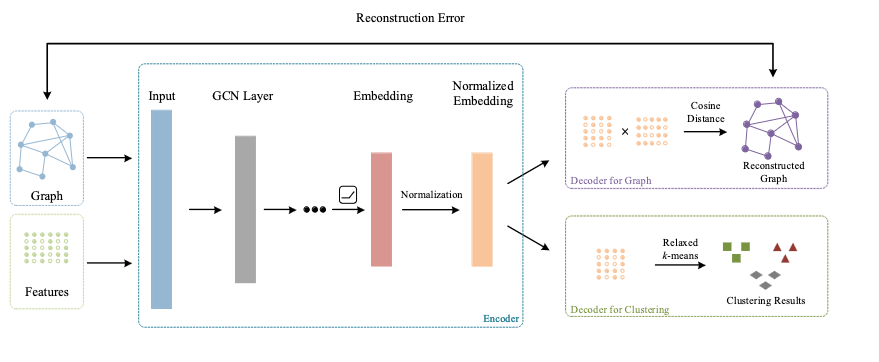

Fig 1. Illustration of EGAE. Inputs of EGAE consist of two parts, graph and features. After encoding, data is mapped into a latent feature space which employs inner-products as metrics [1]

##### Training
Train EGAE model using features and adjacency matrix.

In [27]:
# Parameters
max_epoch = 50
layers = [256, 128]
acts = [torch.nn.functional.relu] * len(layers)
learning_rate = 10**-4*4
pretrain_learning_rate = 0.001
results_dict = {}

#### We test out the cluster characteristics for different regularisation coefficient and alpha values.

1. Regularisation Coefficient: The regularisation coefficient is a hyperparameter that controls the strength of the regularisation applied to the learned node representations. Regularisation is a technique used in machine learning to prevent overfitting, where the model learns to fit noise in the training data rather than the underlying patterns. By introducing regularization, we can encourage the model to produce simpler and more generalizable representations.
In the case of graph autoencoders, the regularization coefficient determines the importance of the graph regularization term in the loss function. The graph regularization term ensures that the learned node representations adhere to the structure of the graph, encouraging similar representations for nodes that are connected in the graph. This helps in capturing the relationships and patterns present in the graph.

2. Alpha : The alpha parameter typically refers to the balance between two components in the loss function used during training. Graph autoencoders are designed to learn representations of nodes in a graph such that they capture the graph structure and the underlying features of the nodes. The loss function guides the learning process by quantifying how well the autoencoder is reconstructing the input data while preserving the graph topology.

In [28]:

def main_s():

    i = 0
    for coeff_reg in [0.001]:
        for alpha in [0.01, 0.1, 1, 10, 100]:
            print('========== alpha={}, reg={} =========='.format(alpha, coeff_reg))
            gae = EGAE(features, adjacency, 5, alpha, layers=layers, acts=acts,
                       max_epoch=max_epoch, max_iter=4, coeff_reg=coeff_reg, learning_rate=learning_rate)
            gae.pretrain(10, learning_rate=pretrain_learning_rate)
            losses, predictions, km, X = gae.run()
    
            analyze_cluster(alpha, predictions, km, X)
            results_dict[alpha] = {
                'predictions': predictions,
                'km': km,
                'X': X
            }
            i += 1 
            
    
    return results_dict


========== alpha=0.01, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.650024890899658
loss: 5.1194
loss: 4.8070
loss: 4.6665
loss: 4.4265
loss: 4.6659
loss: 4.6156
loss: 4.5664
loss: 4.4604
loss: 4.1990
loss: 4.5247
loss: 4.4711
loss: 4.3043
loss: 4.3393
loss: 4.2013
loss: 4.1502
loss: 3.9908
loss: 3.9989
loss: 3.9682
loss: 3.7809
loss: 3.7007
loss: 4.1137
loss: 4.4452
loss: 4.3137
loss: 4.3592
loss: 4.2902
loss: 4.2009
loss: 4.1067
loss: 3.9856
loss: 3.8550
loss: 3.7328
loss: 3.5980
loss: 3.5474
loss: 3.7731
loss: 3.8192
loss: 3.8219
loss: 3.7395
loss: 3.6413
loss: 3.5245
loss: 3.3429
loss: 3.1237
loss: 3.2664
loss: 3.0388
loss: 3.1351
loss: 3.0441
loss: 3.3532
loss: 3.1448
loss: 3.0811
loss: 3.0315
loss: 2.9701


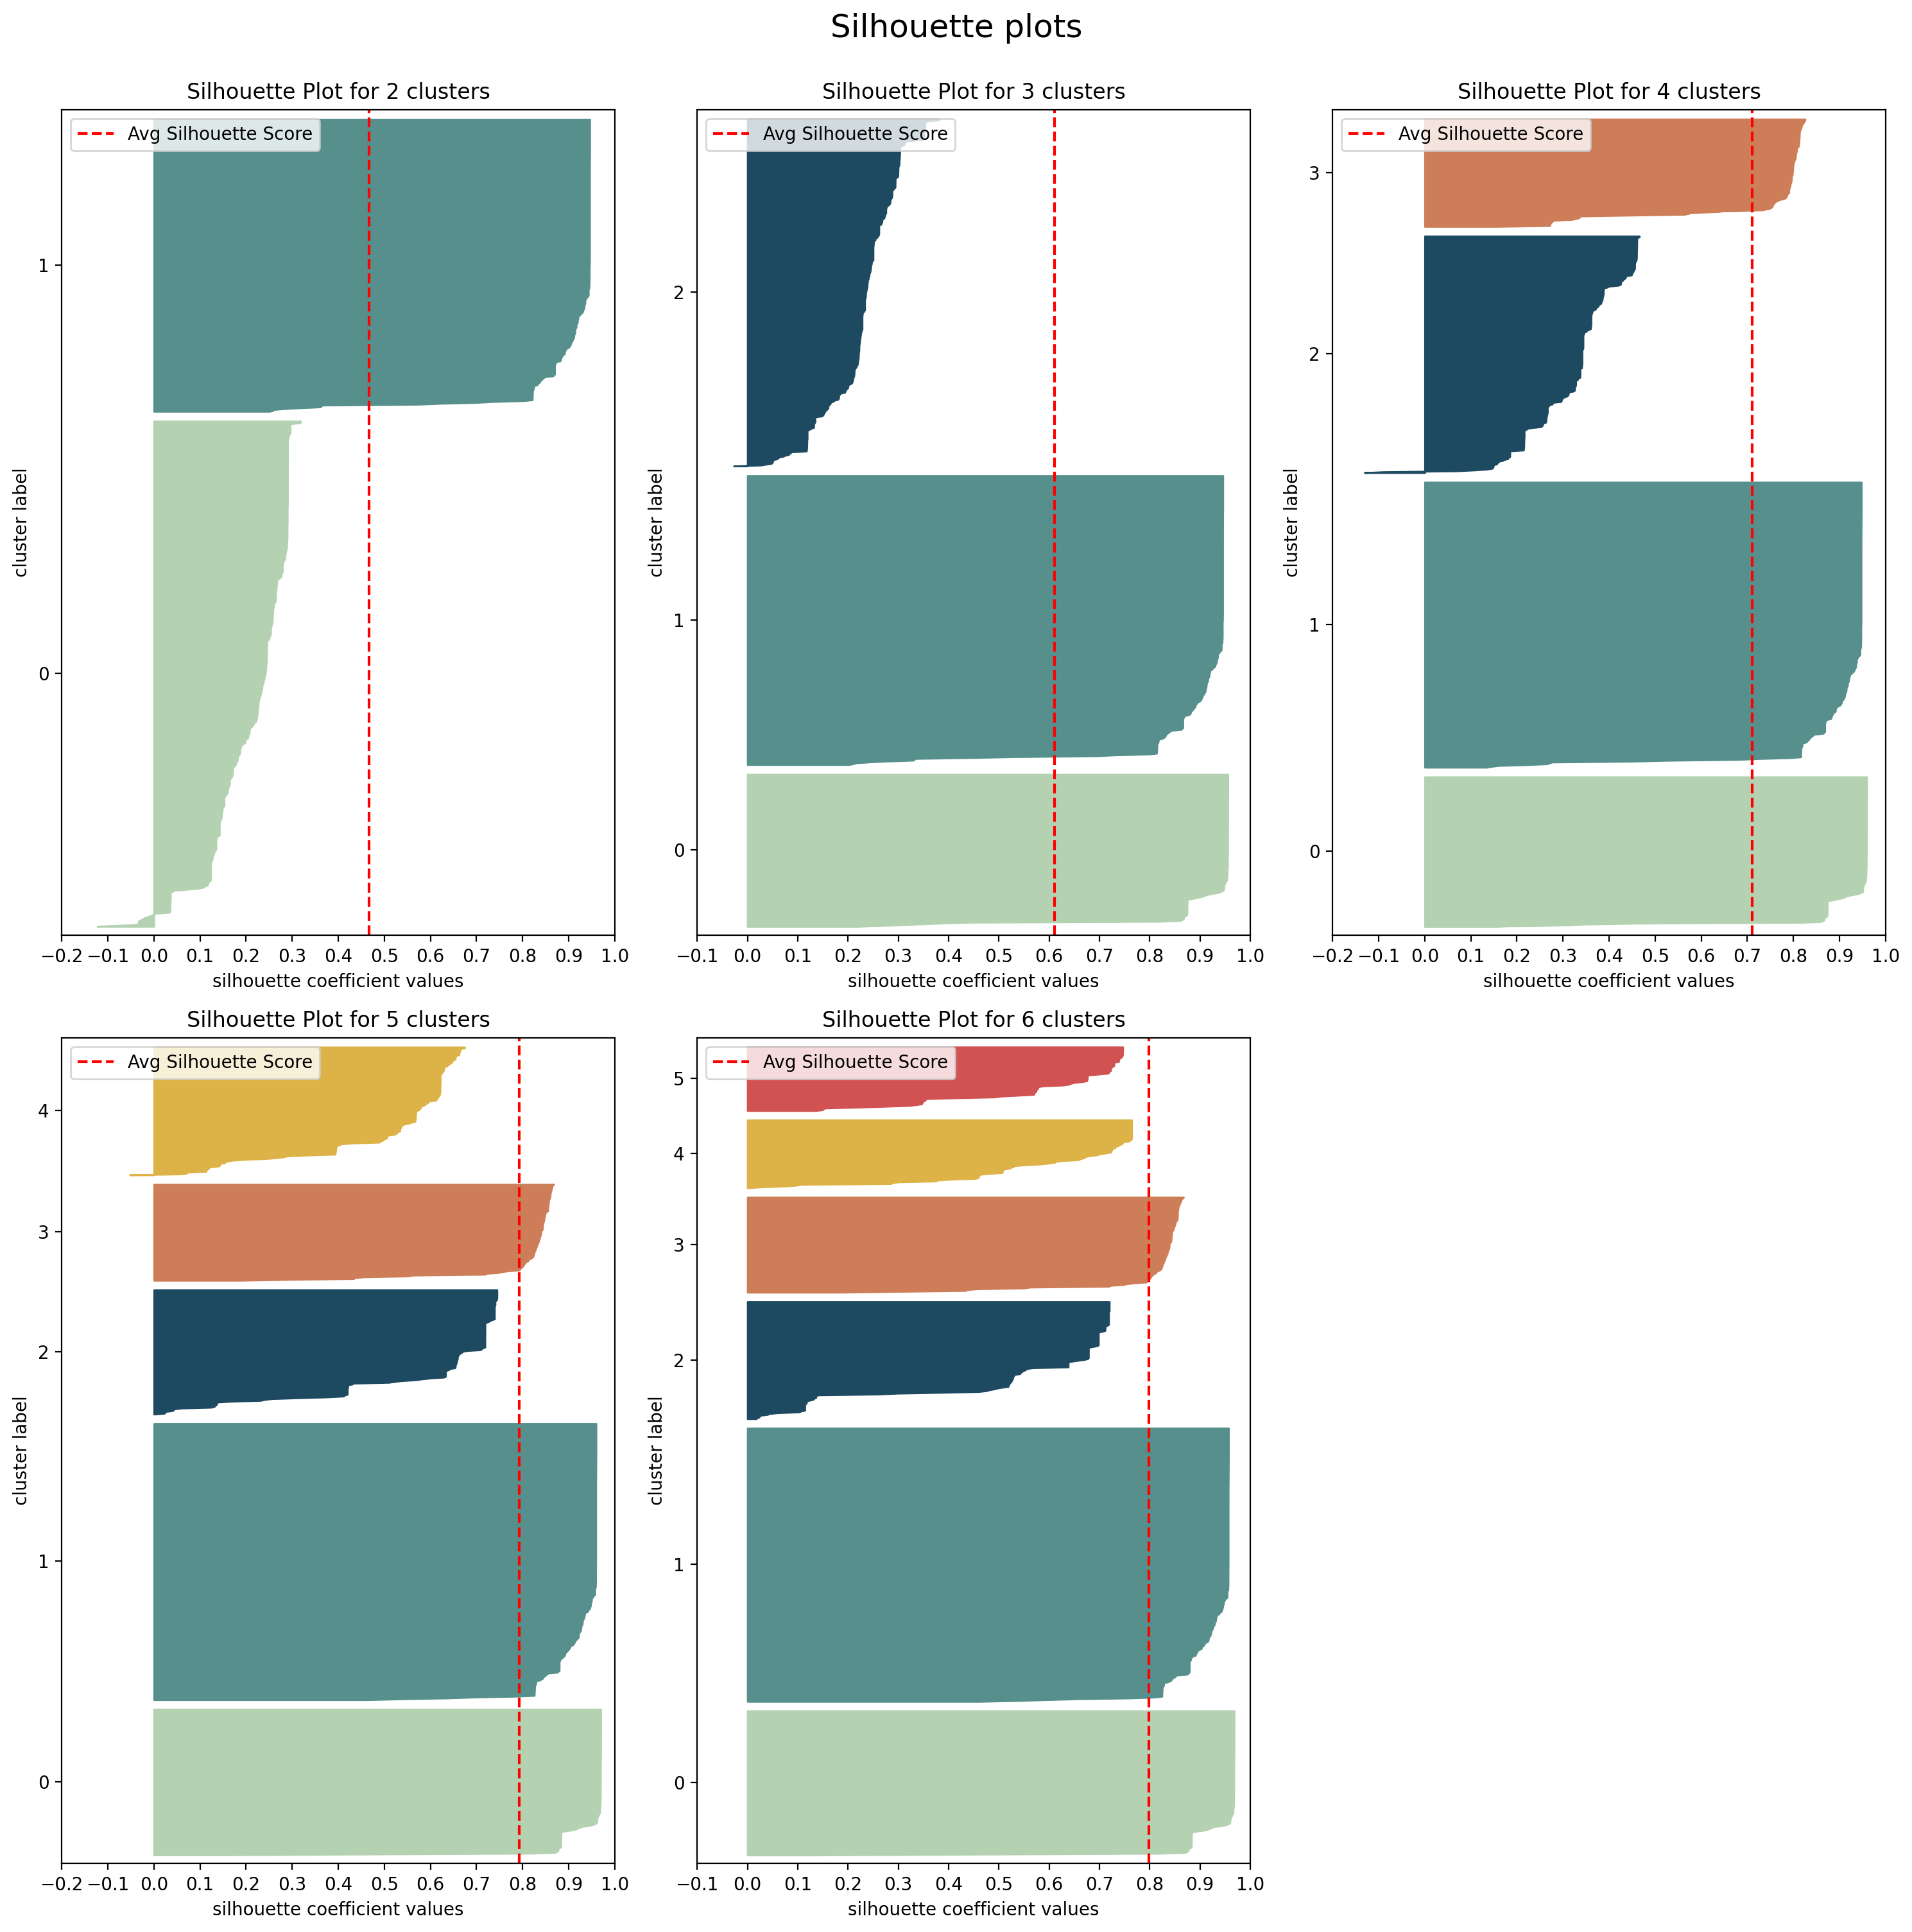

loss: 2.9238
========== reg=0.01 ==========


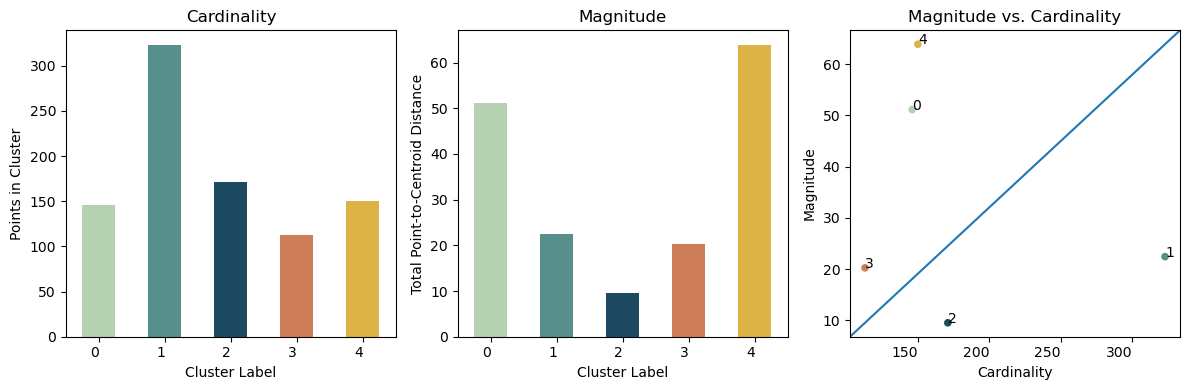

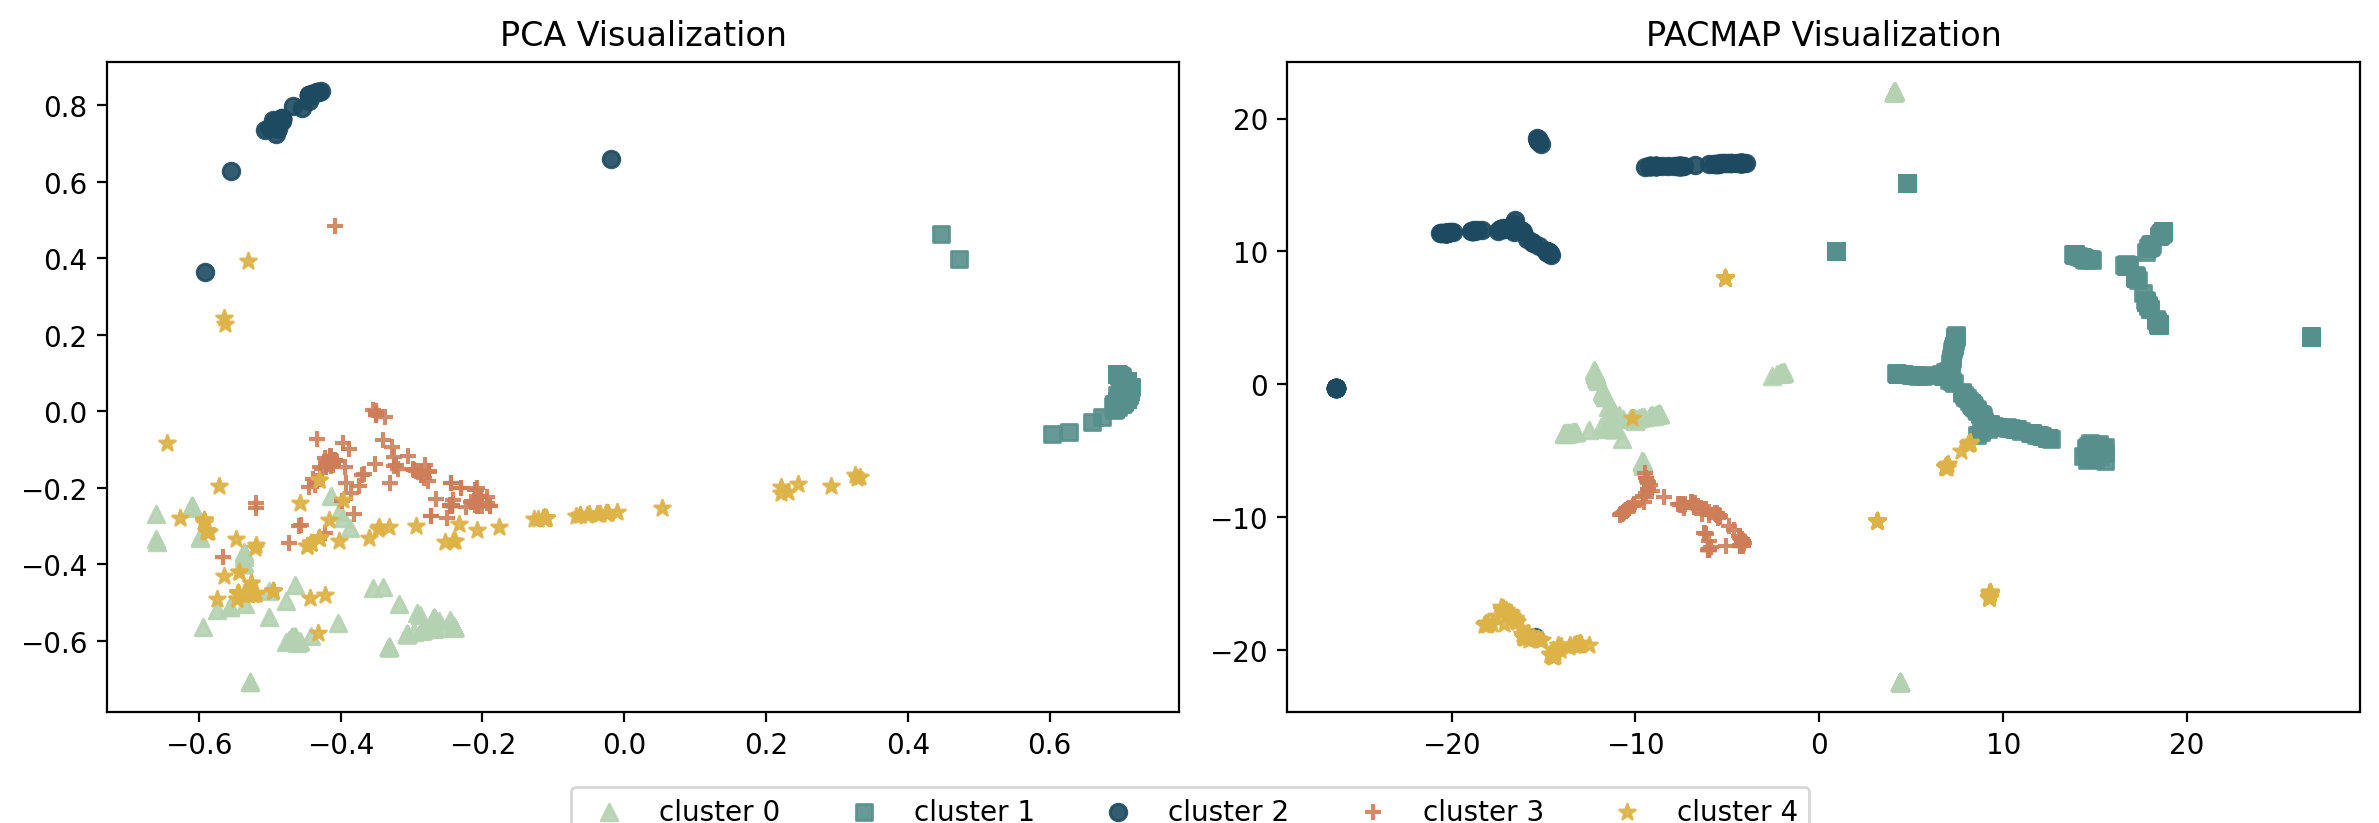

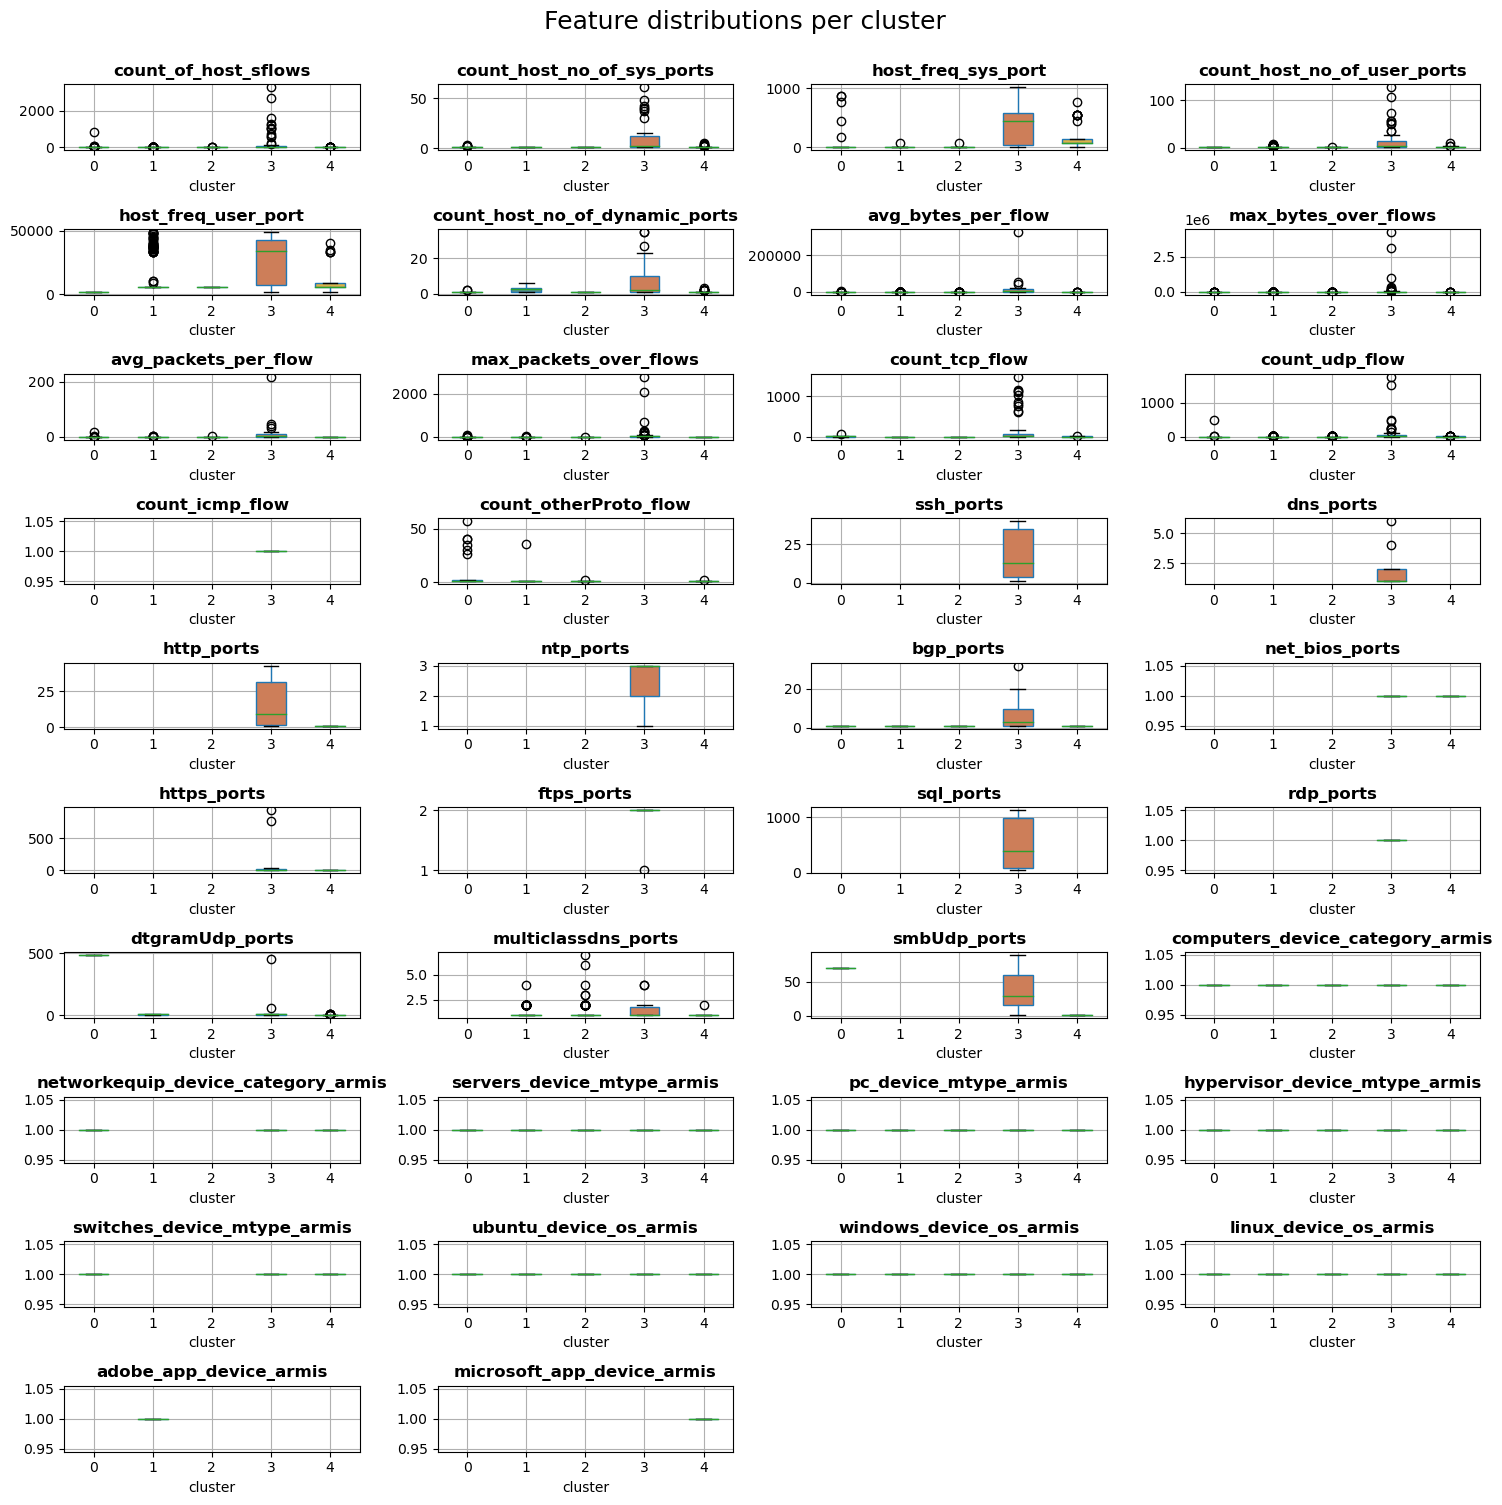

                                   0
cluster category                    
0       Computers          20.547945
        Network Equipment   0.684932
1       Computers          59.133127
2       Computers          55.555556
3       Computers          15.929204
        Network Equipment   9.734513
4       Computers          35.333333
        Network Equipment   1.333333
                                    0
cluster mtype                        
0       Hypervisor           2.054795
        Personal Computers   2.739726
        Servers             15.753425
        Switches             0.684932
1       Hypervisor           1.547988
        Personal Computers   4.024768
        Servers             51.702786
2       Hypervisor           1.754386
        Personal Computers   2.923977
        Servers             43.859649
3       Hypervisor           0.884956
        Personal Computers   2.654867
        Servers             12.389381
        Switches             7.964602
4       Hypervisor    

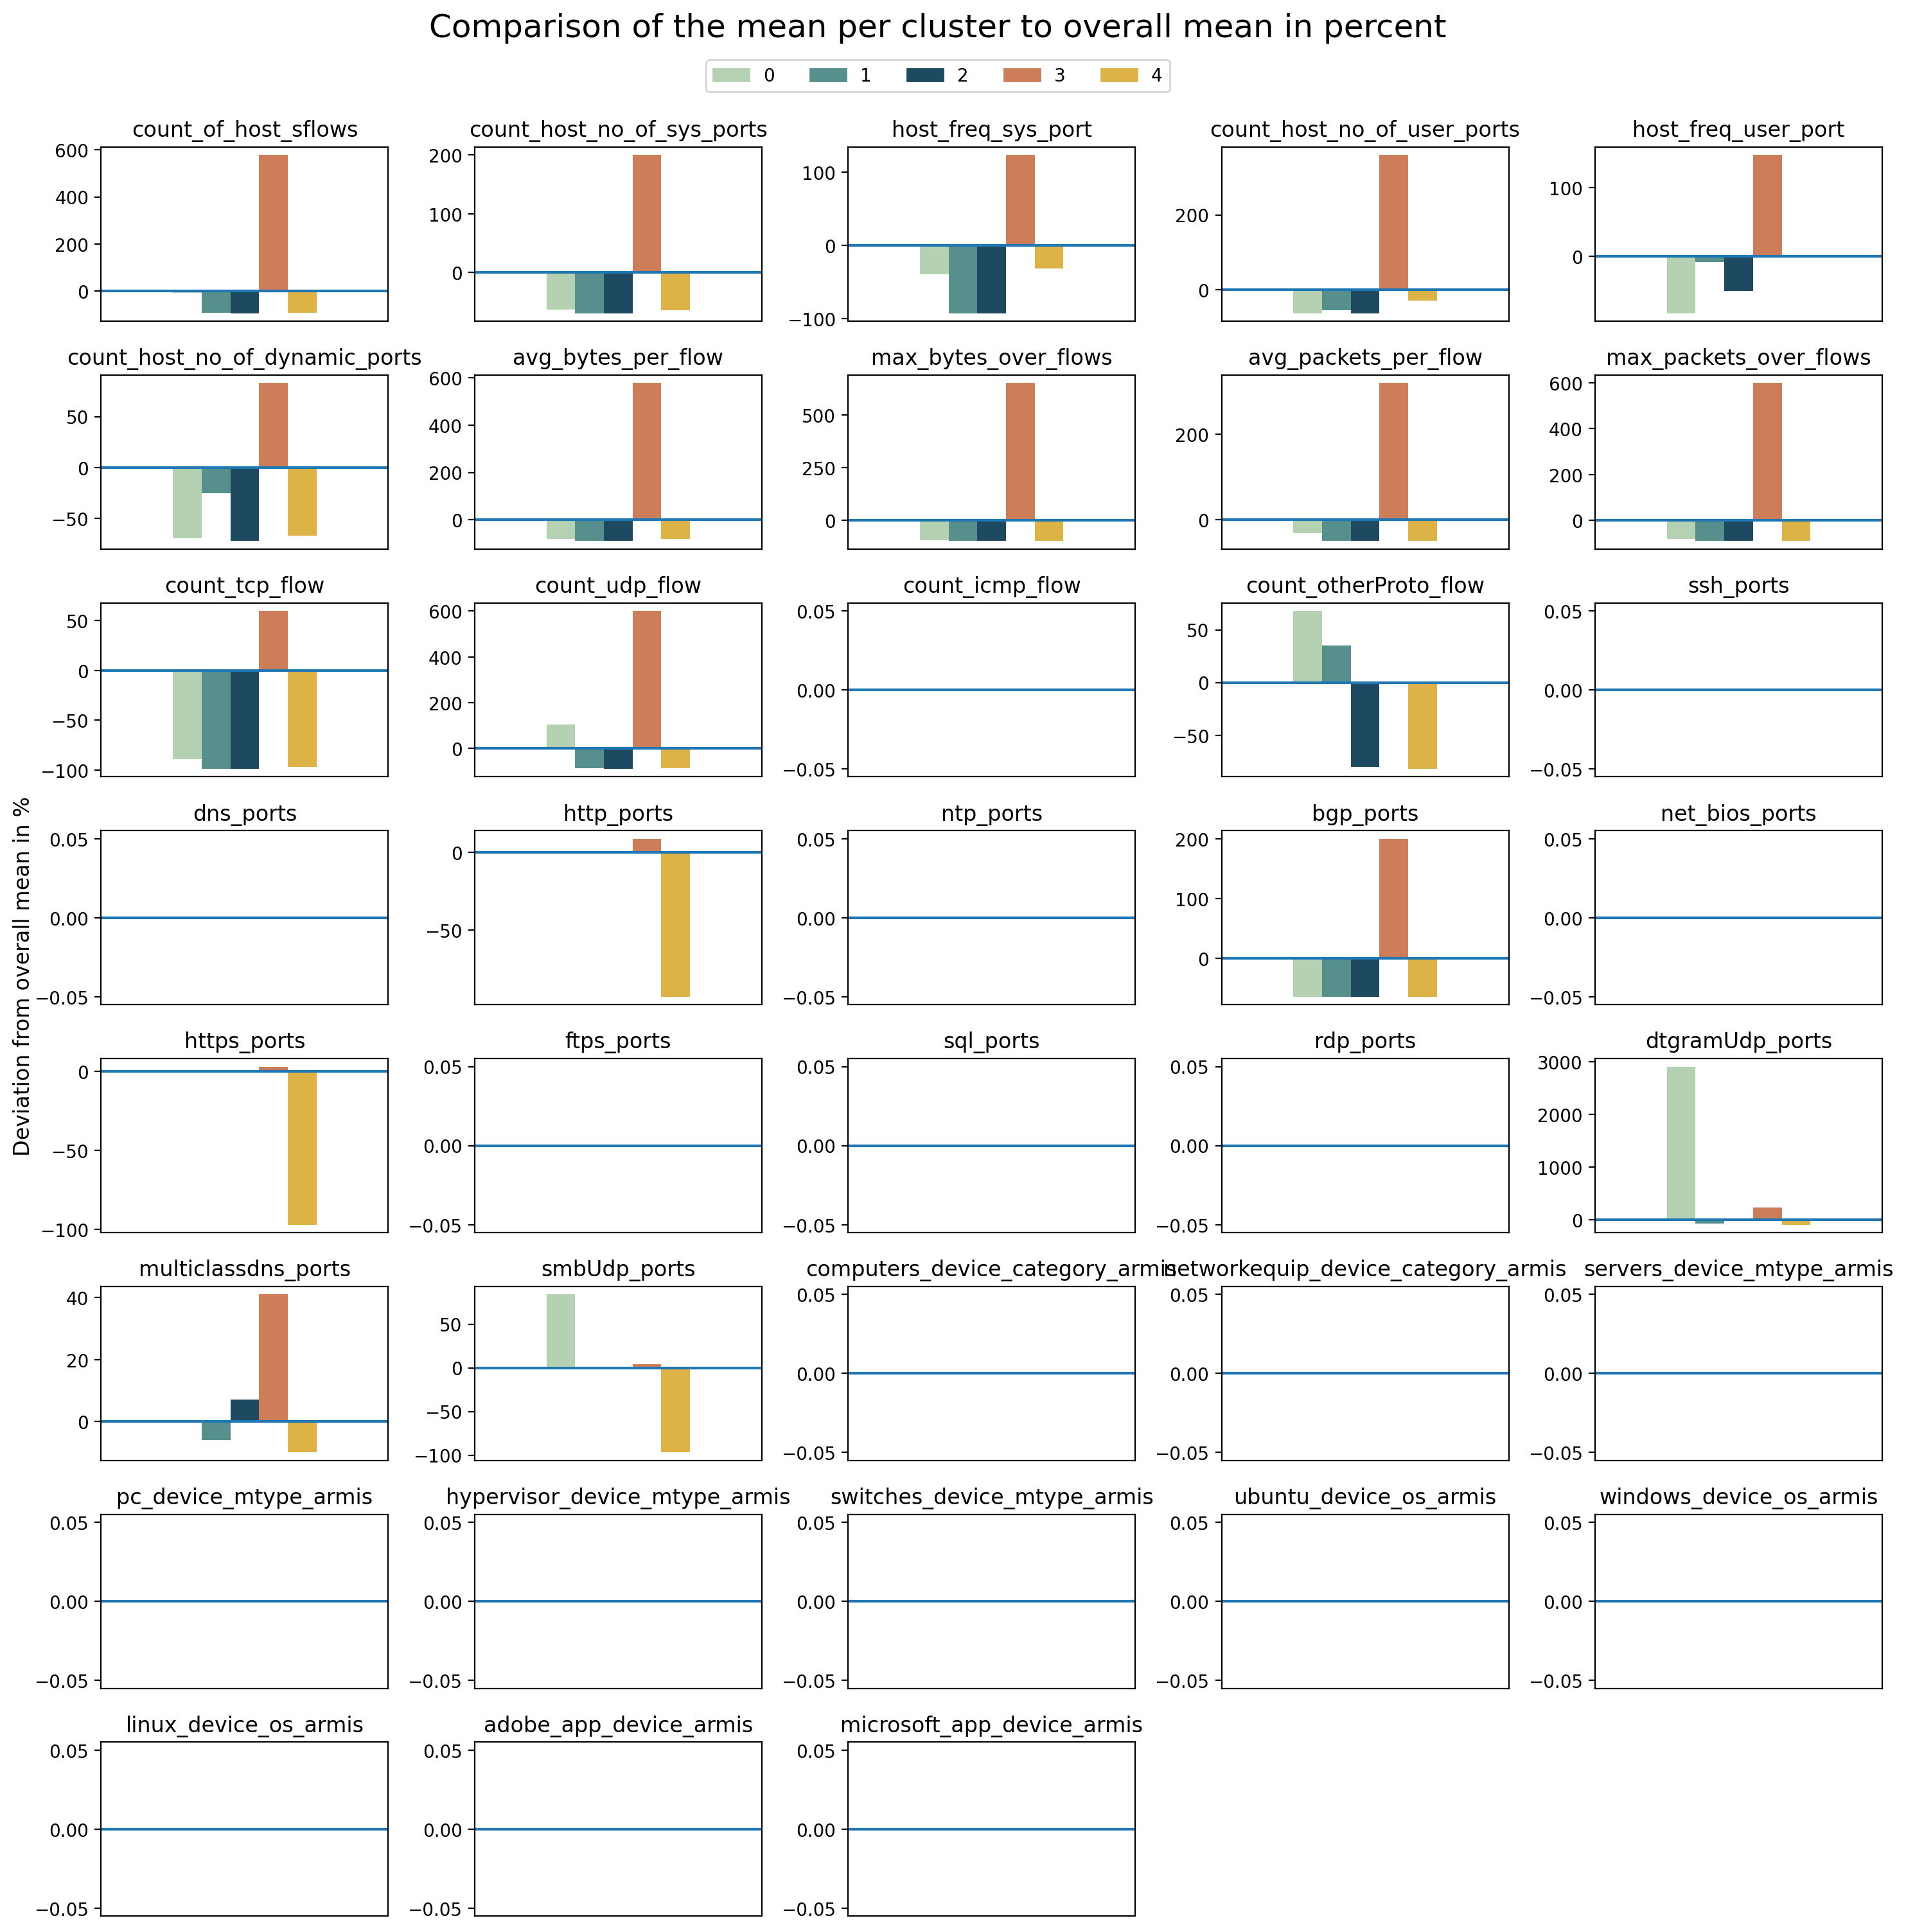

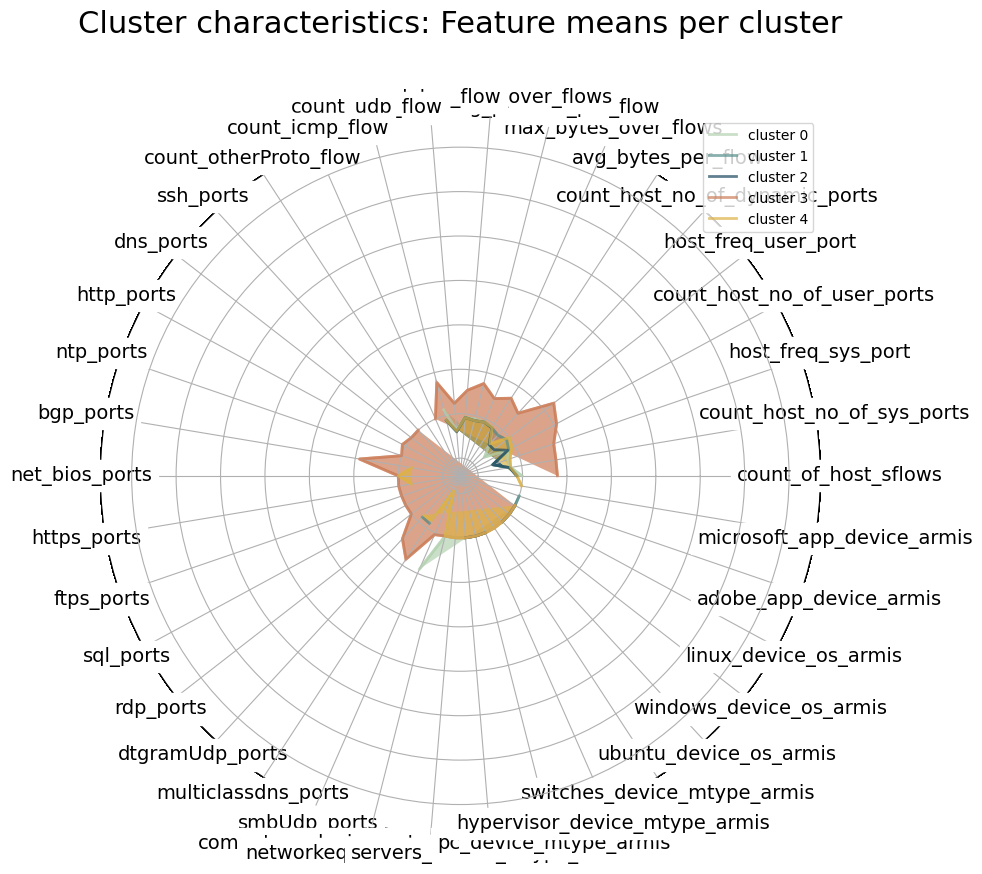

========== alpha=0.1, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.161776542663574
loss: 5.7126
loss: 5.4275
loss: 5.1228
loss: 4.7497
loss: 4.6794
loss: 4.5525
loss: 4.3000
loss: 4.3901
loss: 4.3480
loss: 4.1637
loss: 3.9518
loss: 3.9738
loss: 3.8685
loss: 4.2367
loss: 4.3139
loss: 4.3241
loss: 4.2592
loss: 4.1061
loss: 3.9912
loss: 3.8247
loss: 3.7410
loss: 4.1648
loss: 4.1466
loss: 4.0303
loss: 3.9307
loss: 3.7775
loss: 3.6395
loss: 3.5614
loss: 3.4124
loss: 3.4486
loss: 3.3558
loss: 3.3420
loss: 3.2614
loss: 3.1598
loss: 3.4319
loss: 3.4852
loss: 3.5402
loss: 3.4776
loss: 3.3440
loss: 3.2158
loss: 3.0362
loss: 3.1333
loss: 3.7846
loss: 3.8605
loss: 3.9271
loss: 3.9685
loss: 3.9069
loss: 3.8283
loss: 3.7626


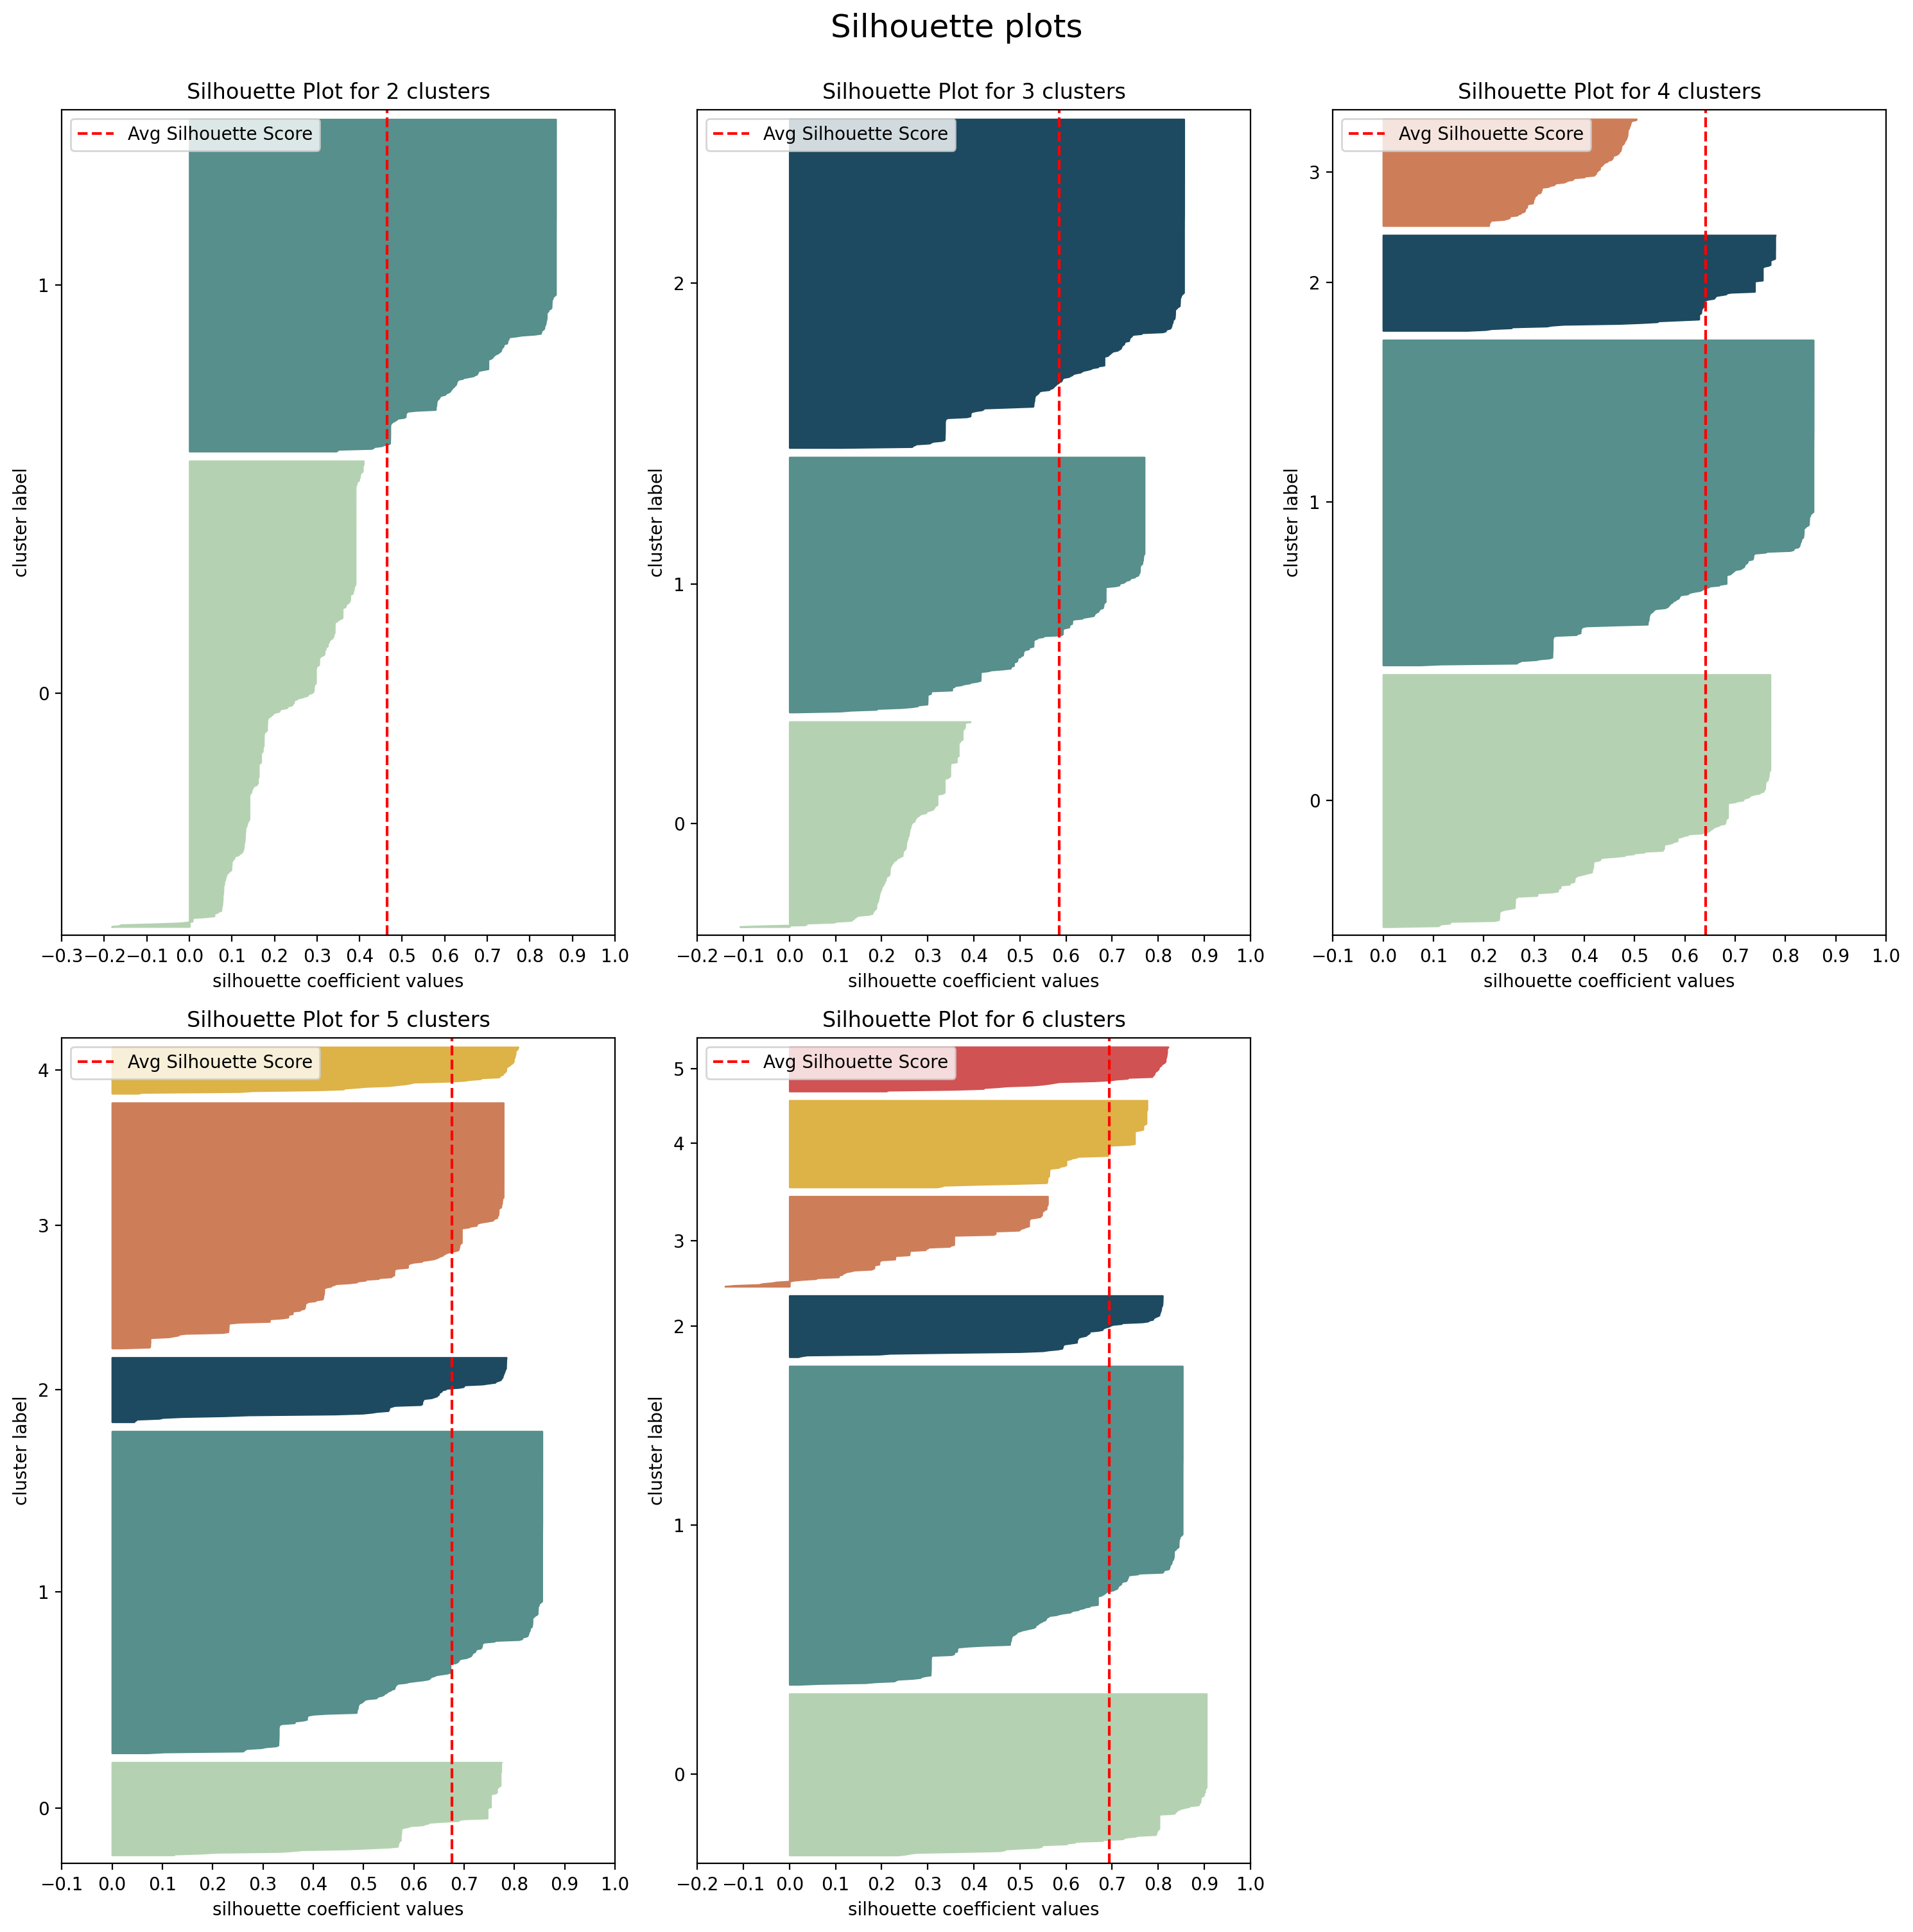

loss: 3.6970
========== reg=0.1 ==========


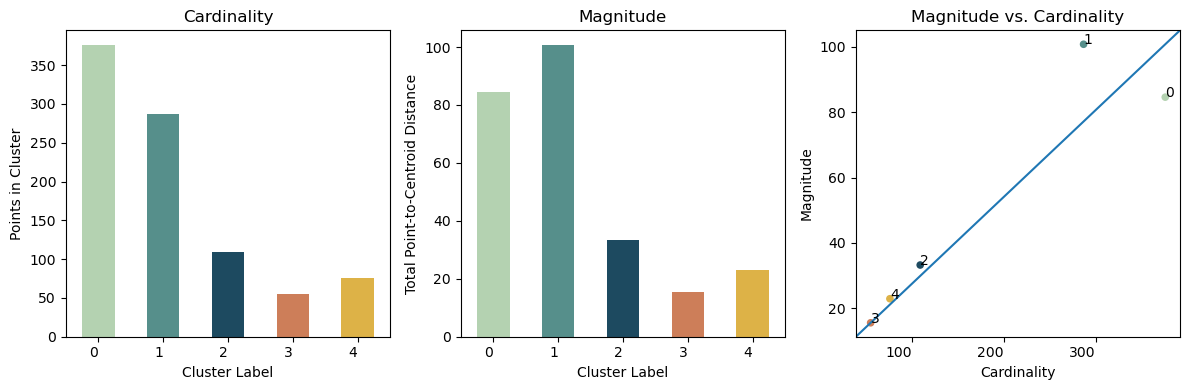

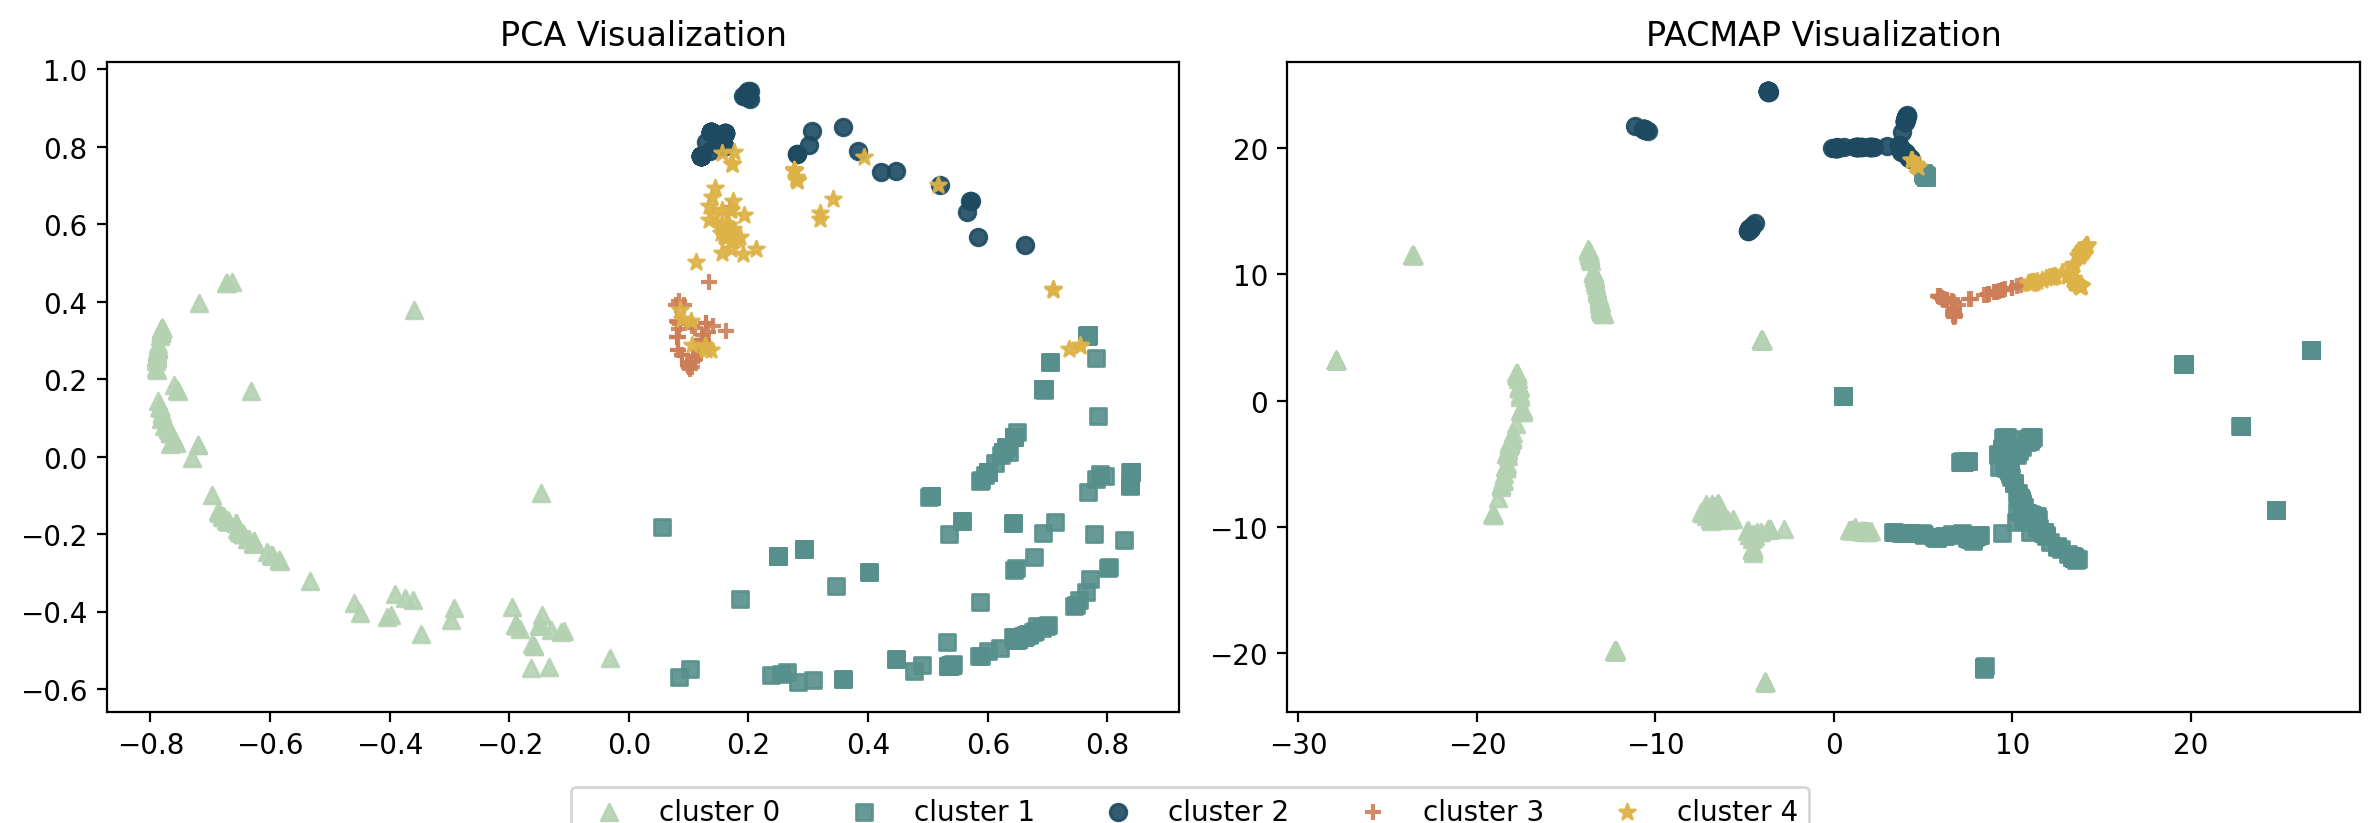

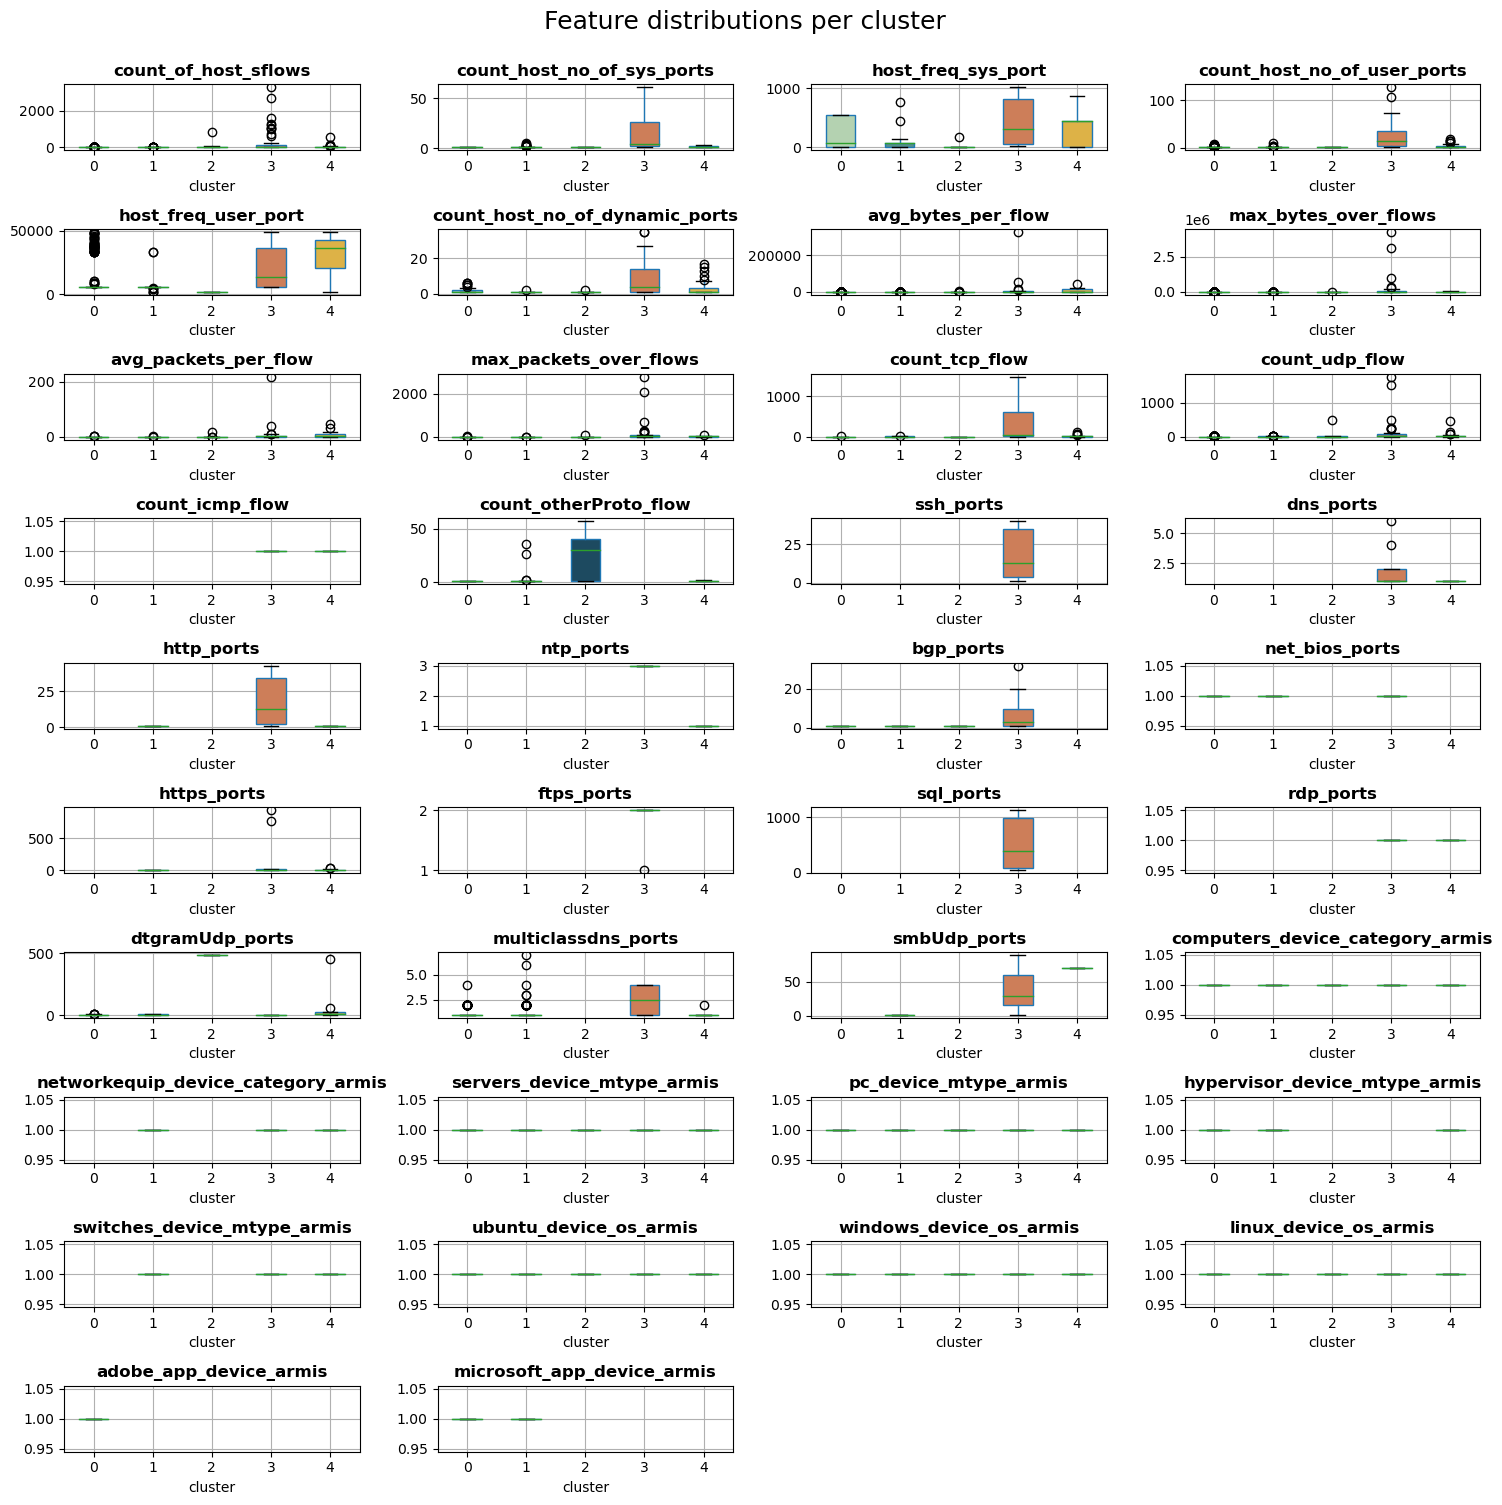

                                   0
cluster category                    
0       Computers          57.180851
1       Computers          45.993031
        Network Equipment   0.696864
2       Computers          10.091743
3       Computers          12.727273
        Network Equipment  14.545455
4       Computers          28.947368
        Network Equipment   5.263158
                                    0
cluster mtype                        
0       Hypervisor           1.595745
        Personal Computers   5.053191
        Servers             48.936170
1       Hypervisor           2.090592
        Personal Computers   2.090592
        Servers             37.630662
        Switches             0.696864
2       Personal Computers   0.917431
        Servers              9.174312
3       Personal Computers   5.454545
        Servers              7.272727
        Switches            14.545455
4       Hypervisor           3.947368
        Personal Computers   3.947368
        Servers       

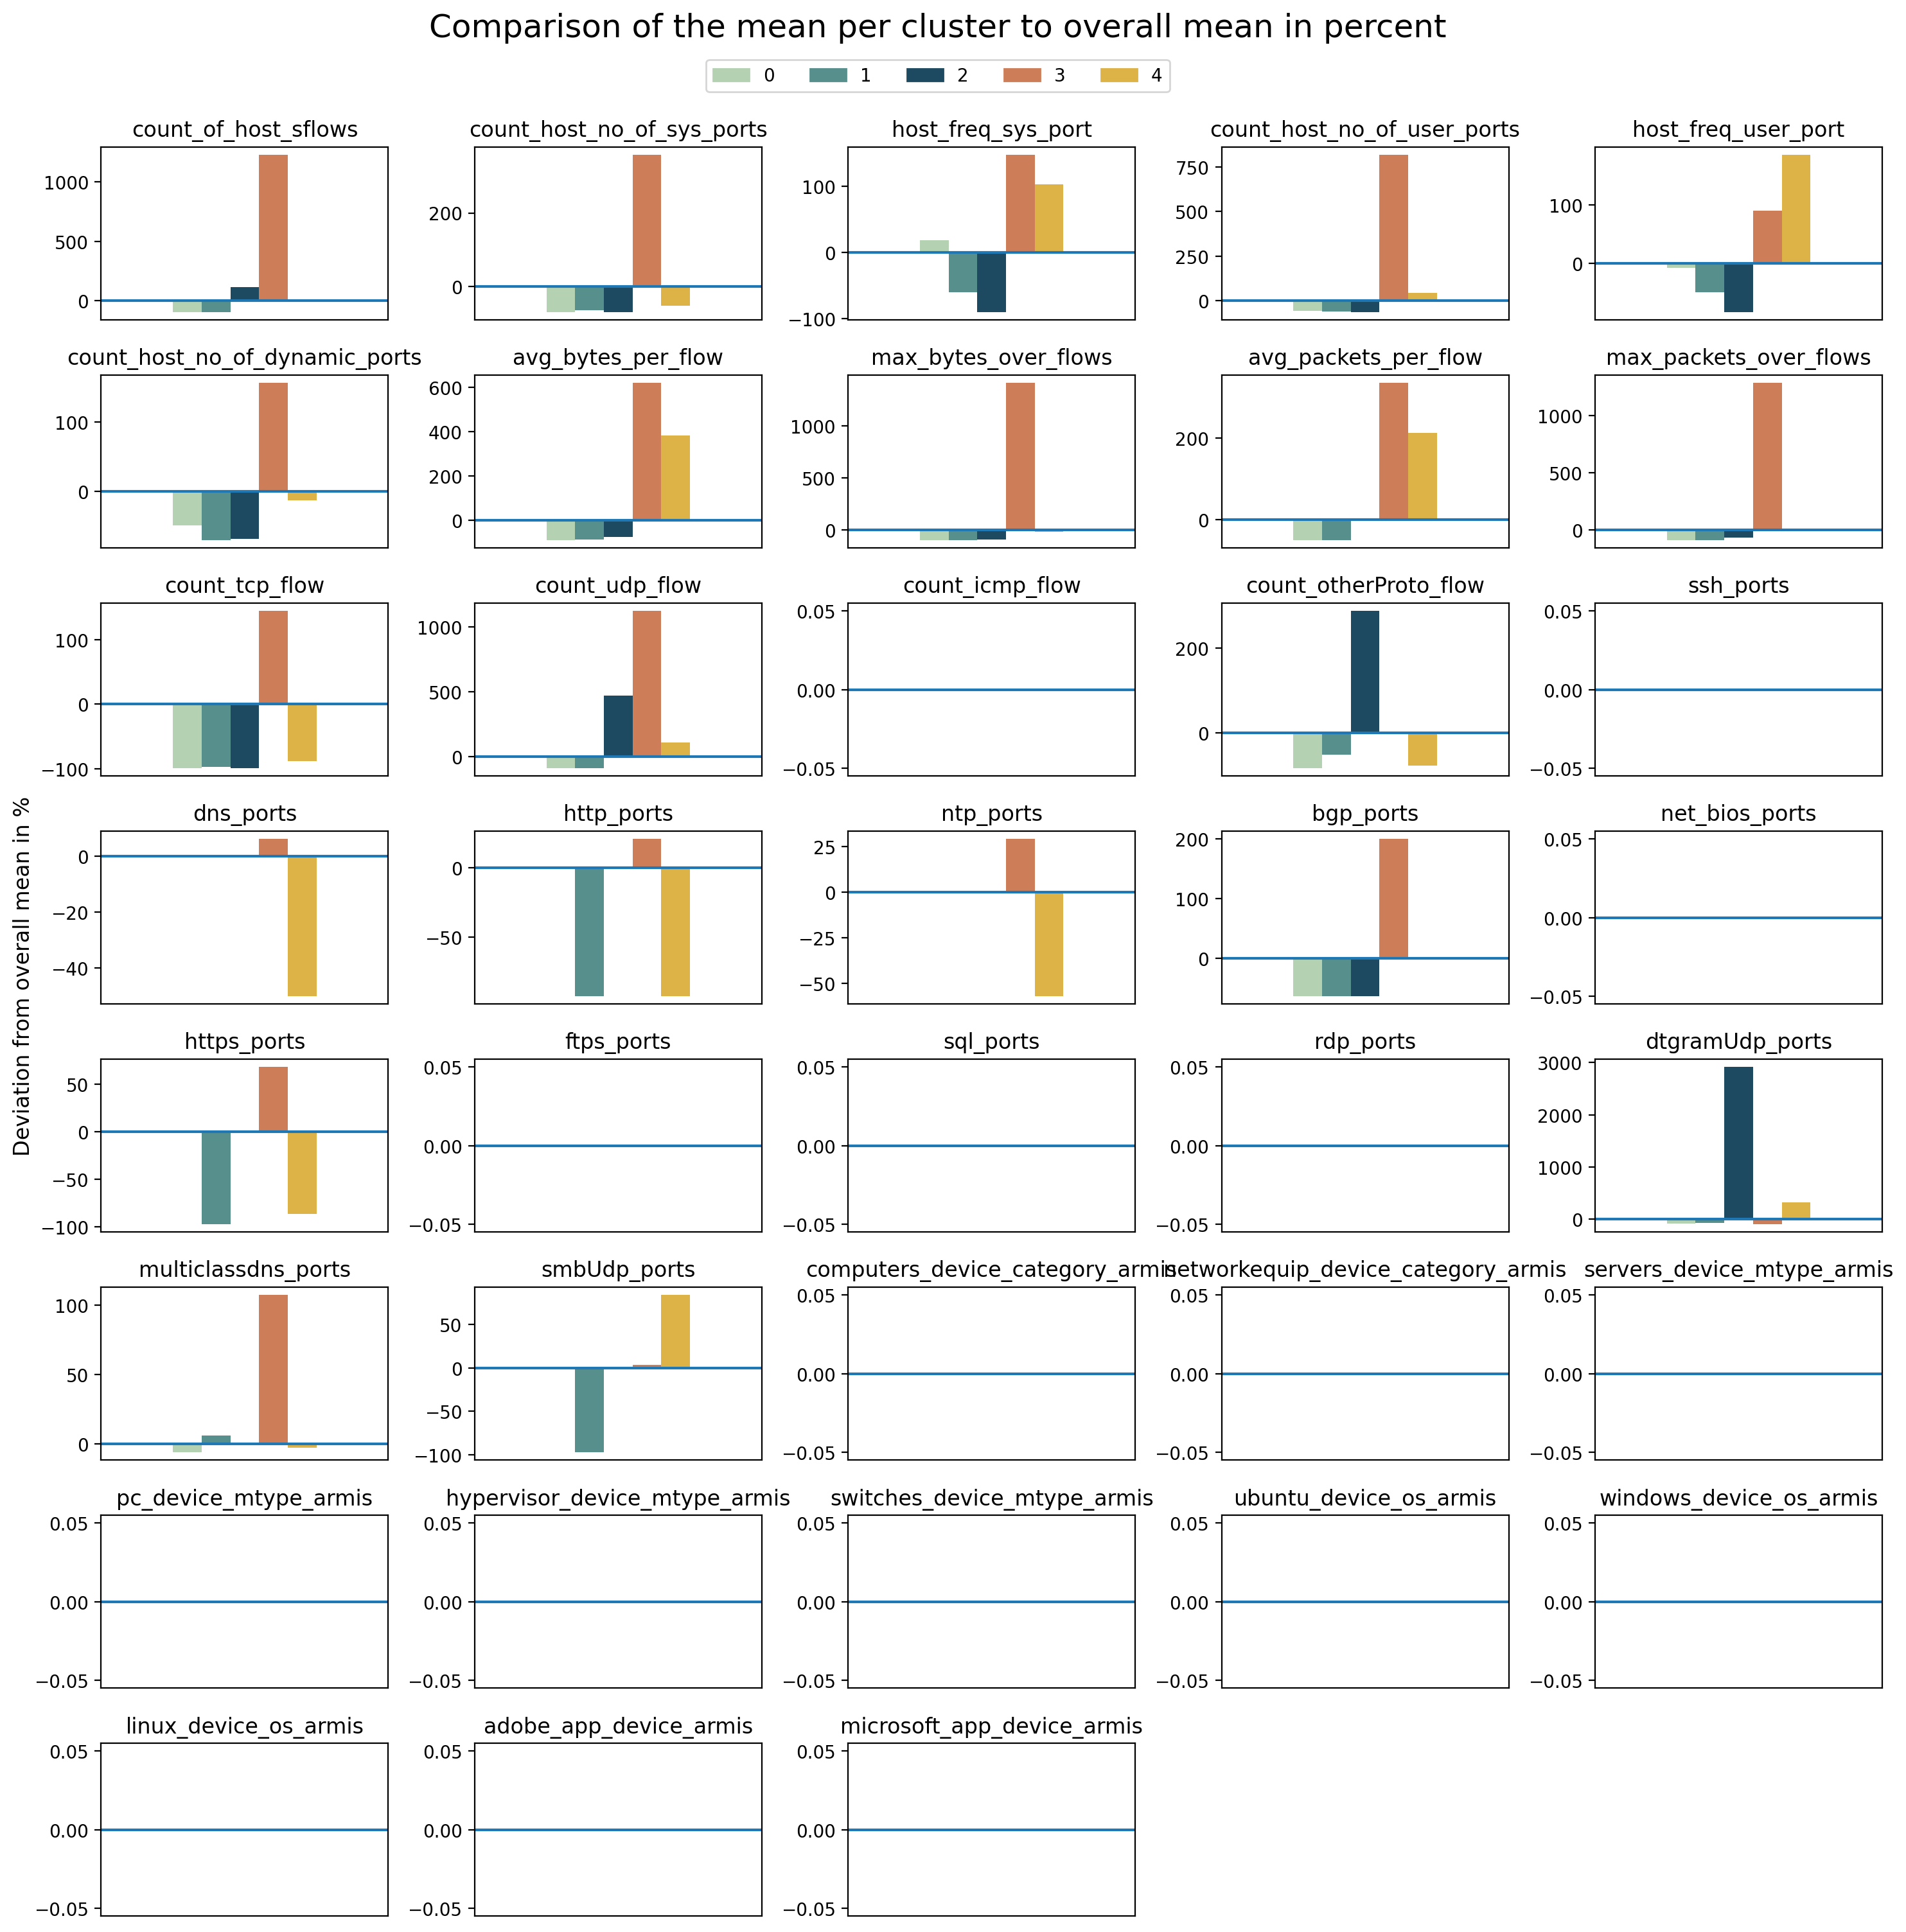

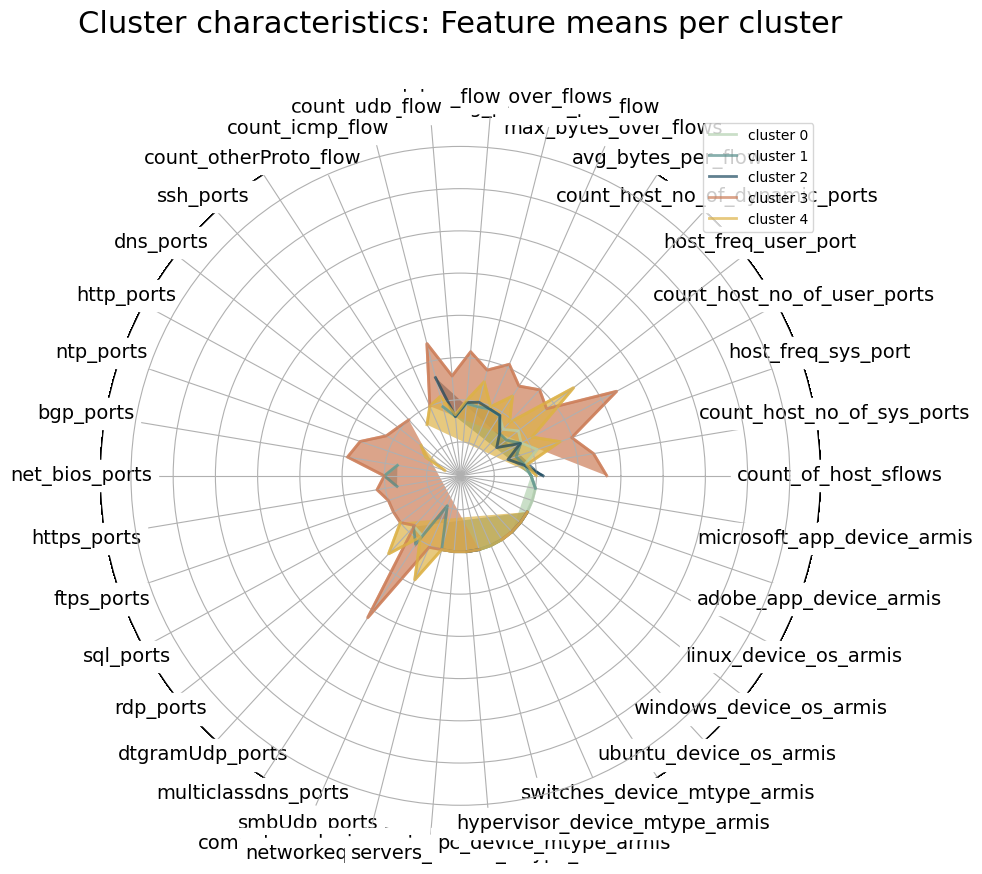

========== alpha=1, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.029397010803223
loss: 5.5539
loss: 5.2508
loss: 4.8604
loss: 4.4400
loss: 4.3519
loss: 4.2936
loss: 4.2889
loss: 4.2124
loss: 4.1156
loss: 4.0137
loss: 3.9844
loss: 3.8820
loss: 4.0065
loss: 4.0903
loss: 4.3793
loss: 4.4574
loss: 4.5213
loss: 4.5147
loss: 4.4790
loss: 4.4537
loss: 4.4046
loss: 4.3501
loss: 4.2774
loss: 4.2173
loss: 4.1642
loss: 4.0948
loss: 4.0651
loss: 4.0255
loss: 3.9652
loss: 3.8878
loss: 3.7911
loss: 3.6832
loss: 3.6058
loss: 3.5630
loss: 3.5314
loss: 3.4054
loss: 3.3203
loss: 3.3391
loss: 3.1088
loss: 3.3246
loss: 3.3499
loss: 3.3261
loss: 3.1959
loss: 3.0085
loss: 2.9451
loss: 2.9411
loss: 2.8507
loss: 2.8888
loss: 2.9113


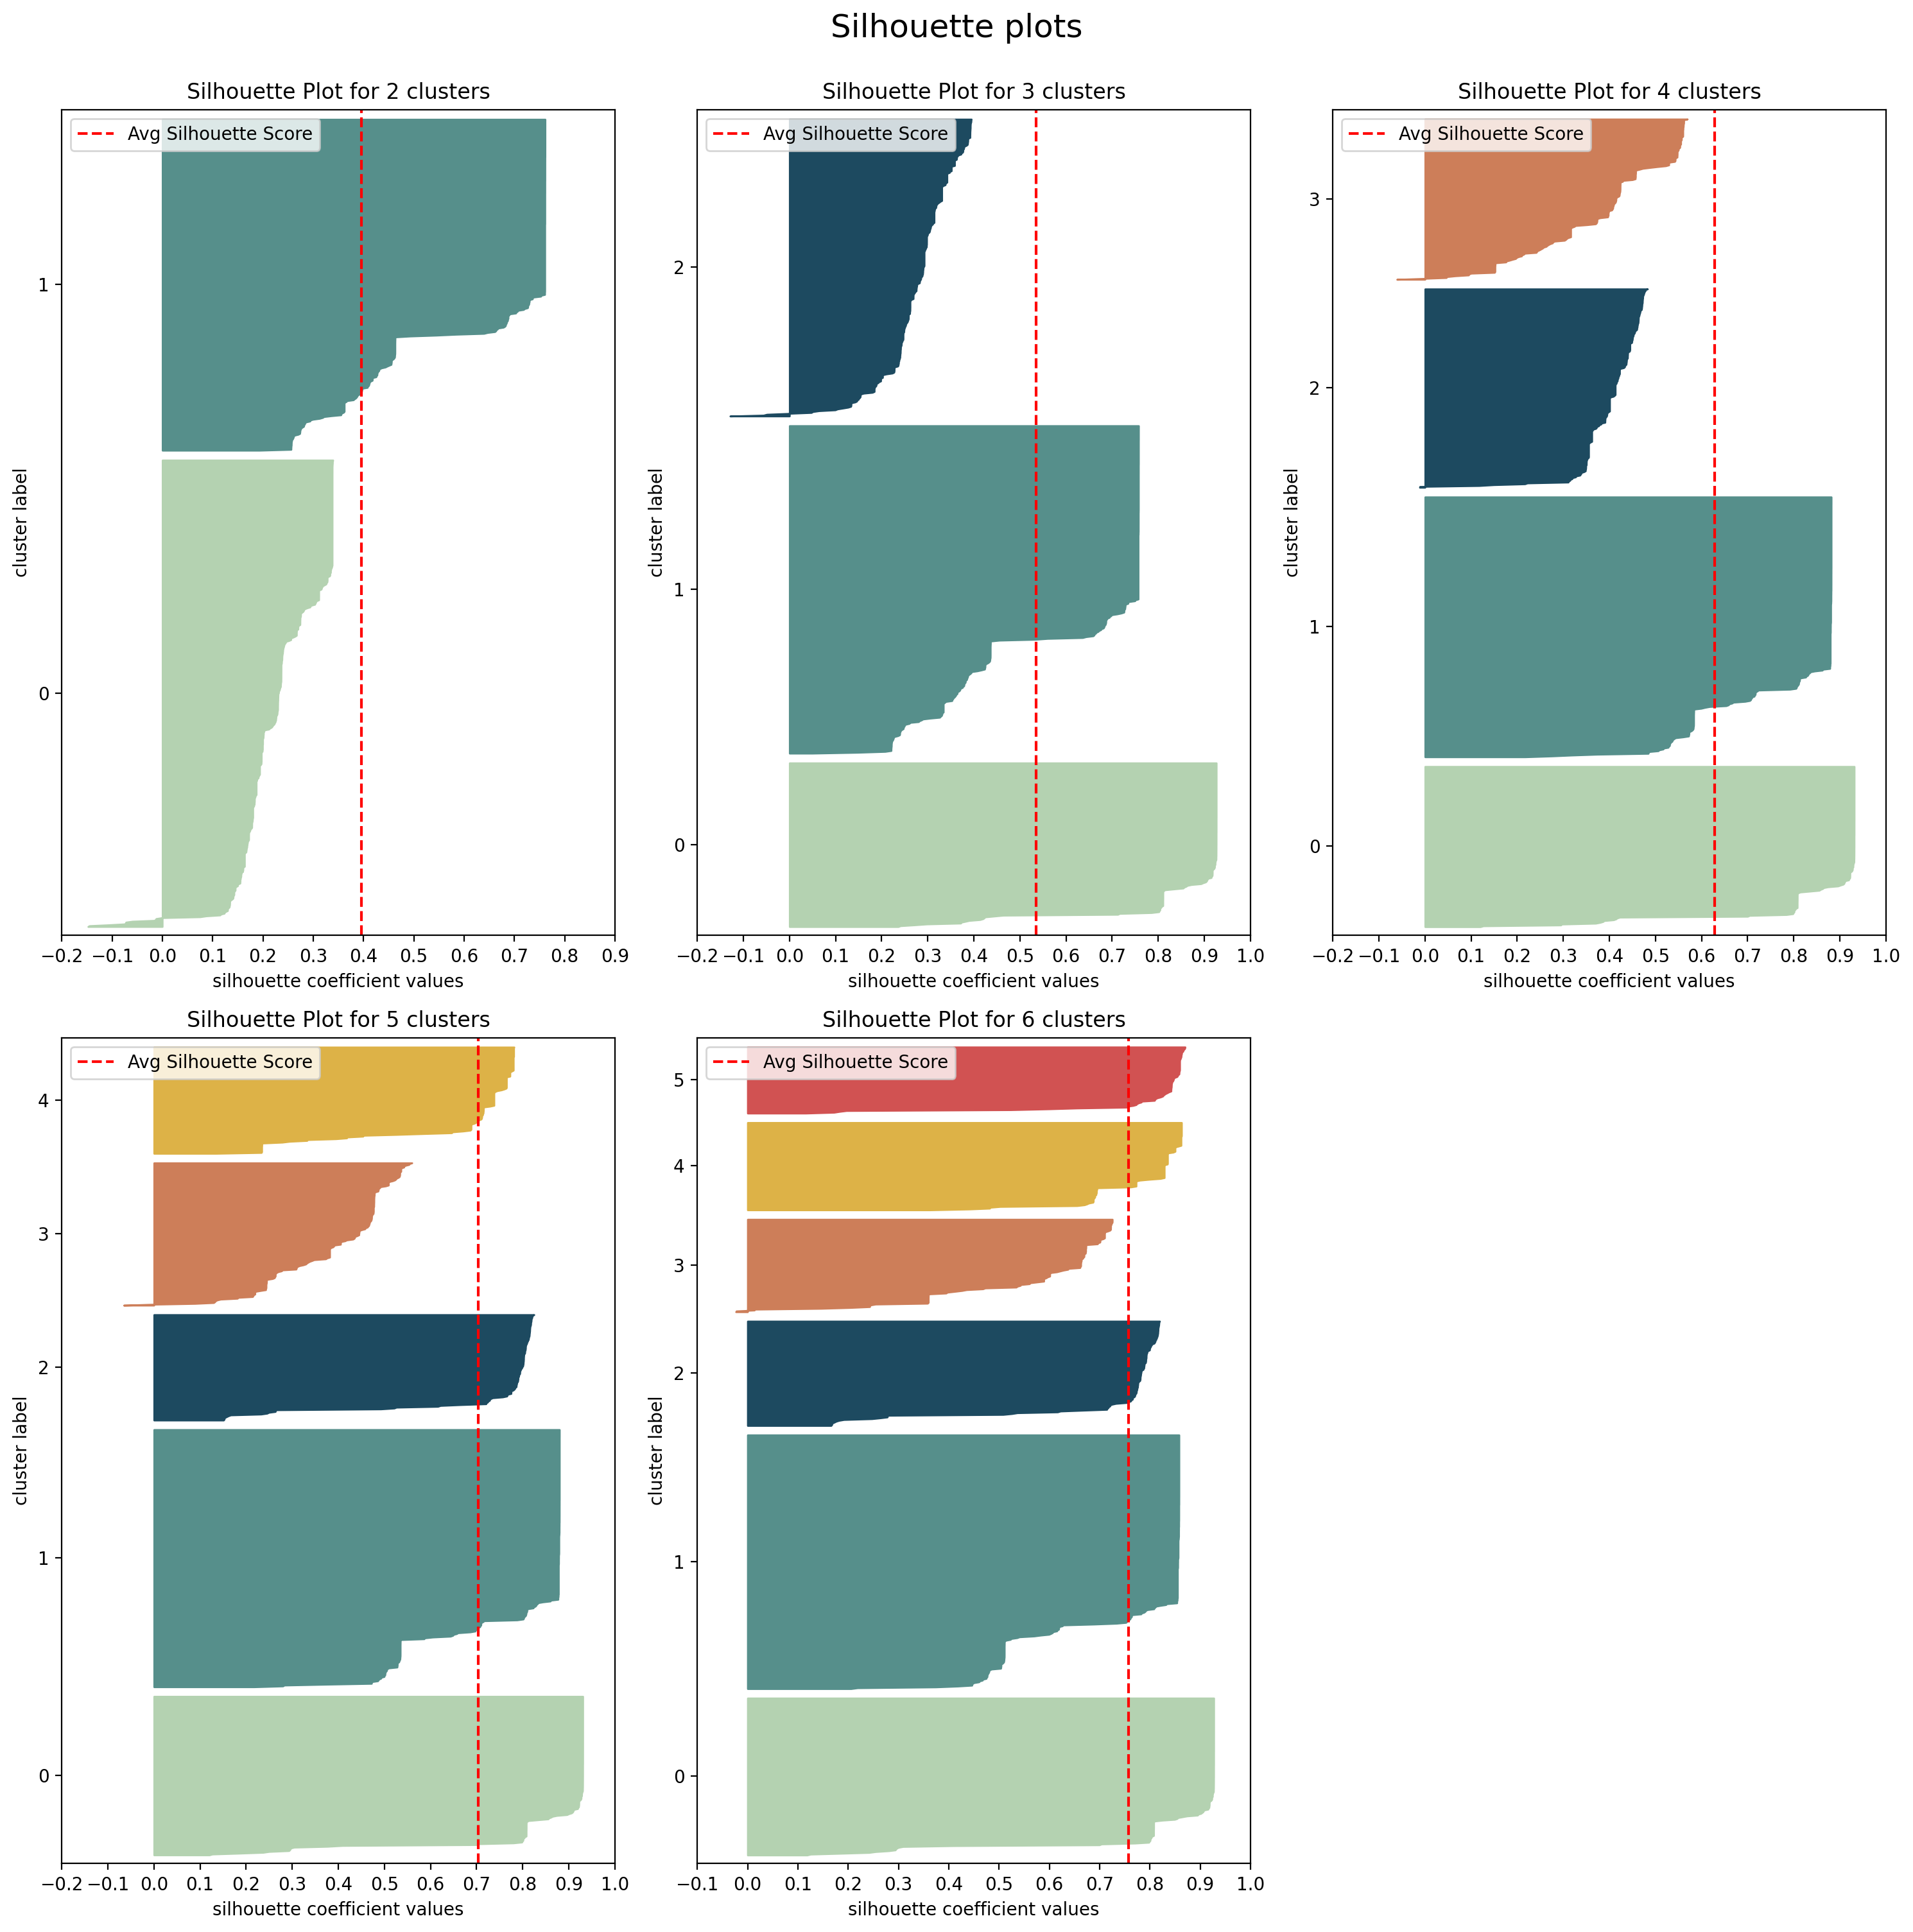

loss: 3.1263
========== reg=1 ==========


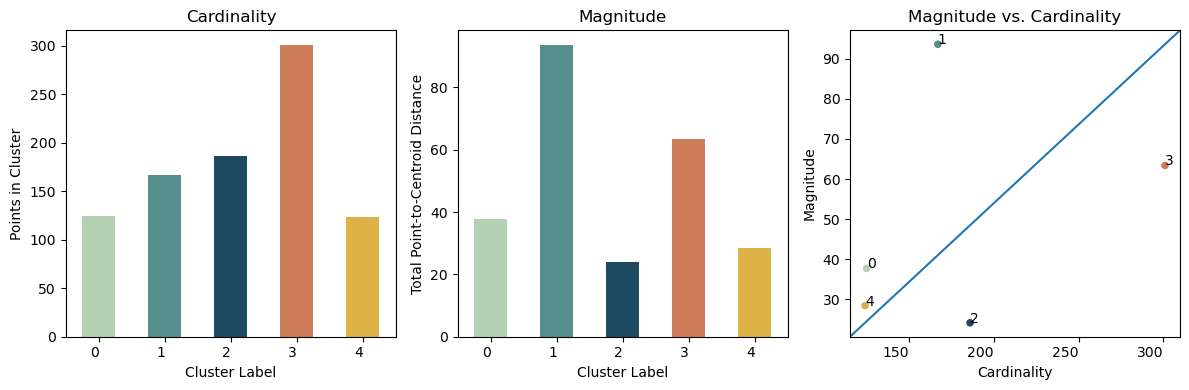

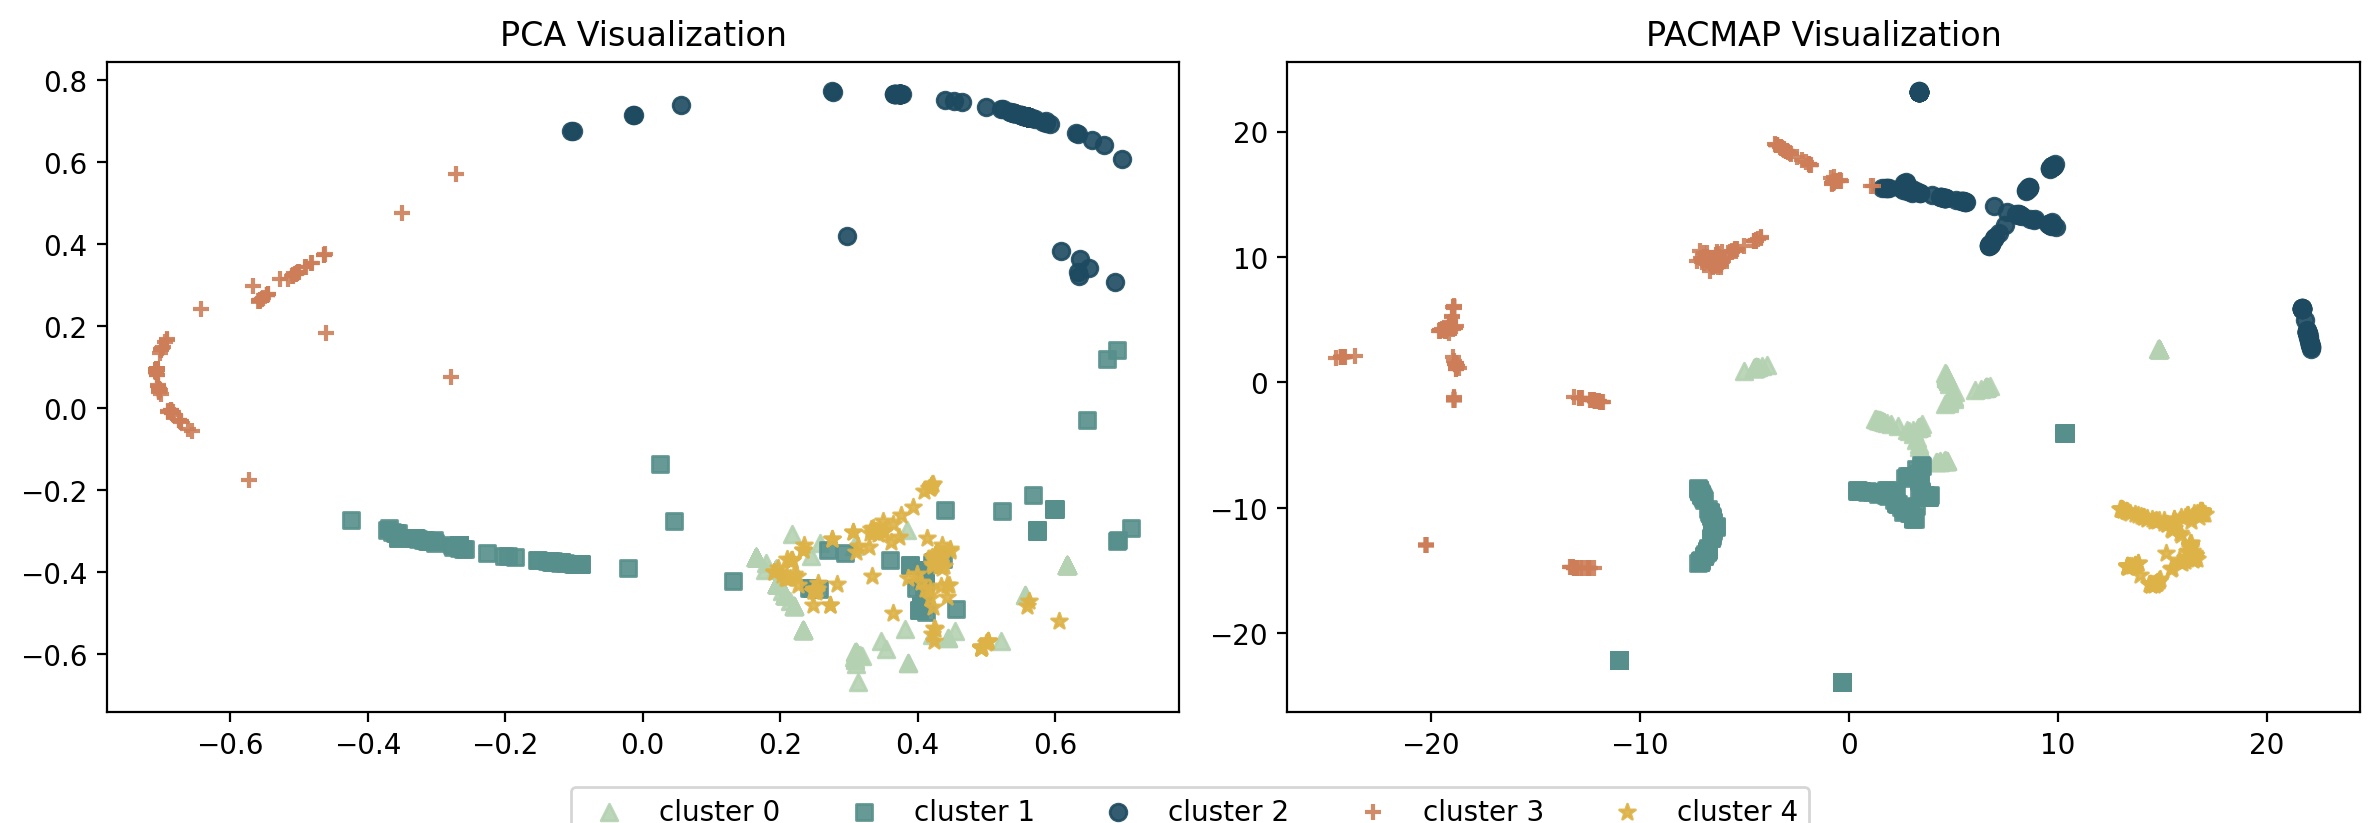

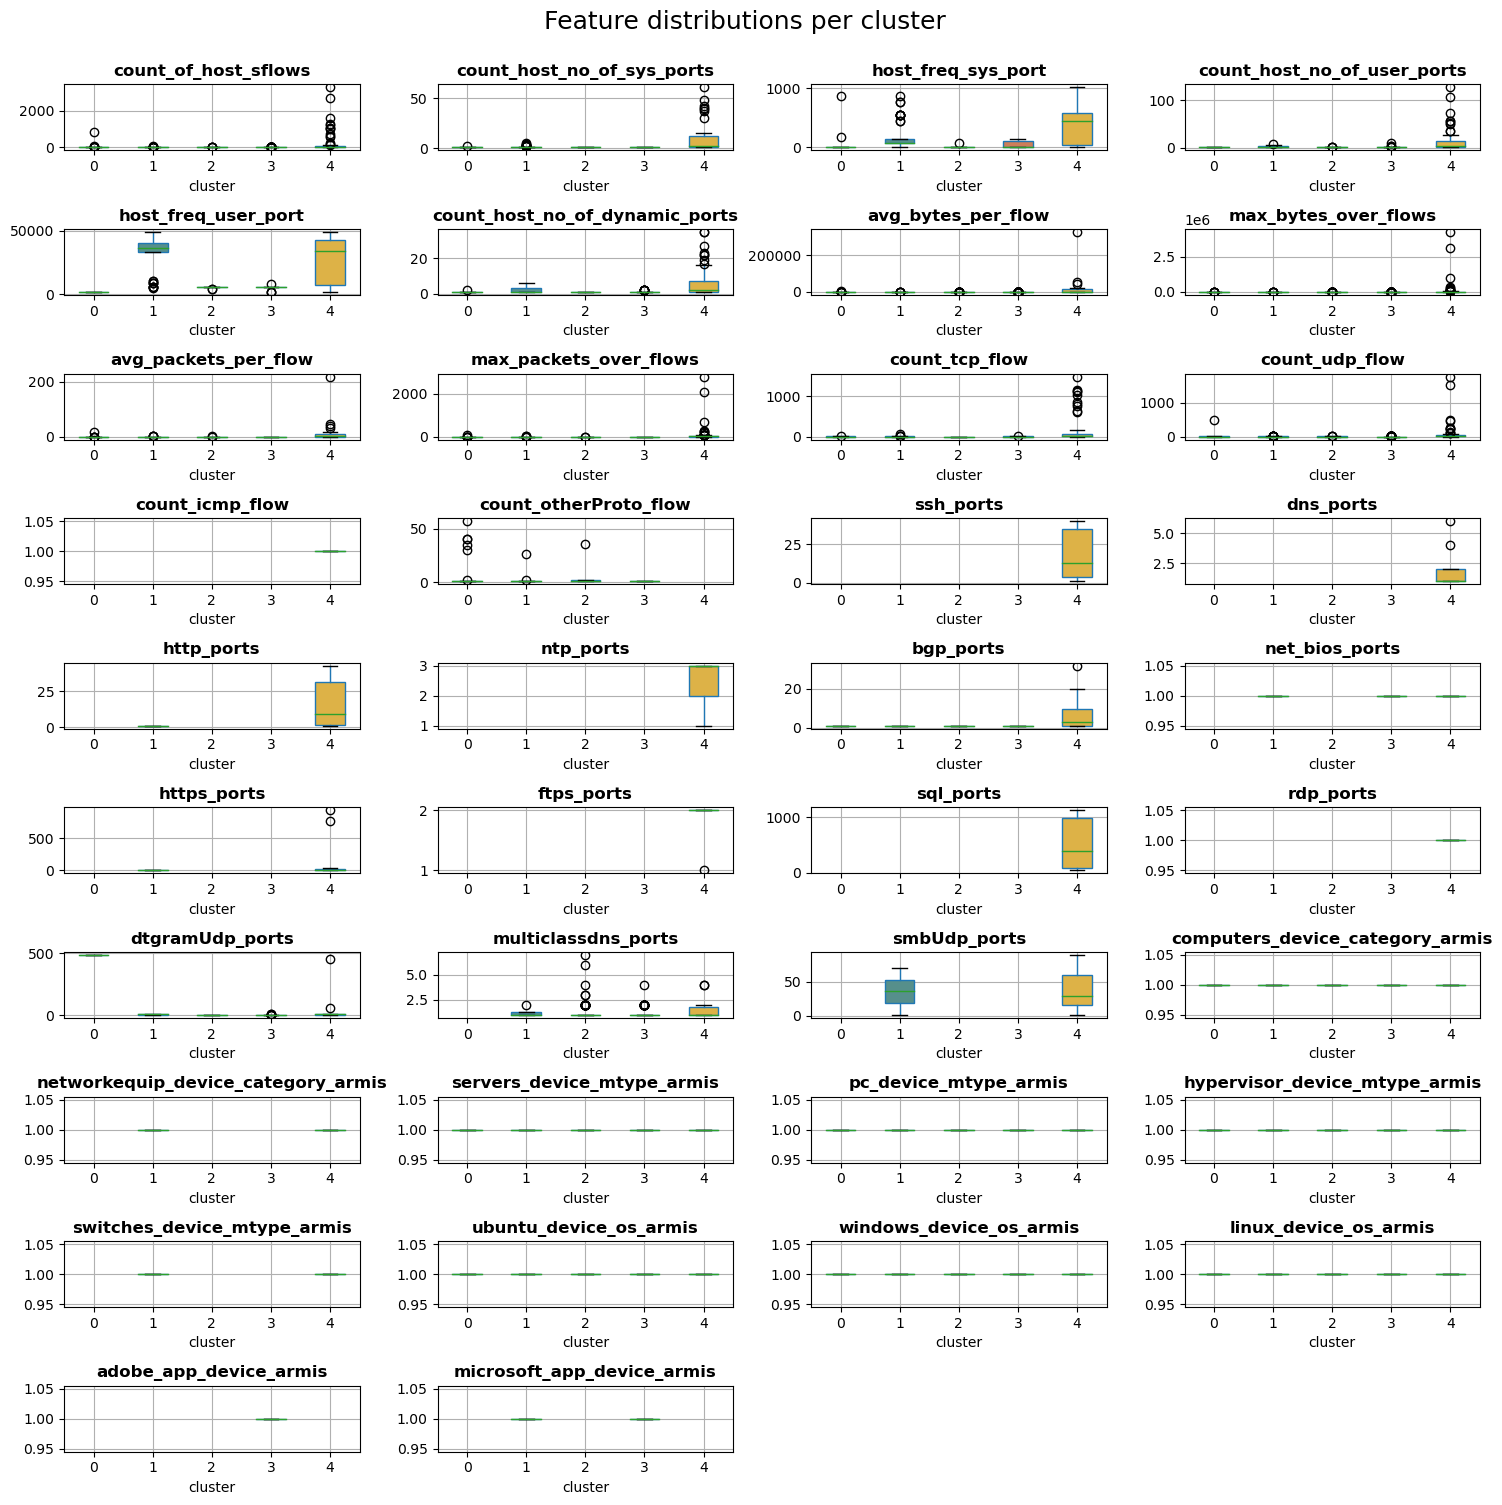

                                   0
cluster category                    
0       Computers          16.000000
1       Computers          31.736527
        Network Equipment   1.796407
2       Computers          52.150538
3       Computers          62.790698
4       Computers          22.580645
        Network Equipment   8.870968
                                    0
cluster mtype                        
0       Hypervisor           0.800000
        Personal Computers   0.800000
        Servers             14.400000
1       Hypervisor           1.796407
        Personal Computers   2.994012
        Servers             26.946108
        Switches             1.796407
2       Hypervisor           1.612903
        Personal Computers   2.688172
        Servers             41.397849
3       Hypervisor           1.661130
        Personal Computers   4.983389
        Servers             54.152824
4       Hypervisor           2.419355
        Personal Computers   4.838710
        Servers      

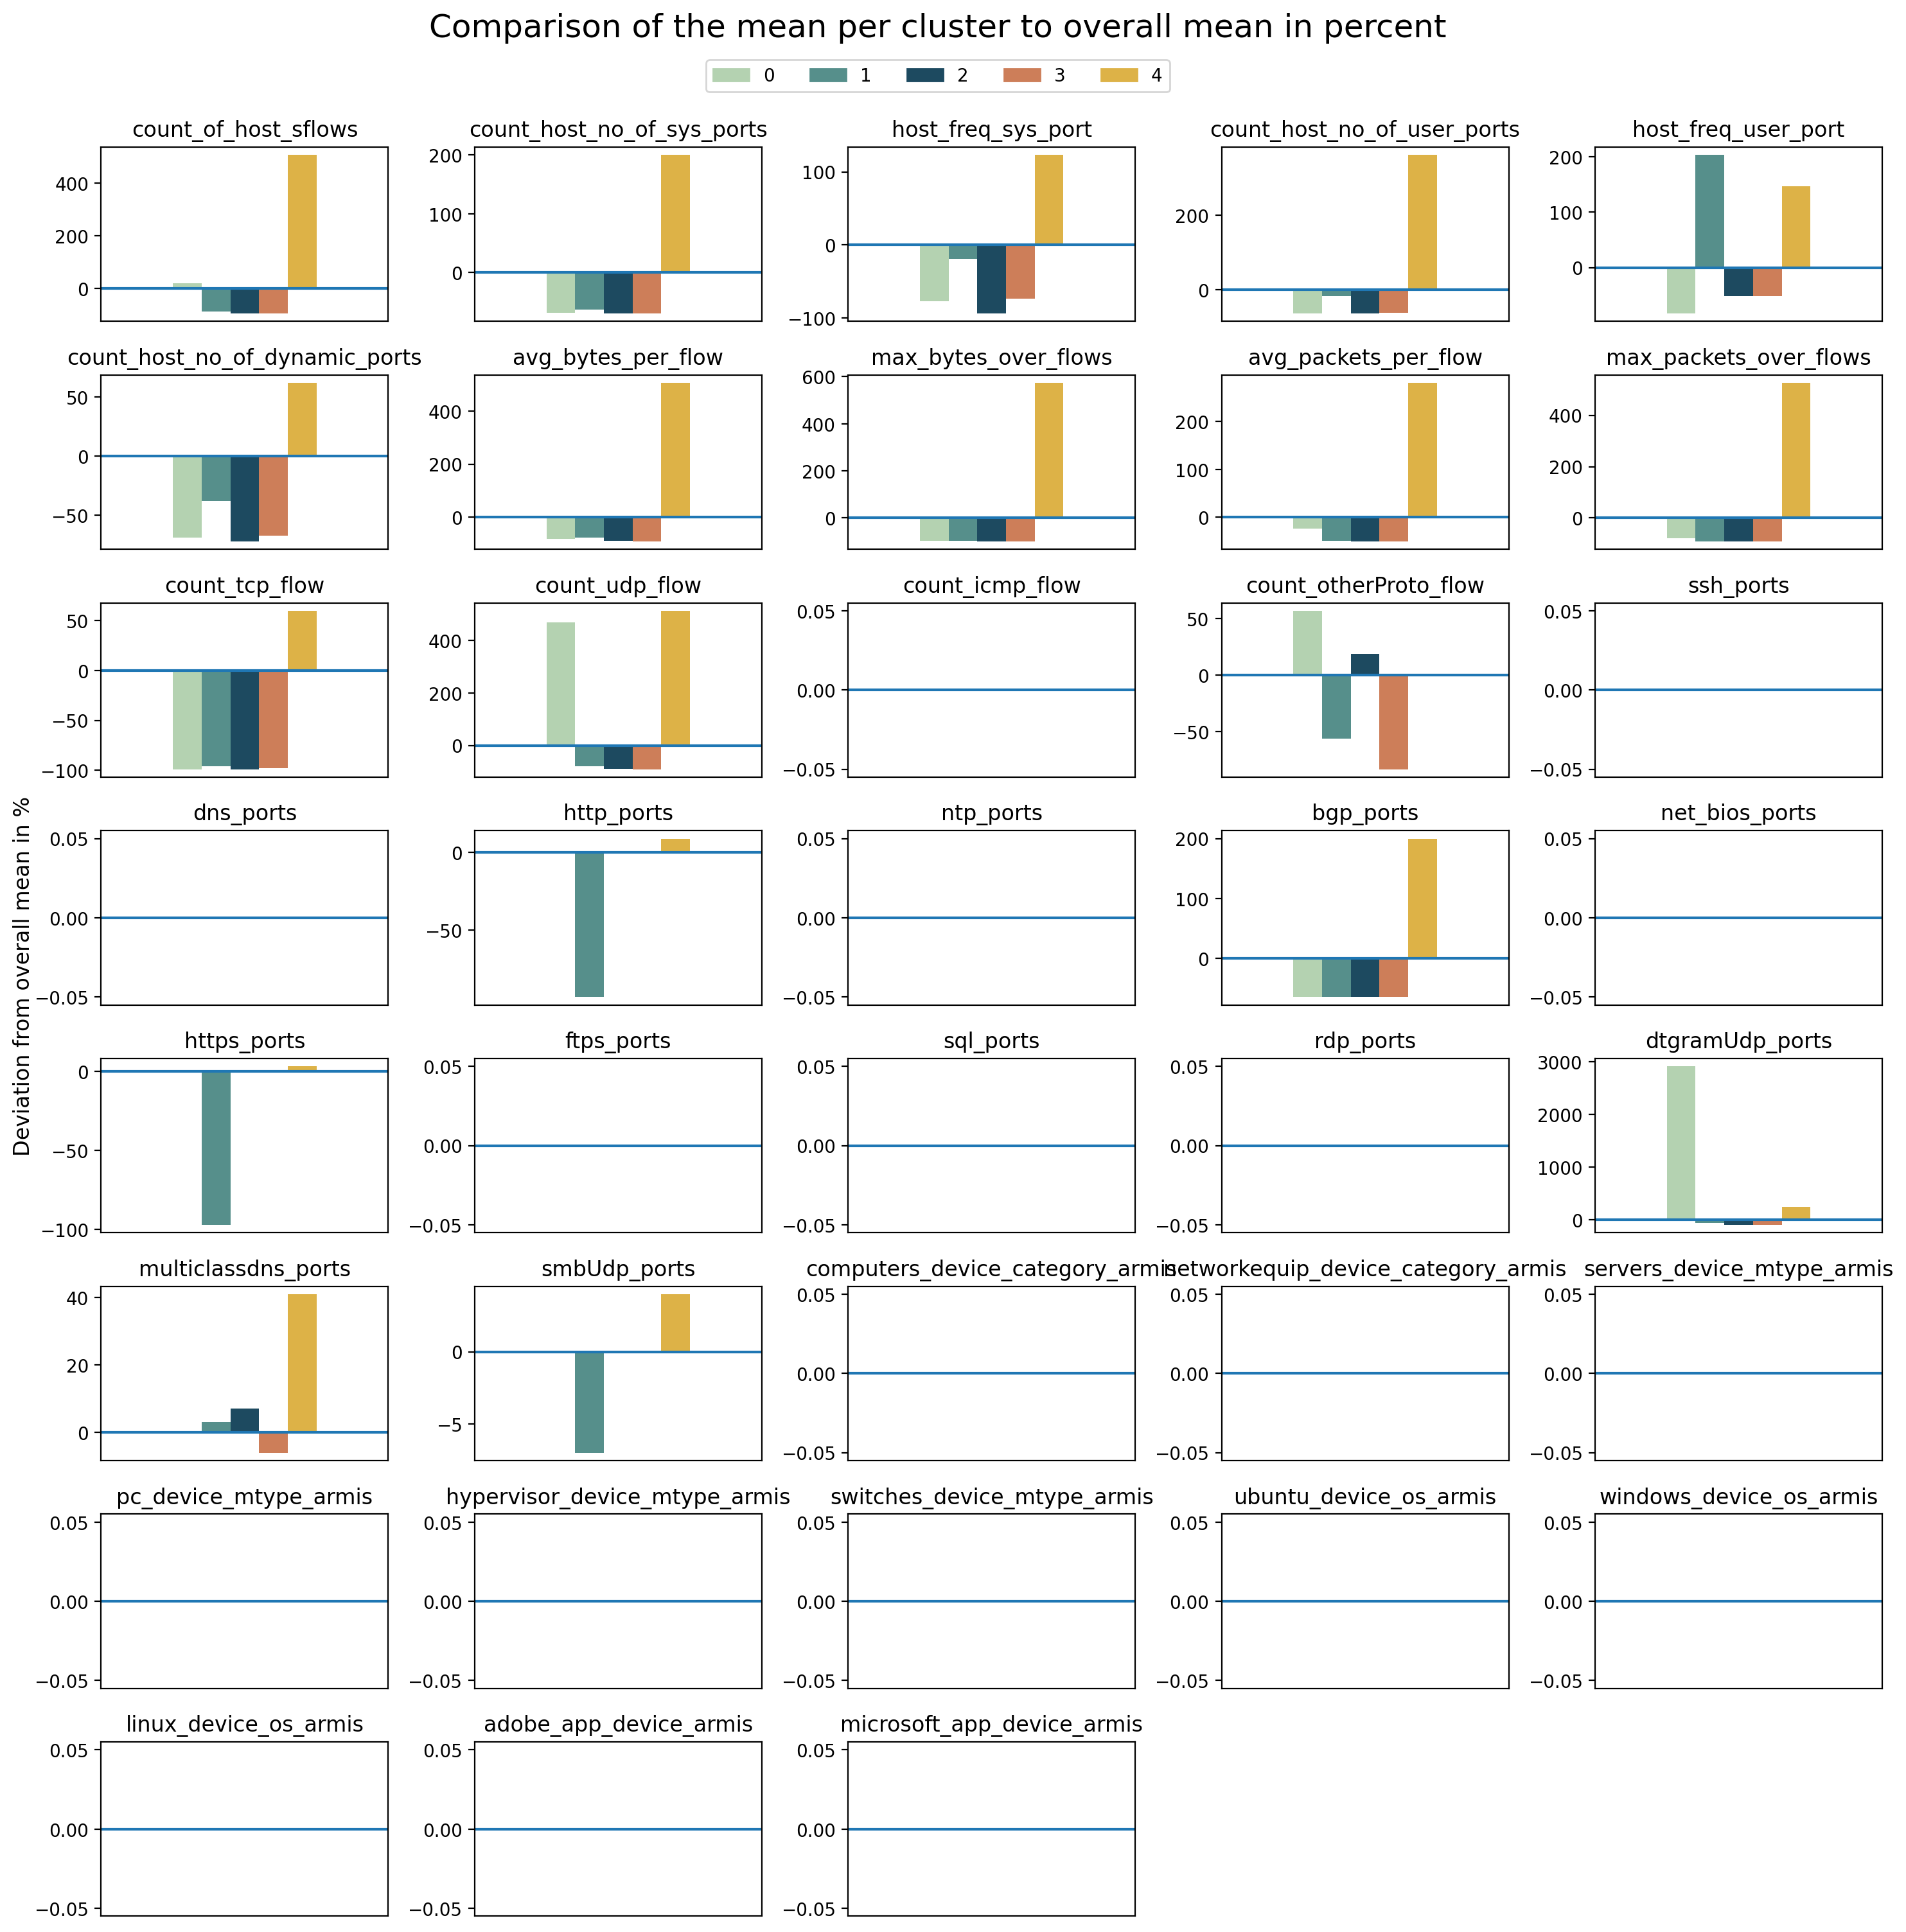

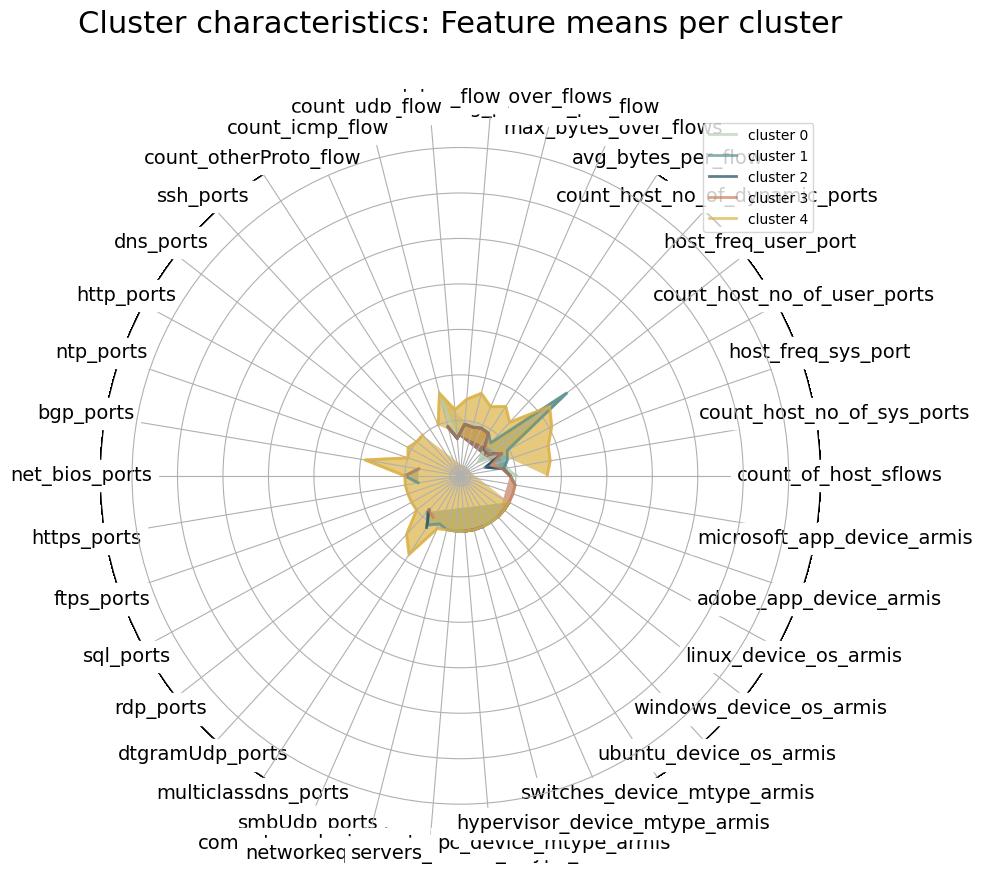

========== alpha=10, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
5.625110626220703
loss: 4.9960
loss: 4.7382
loss: 4.6158
loss: 4.7572
loss: 4.7306
loss: 4.6596
loss: 4.5242
loss: 4.3786
loss: 4.1593
loss: 4.4360
loss: 4.1557
loss: 4.1935
loss: 4.1826
loss: 4.0414
loss: 3.8850
loss: 4.0924
loss: 4.0644
loss: 3.8623
loss: 3.7021
loss: 3.7249
loss: 3.9192
loss: 3.8743
loss: 3.7747
loss: 3.6488
loss: 3.4770
loss: 3.3920
loss: 3.2517
loss: 3.5400
loss: 3.5116
loss: 3.3410
loss: 3.3517
loss: 3.2205
loss: 3.1264
loss: 3.1122
loss: 3.0809
loss: 3.0035
loss: 3.2697
loss: 3.1521
loss: 3.2172
loss: 2.9295
loss: 3.1363
loss: 3.2047
loss: 3.0046
loss: 2.9432
loss: 2.9106
loss: 2.8331
loss: 2.9357
loss: 3.3768
loss: 2.9825


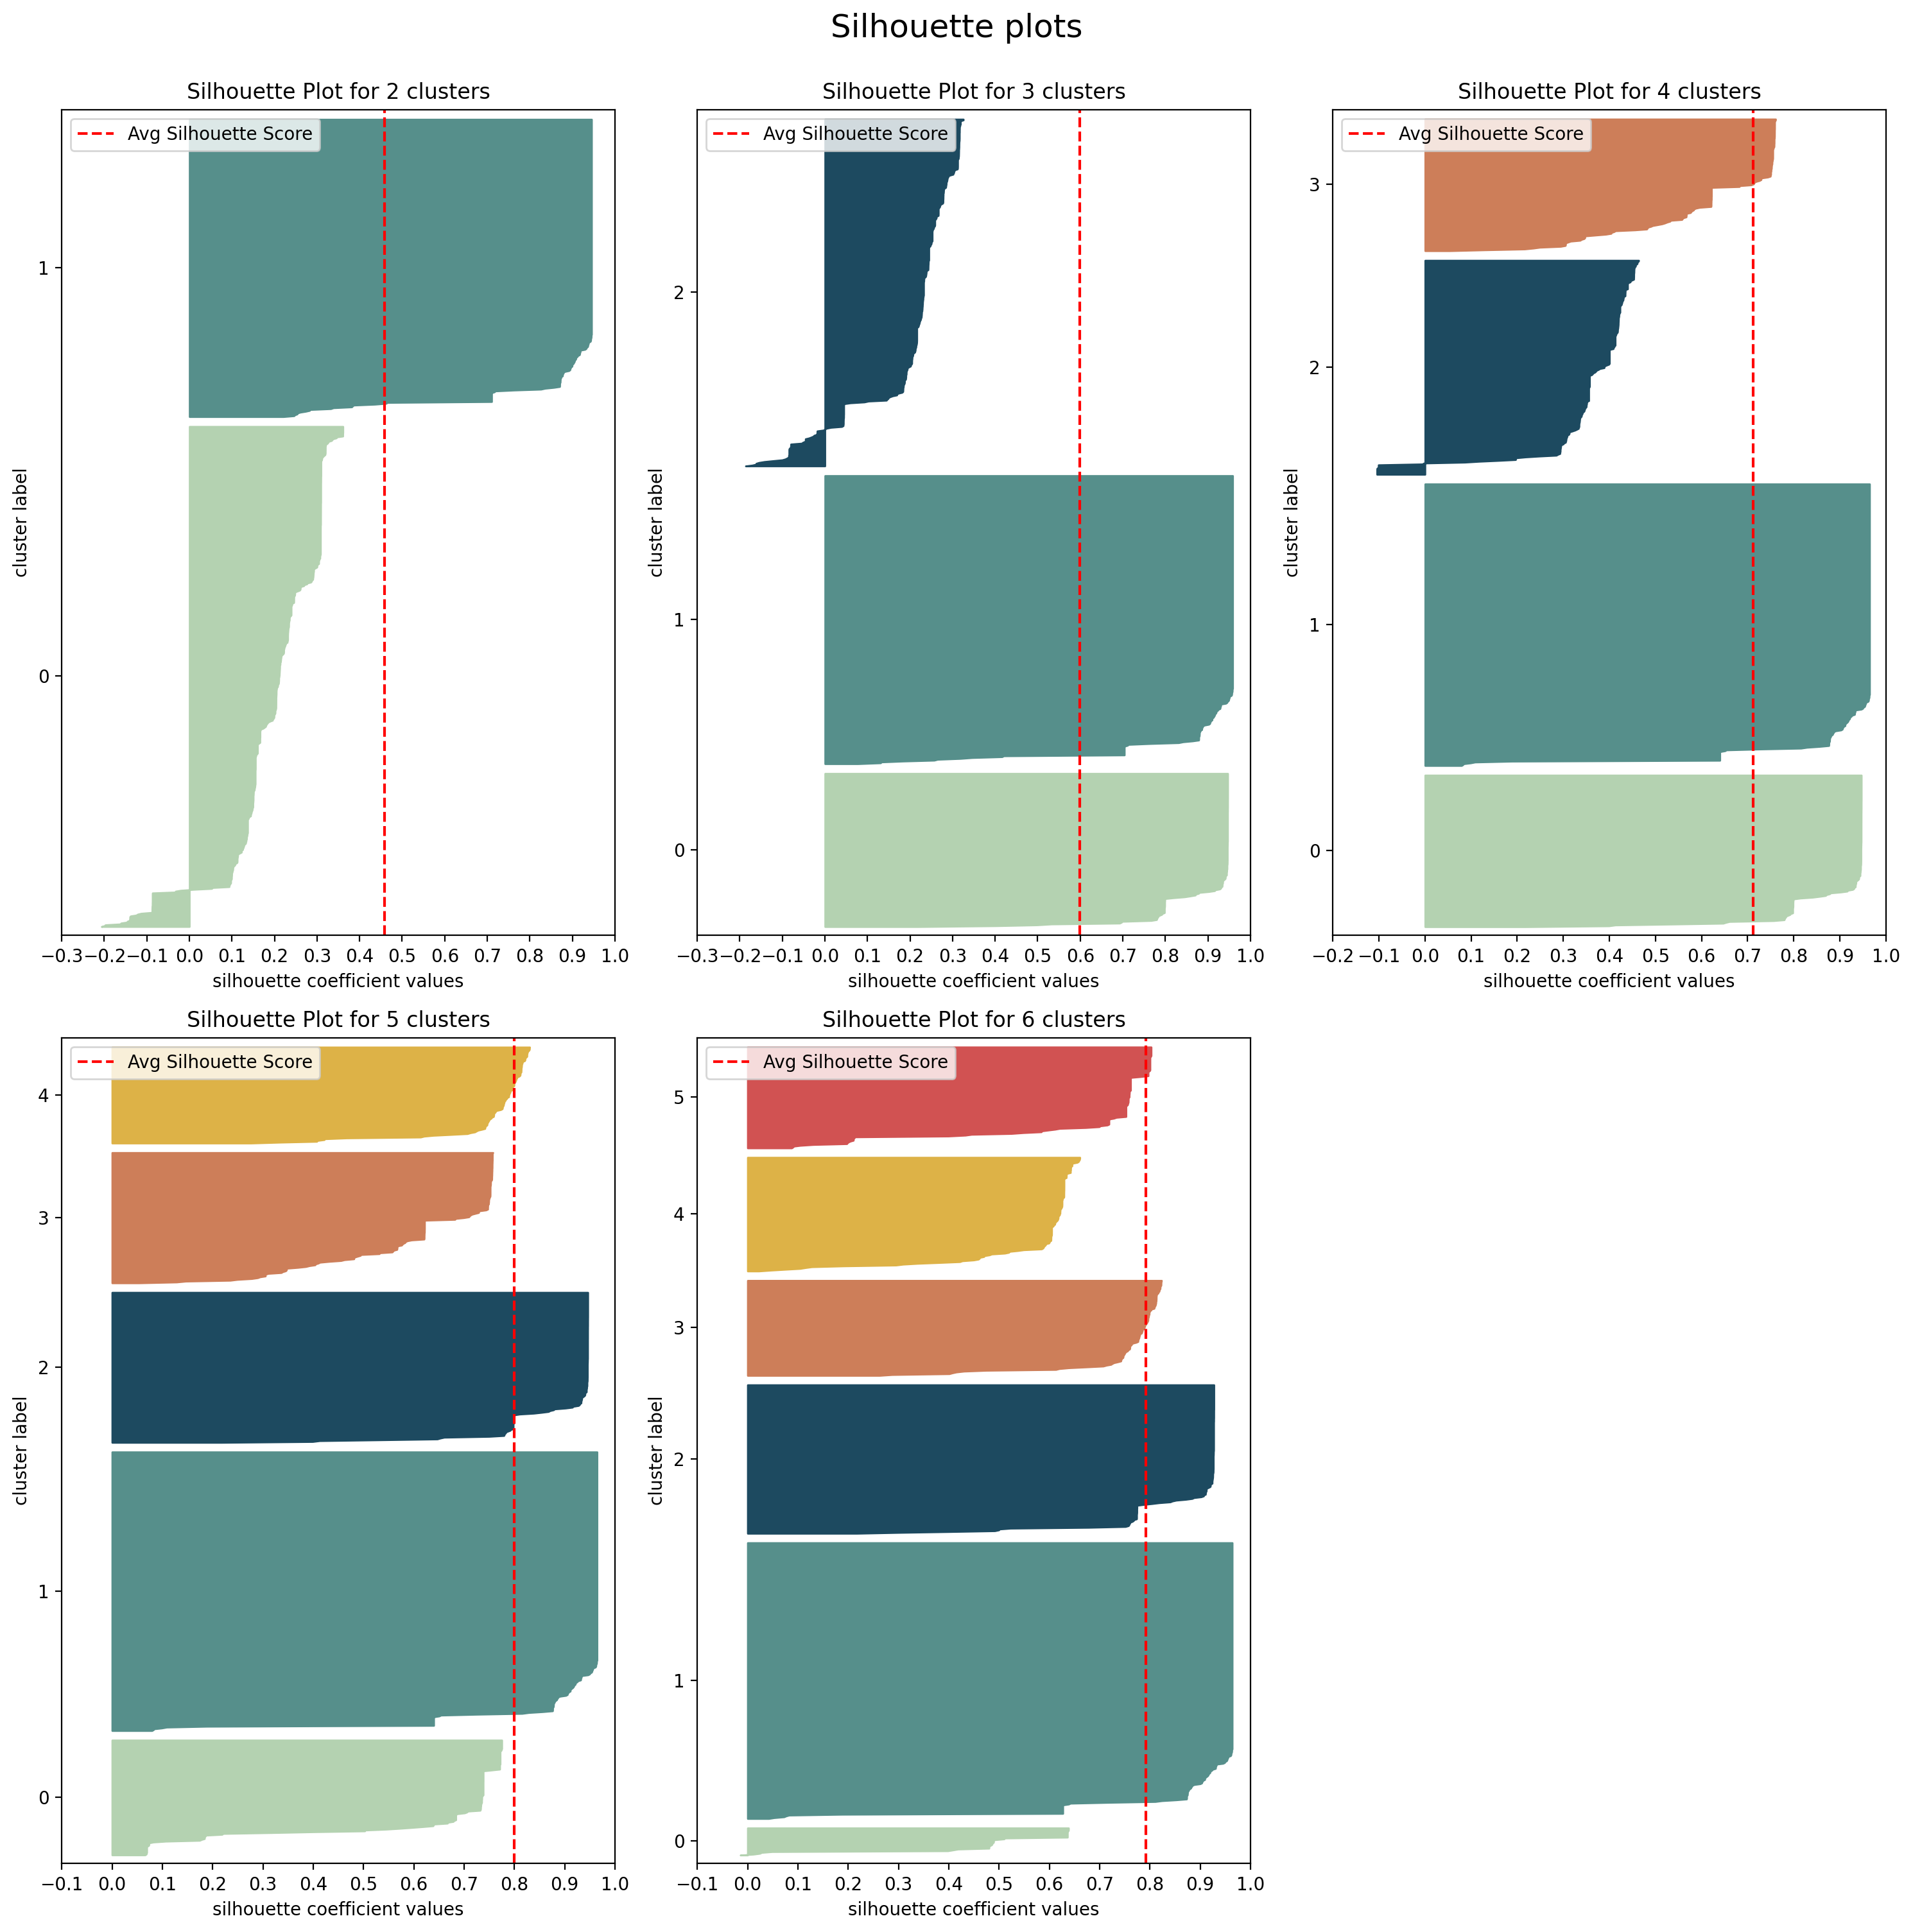

loss: 3.4185
========== reg=10 ==========


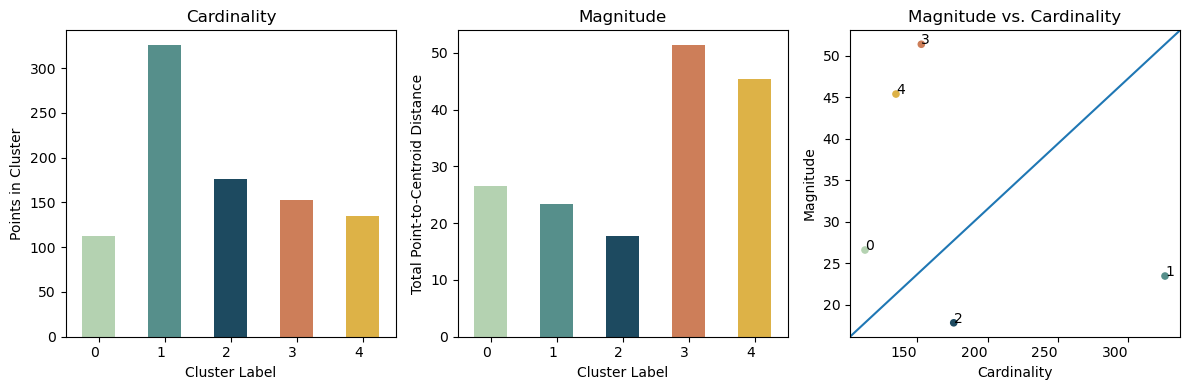

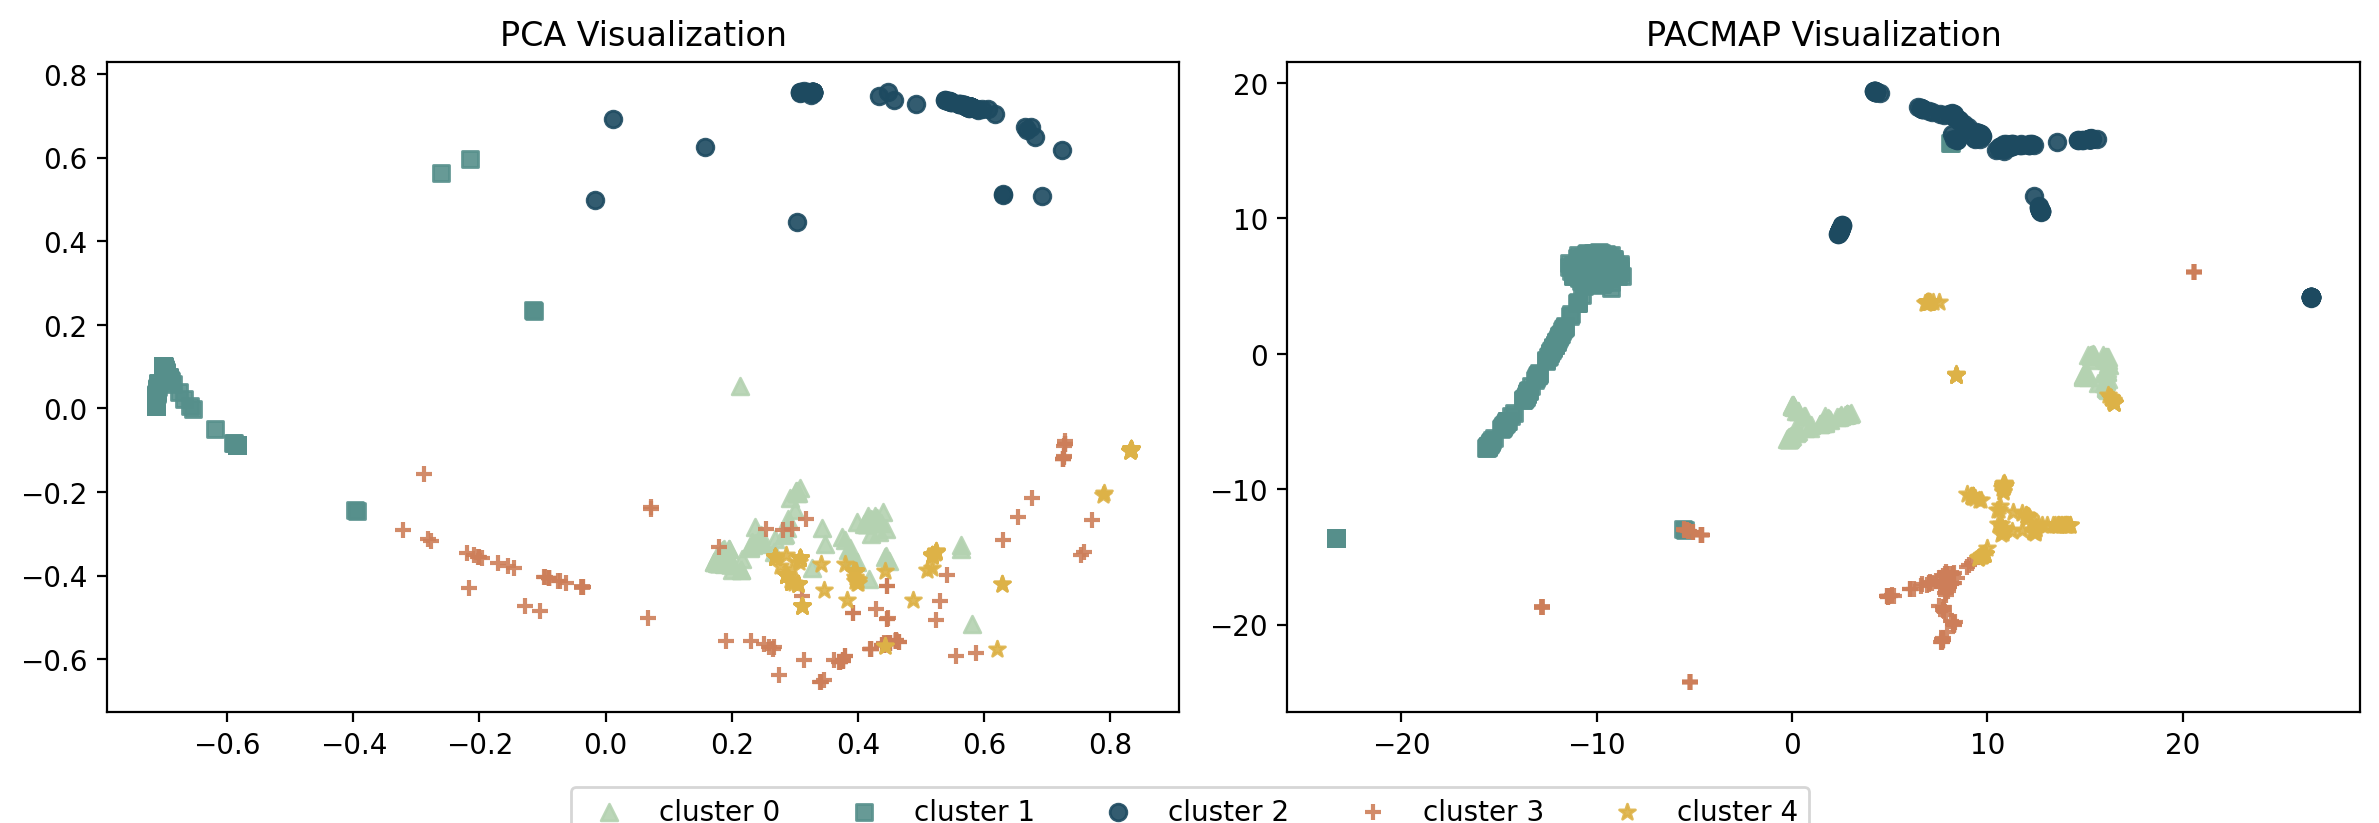

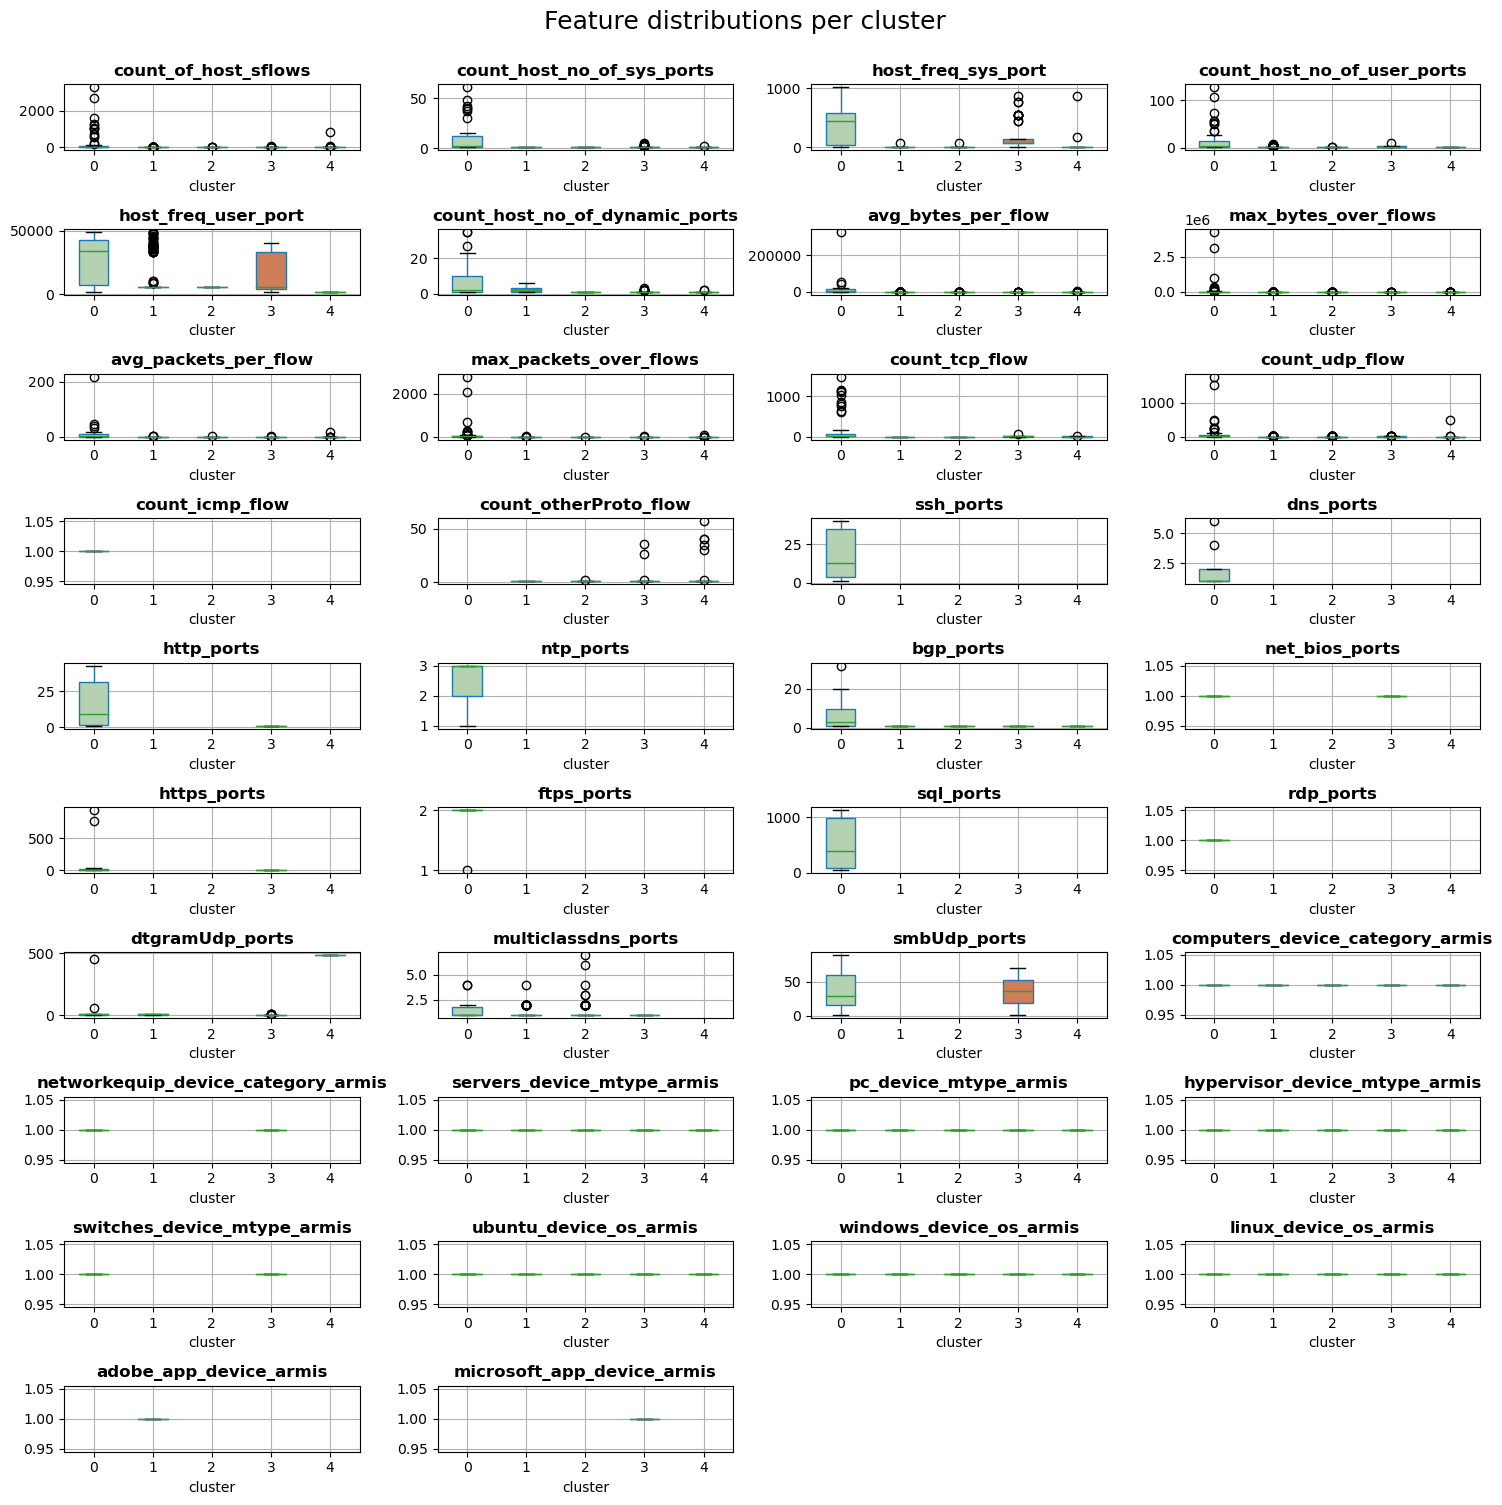

                                   0
cluster category                    
0       Computers          15.929204
        Network Equipment   9.734513
1       Computers          58.895706
2       Computers          53.977273
3       Computers          33.986928
        Network Equipment   1.960784
4       Computers          22.222222
                                    0
cluster mtype                        
0       Hypervisor           0.884956
        Personal Computers   2.654867
        Servers             12.389381
        Switches             7.964602
1       Hypervisor           1.533742
        Personal Computers   3.987730
        Servers             51.533742
2       Hypervisor           1.704545
        Personal Computers   2.840909
        Servers             42.613636
3       Hypervisor           1.960784
        Personal Computers   4.575163
        Servers             27.450980
        Switches             1.960784
4       Hypervisor           2.222222
        Personal Comp

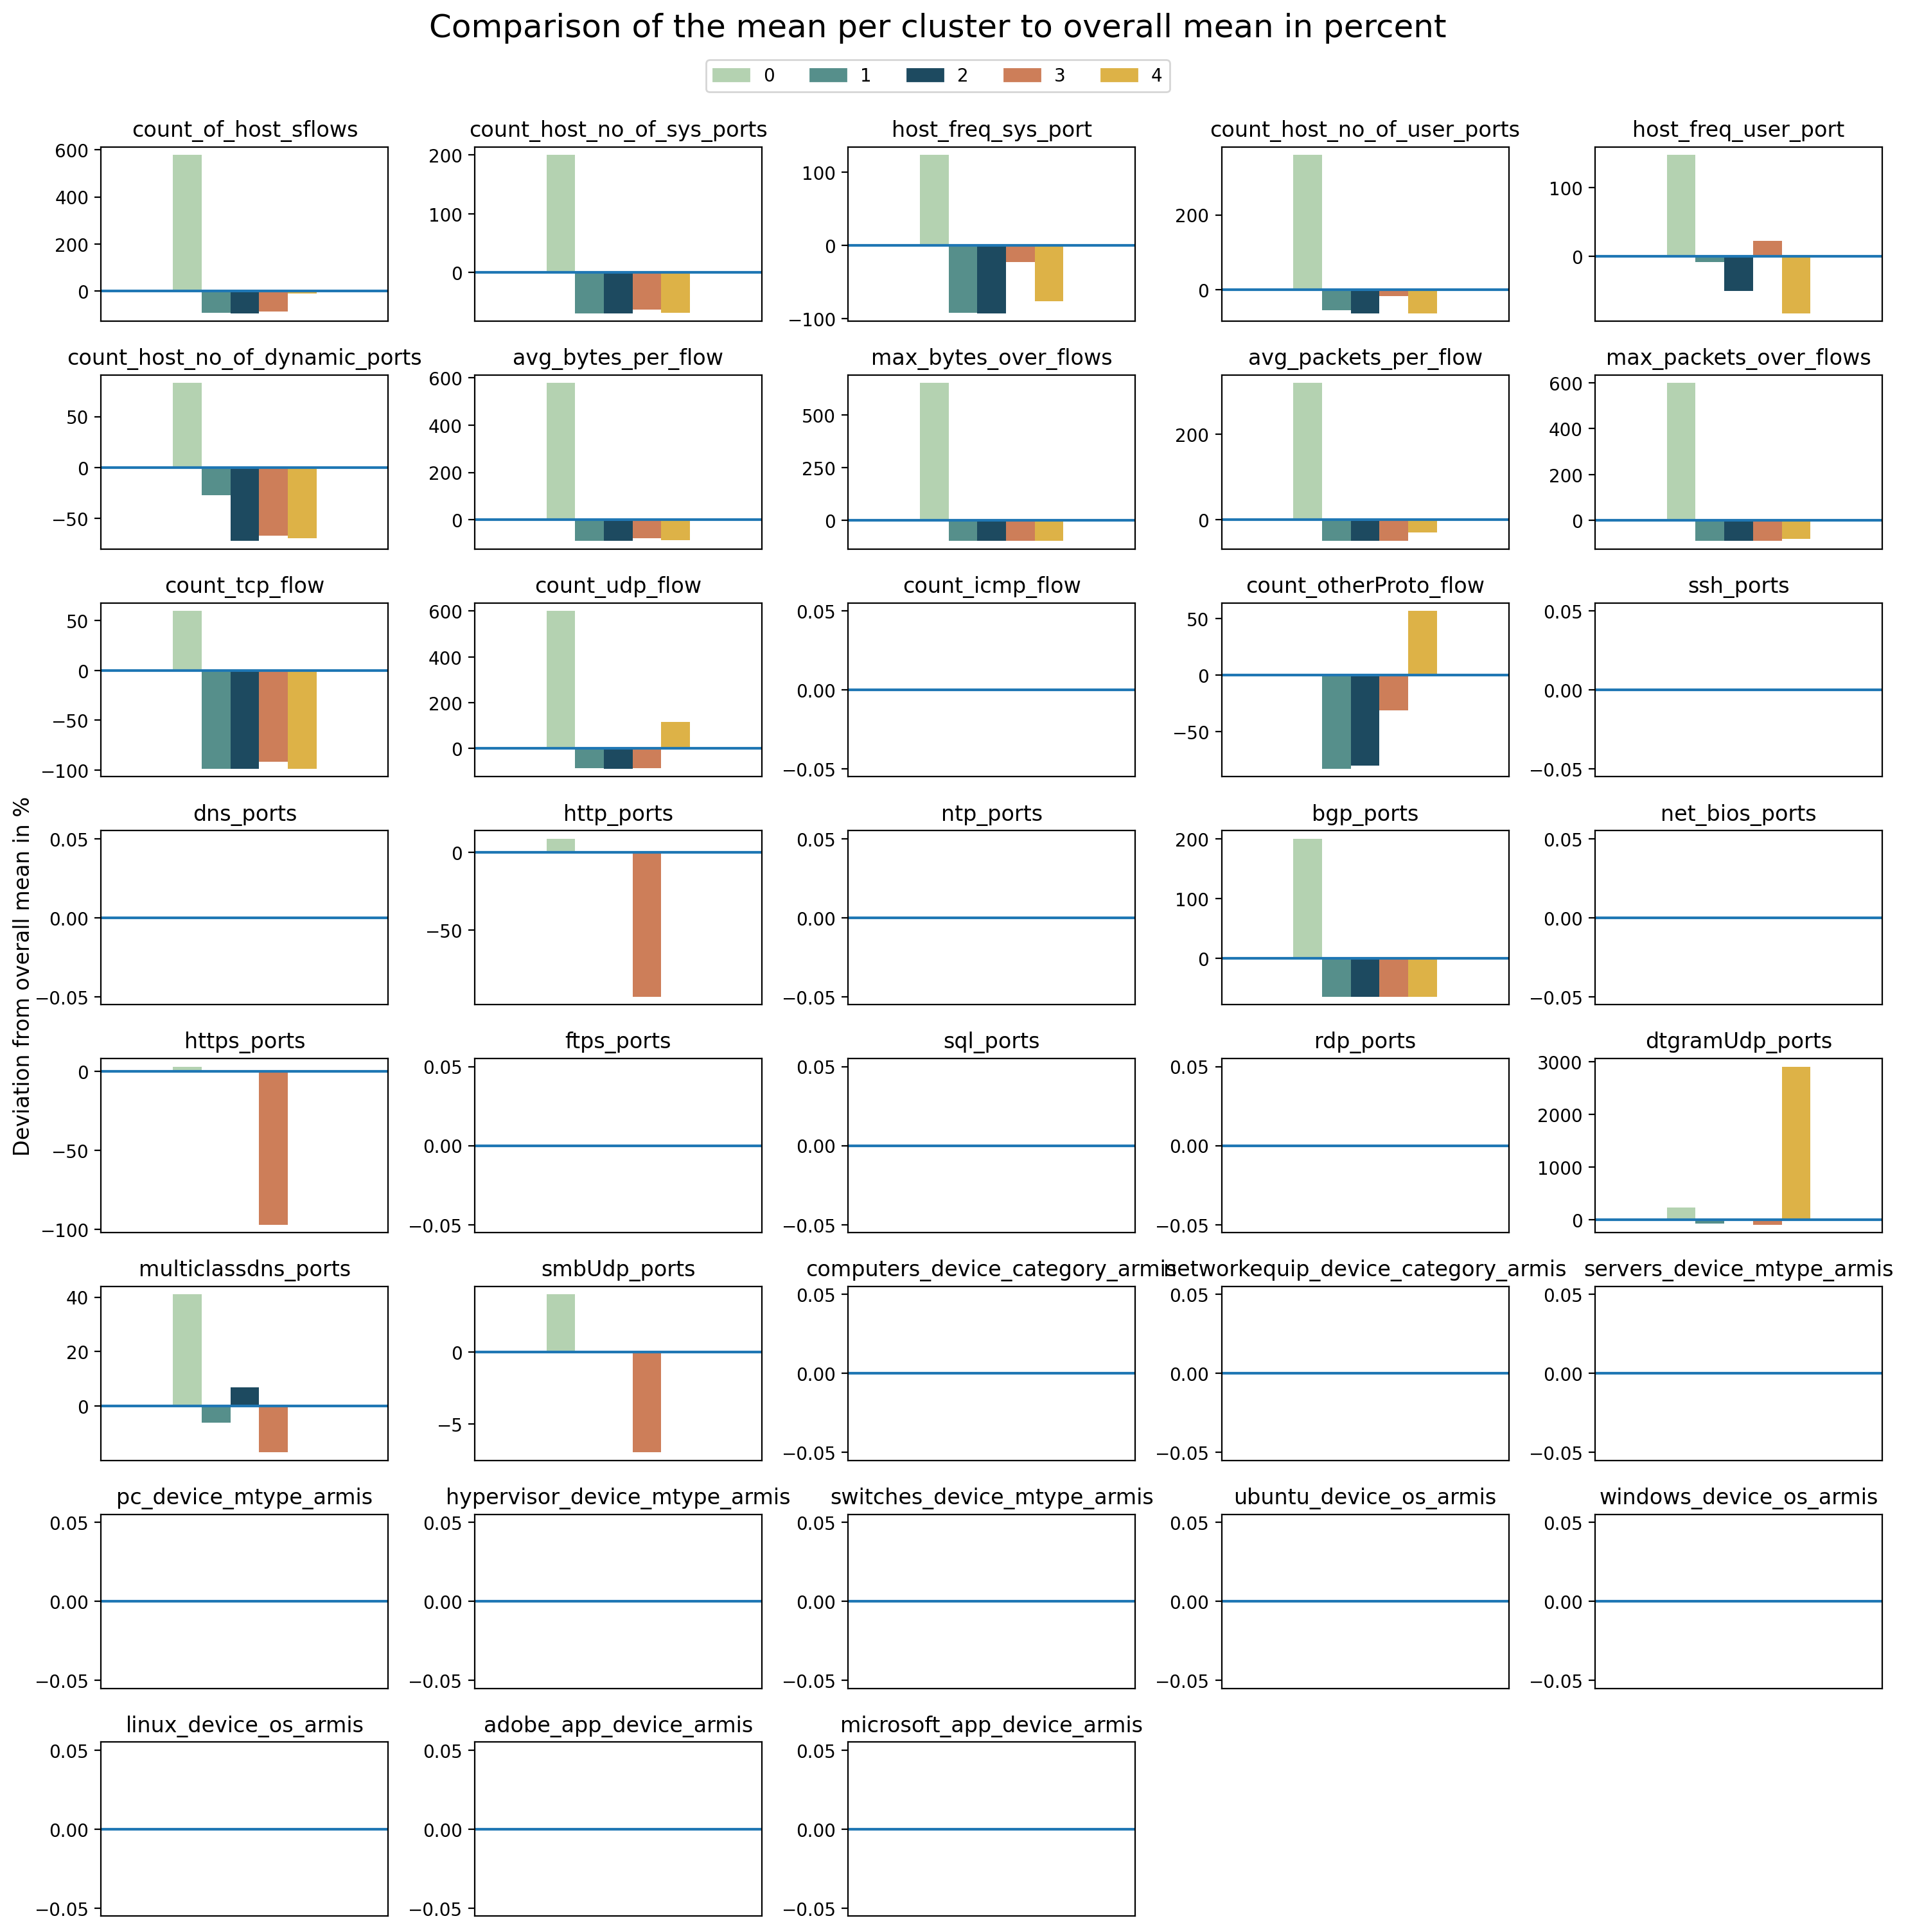

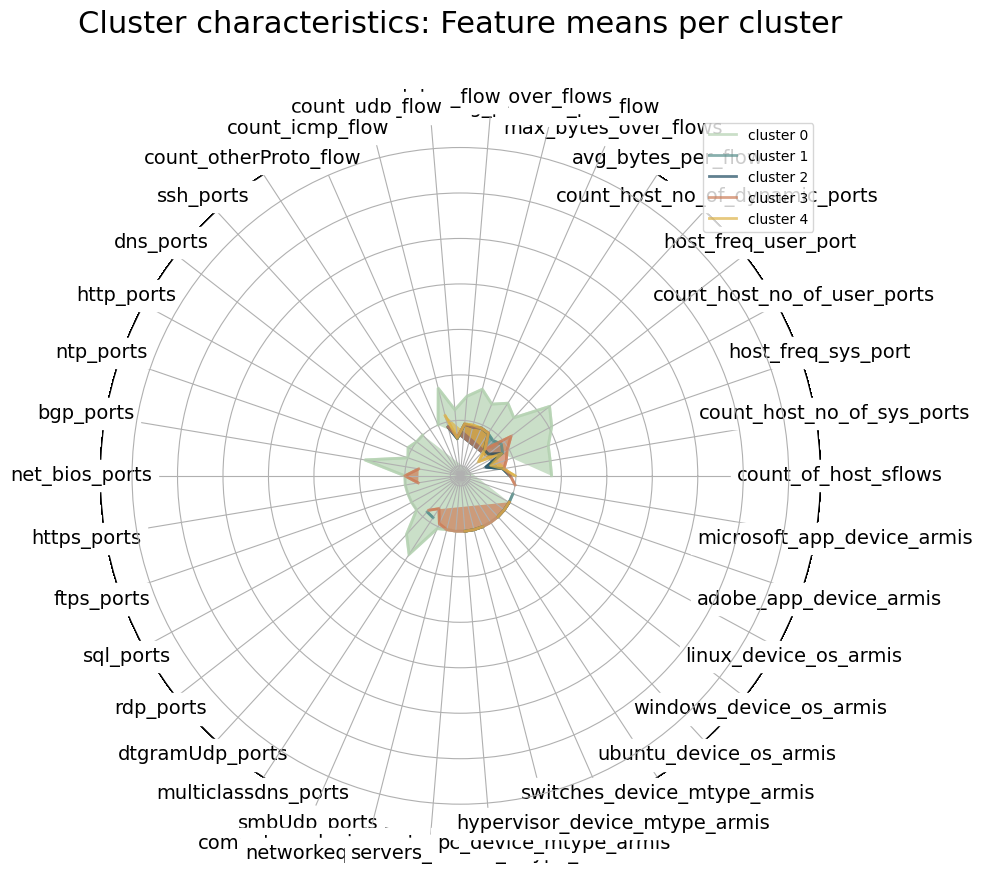

========== alpha=100, reg=0.001 ==========
Start pretraining (totally 10 iterations) ......
6.292915344238281
loss: 5.8706
loss: 5.5971
loss: 5.3550
loss: 5.0984
loss: 4.7863
loss: 4.5011
loss: 4.5736
loss: 4.3554
loss: 4.2407
loss: 4.1999
loss: 4.0766
loss: 4.3300
loss: 4.4376
loss: 4.4006
loss: 4.3381
loss: 4.3597
loss: 4.3349
loss: 4.2766
loss: 4.1934
loss: 4.1423
loss: 4.0701
loss: 3.9663
loss: 3.8329
loss: 3.8288
loss: 3.8096
loss: 3.6885
loss: 3.5478
loss: 3.4566
loss: 3.4824
loss: 3.4231
loss: 3.6476
loss: 3.6550
loss: 3.5055
loss: 3.4185
loss: 3.3145
loss: 3.3509
loss: 3.2970
loss: 3.5037
loss: 3.3387
loss: 3.3282
loss: 3.6924
loss: 3.5806
loss: 3.4549
loss: 3.4097
loss: 3.2748
loss: 3.2136
loss: 3.1475
loss: 3.0701
loss: 3.1494


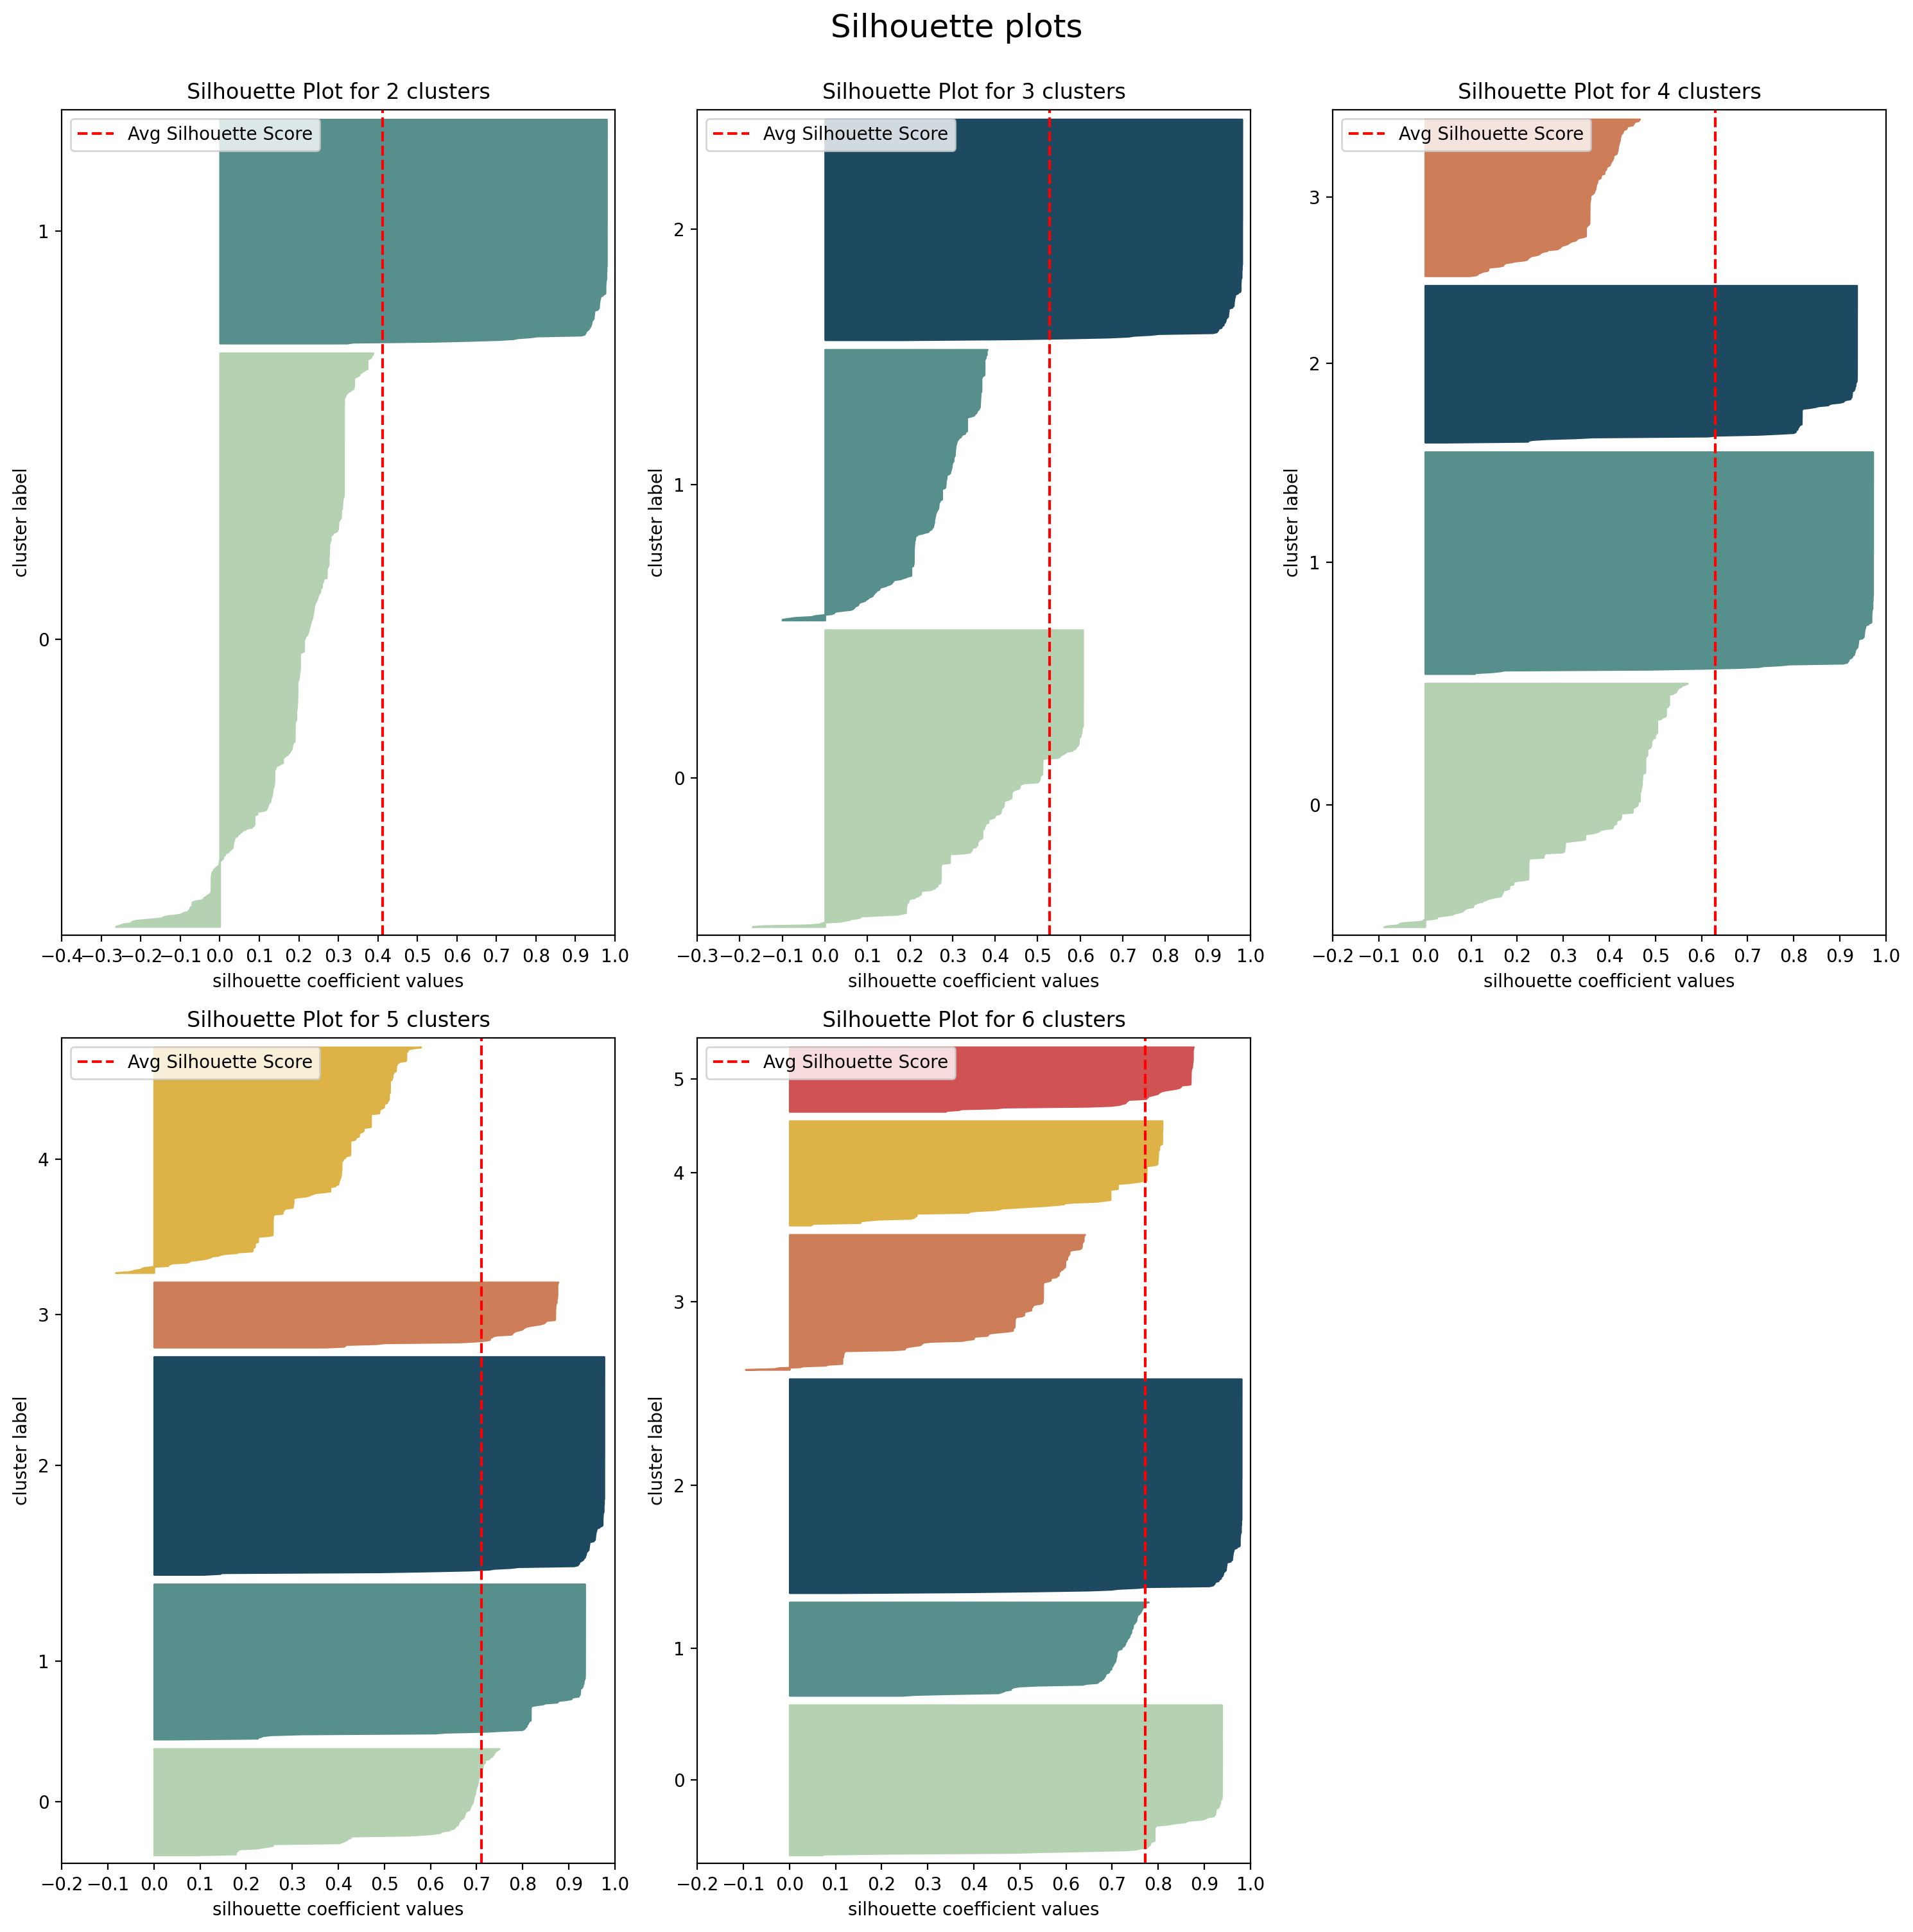

loss: 3.2451
========== reg=100 ==========


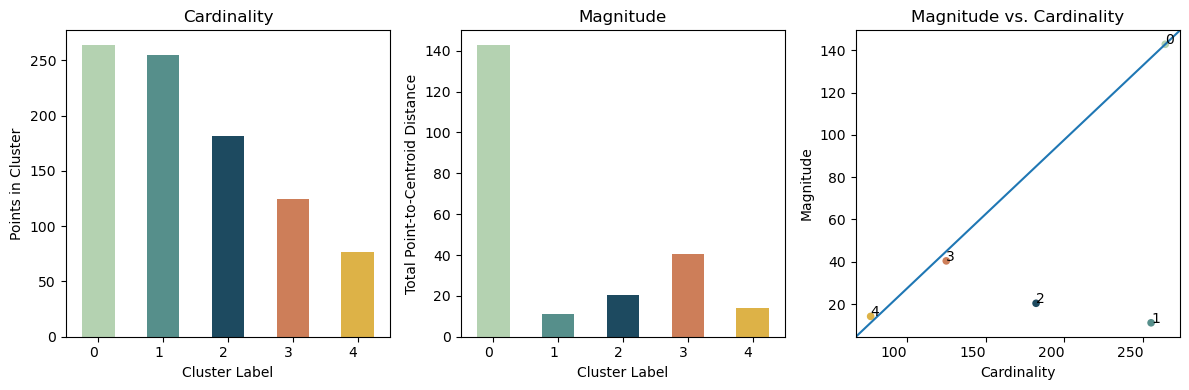

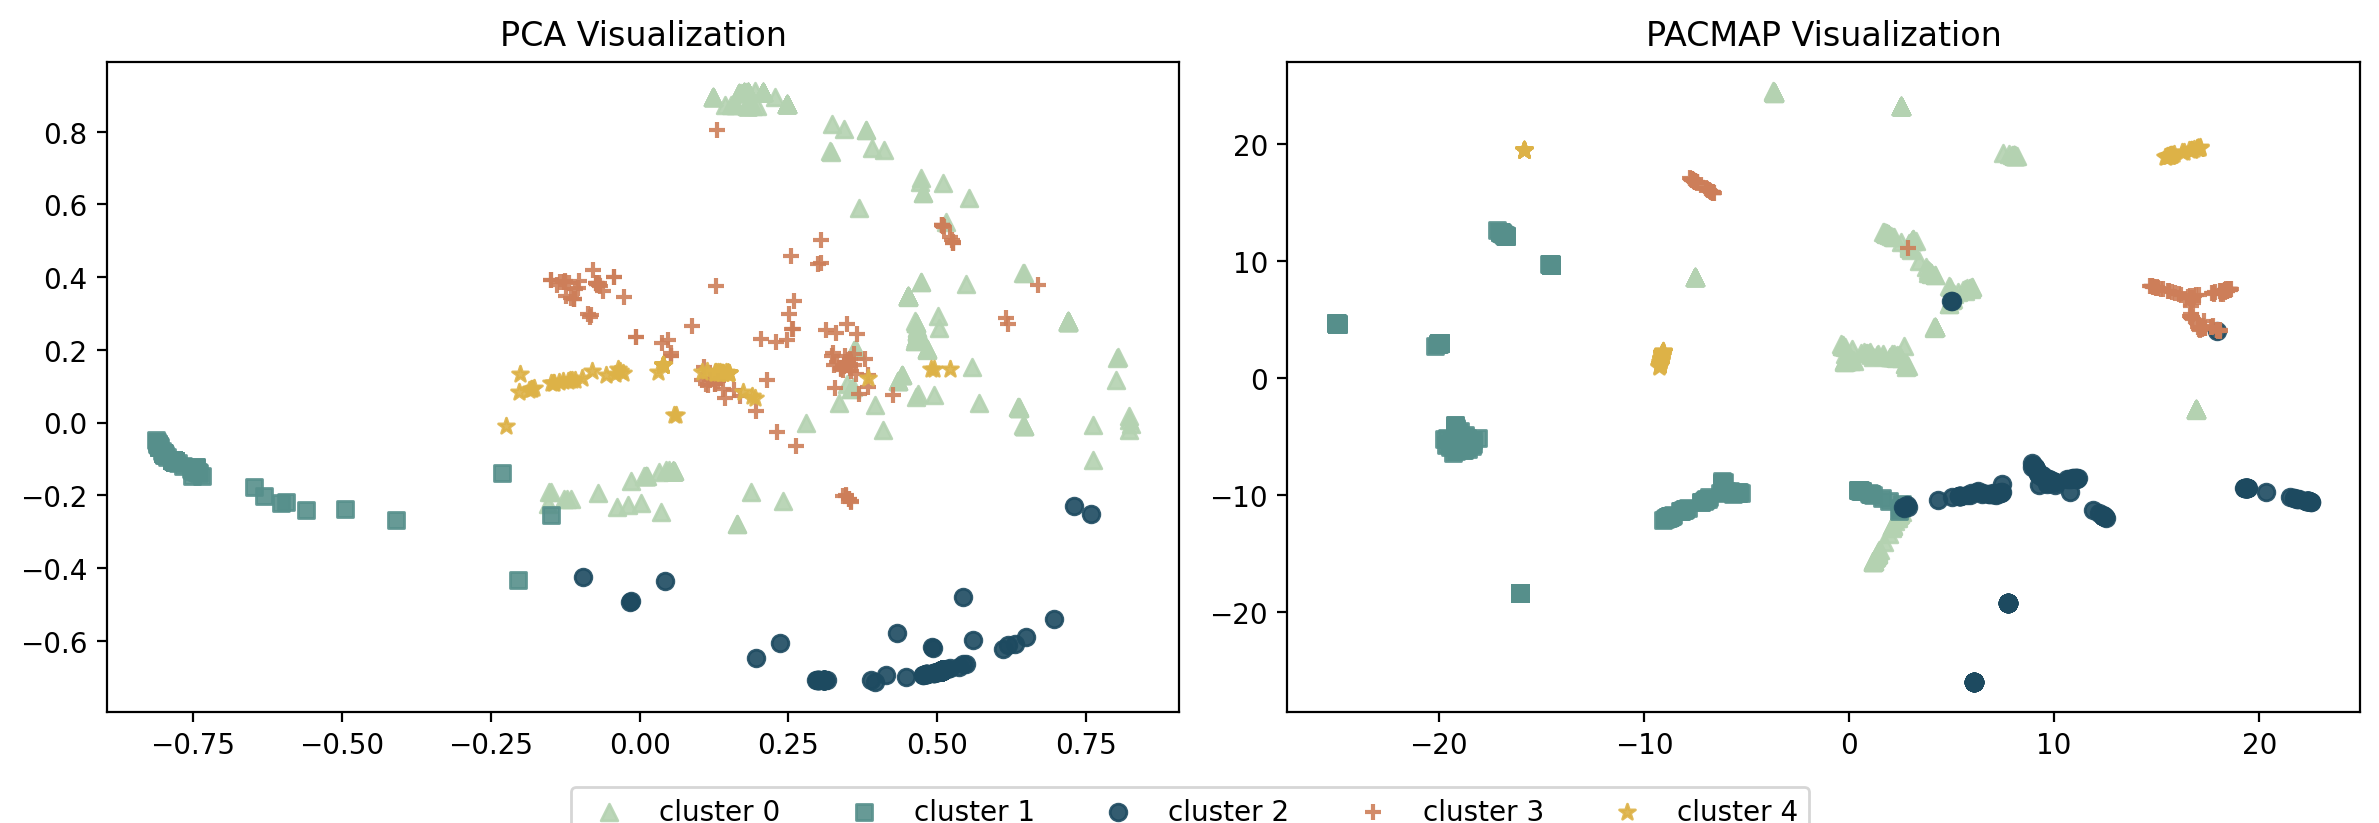

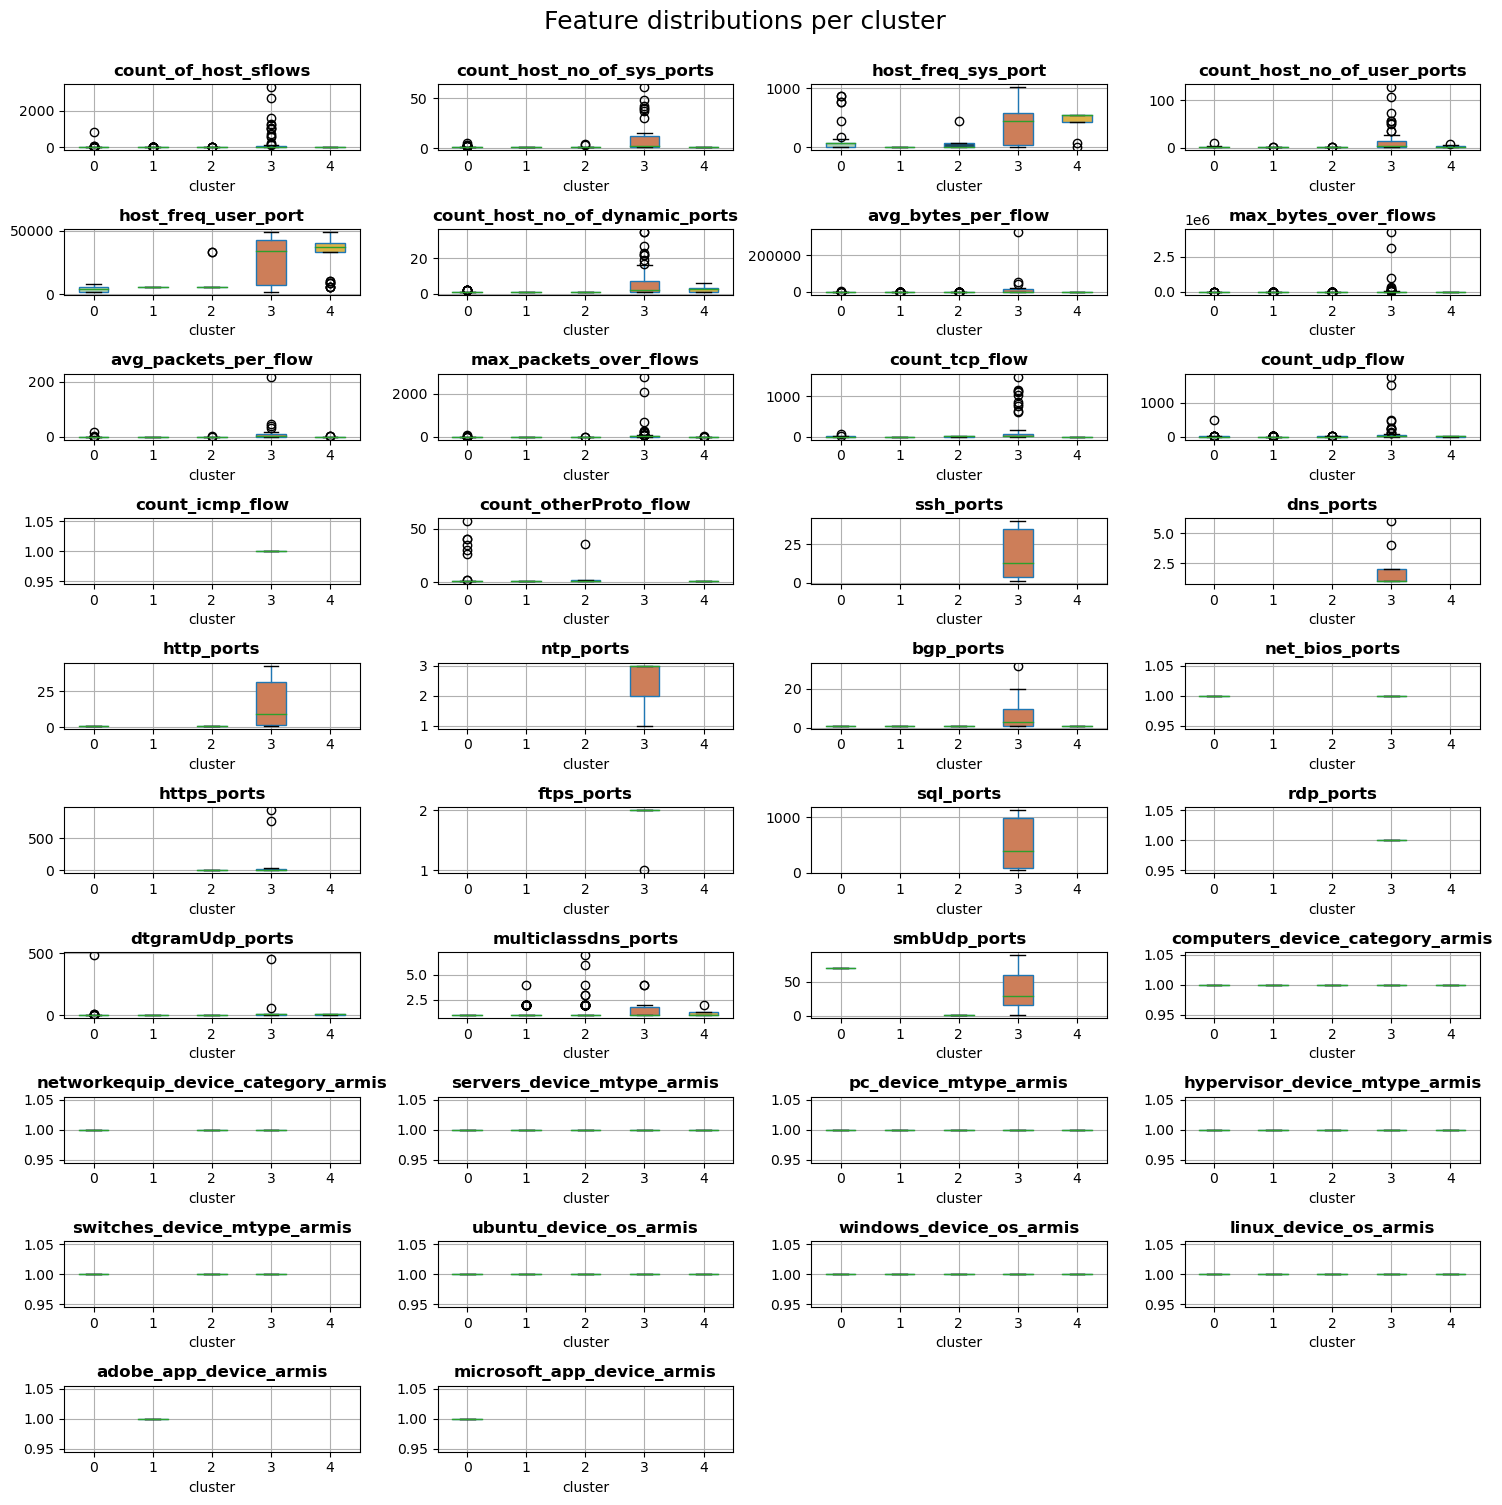

                                   0
cluster category                    
0       Computers          26.136364
        Network Equipment   0.757576
1       Computers          66.274510
2       Computers          52.747253
        Network Equipment   0.549451
3       Computers          22.400000
        Network Equipment   8.800000
4       Computers          32.467532
                                    0
cluster mtype                        
0       Hypervisor           1.515152
        Personal Computers   2.651515
        Servers             21.969697
        Switches             0.757576
1       Hypervisor           1.568627
        Personal Computers   3.921569
        Servers             58.431373
2       Hypervisor           1.648352
        Personal Computers   2.747253
        Servers             41.758242
        Switches             0.549451
3       Hypervisor           2.400000
        Personal Computers   4.800000
        Servers             15.200000
        Switches      

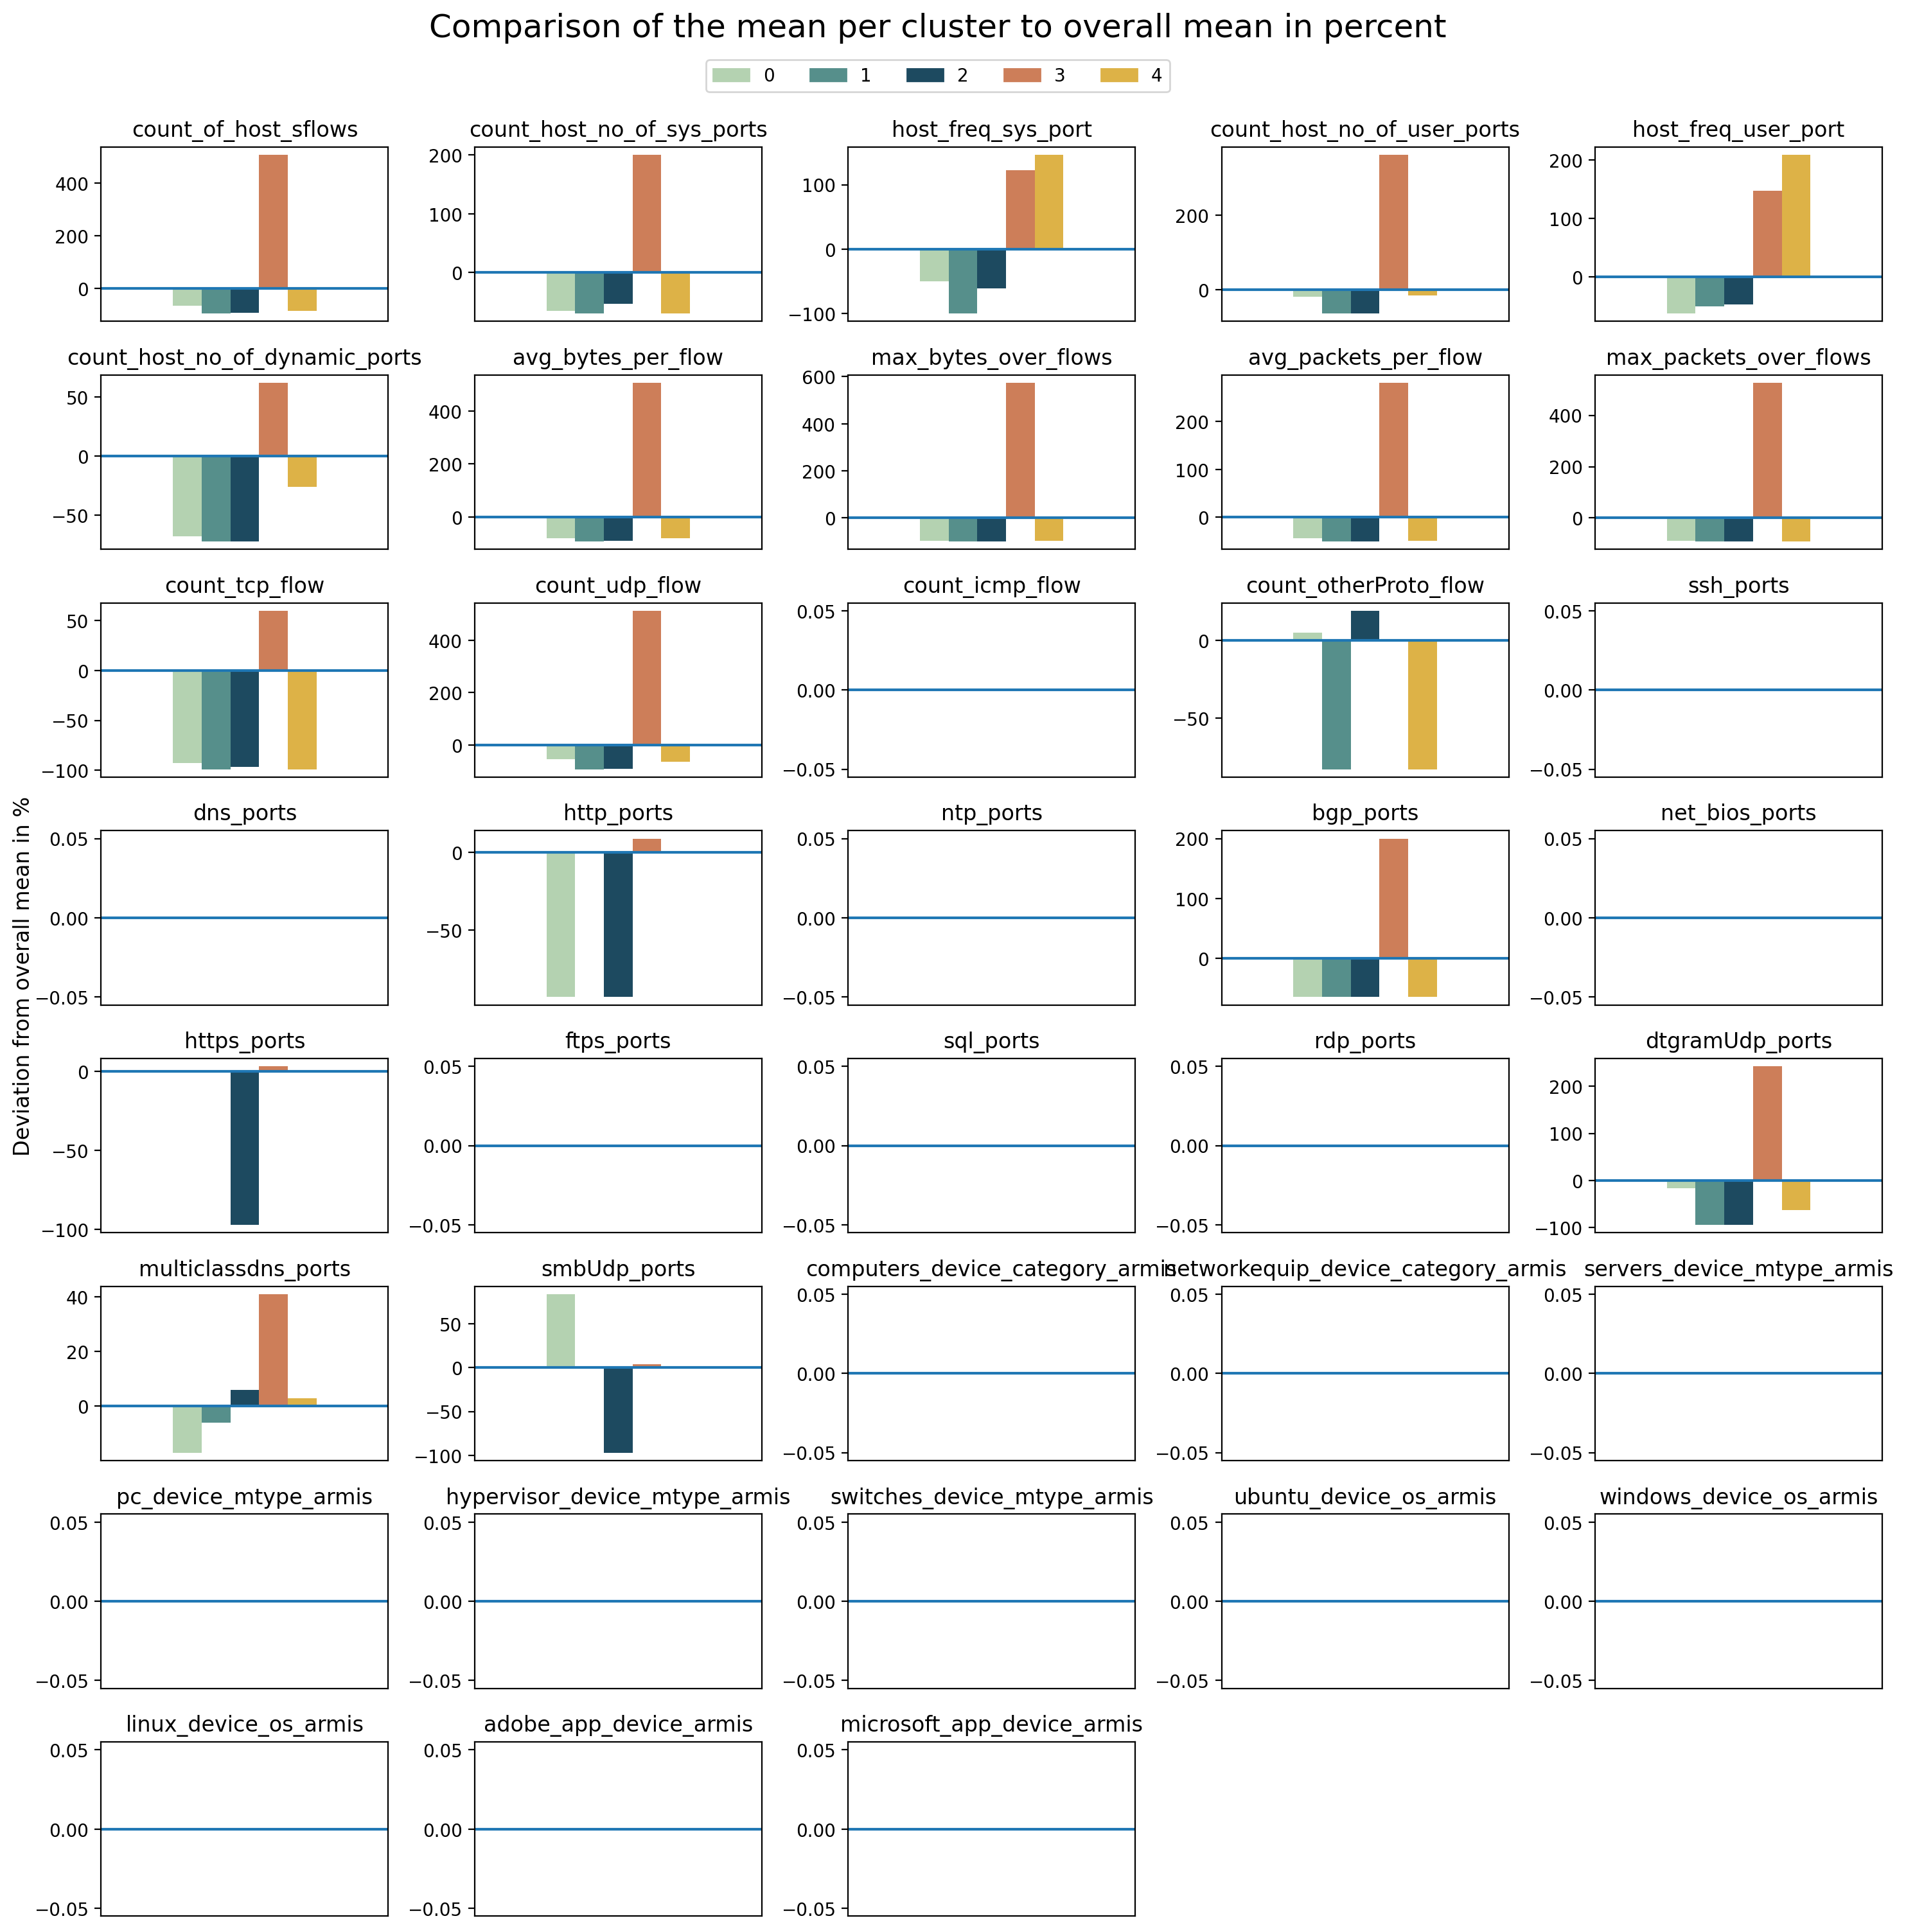

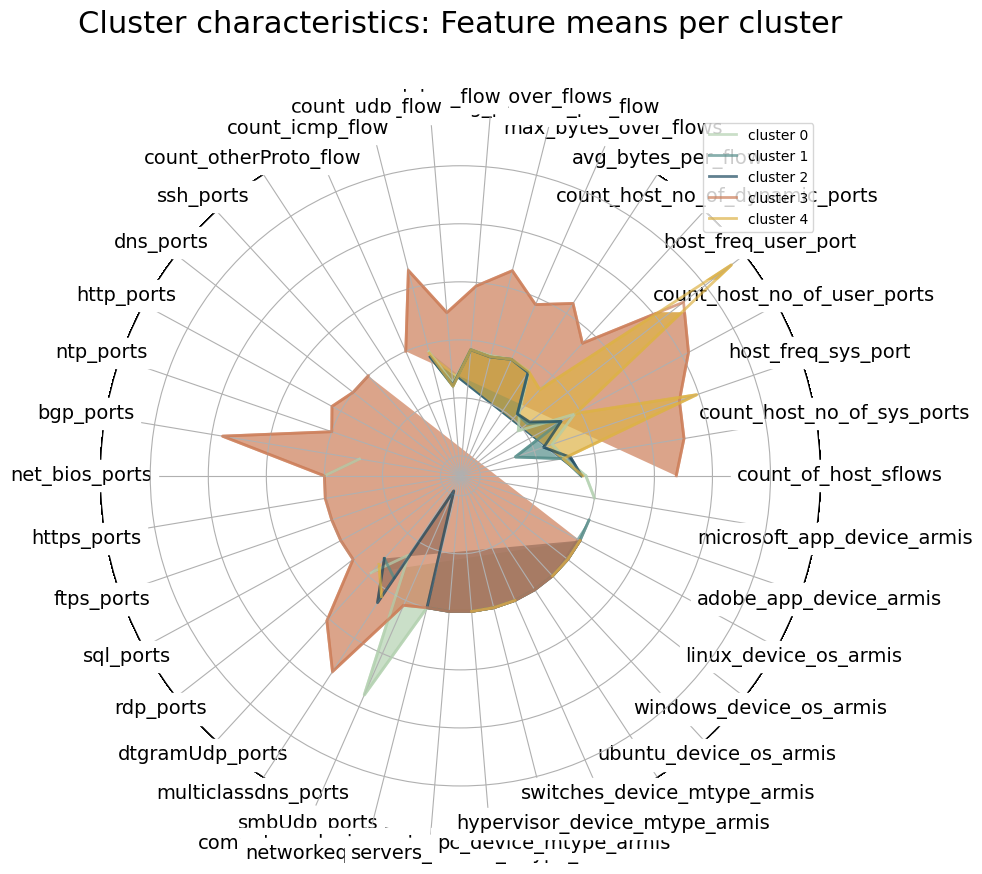

In [29]:

clust_dict = main_s()

### Next steps: 

1. Now that we have evaluated different clusering options, we select the one config where silhouette score is greater or equal than the threshold for all clusters.
2. Extract the updated embedding/indicator for each mac_id (node in the graph). This embedding encapsulates both features (per node) and its connections from the graph (using adjacency matrix)

In [30]:

emb = clust_dict[0.1]['X']
copy_feat_df = feat_df.copy(deep=True)

emb_df = pd.DataFrame(emb, columns=['emb1','emb2','emb3','emb4','emb5'])
emb_df.shape

feature_emb_df = pd.concat([copy_feat_df, emb_df], axis=1)
feature_emb_df.shape

(903, 46)

In [31]:
feature_emb_df.head()

raw_mac  mac_id  count_of_host_sflows  \
0  39:b8:2d:1a:91:17       0                  13.0   
1  72:35:f6:0e:45:a9       1                   2.0   
2  1a:b1:1e:a7:65:74       2                   2.0   
3  29:f4:79:8b:13:ed       3                   1.0   
4  55:70:f3:57:b2:99       4                   NaN   

   count_host_no_of_sys_ports  host_freq_sys_port  \
0                         NaN                 NaN   
1                         NaN                 NaN   
2                         1.0                68.0   
3                         NaN                 NaN   
4                         NaN                 NaN   

   count_host_no_of_user_ports  host_freq_user_port  \
0                          5.0              10318.0   
1                          NaN                  NaN   
2                          NaN                  NaN   
3                          1.0               5353.0   
4                          NaN                  NaN   

   count_host_no_of_dynamic_ports  avg_bytes_per_flow  max_bytes_over_flows  \
0                             3.0          387.076923                 916.0   
1                             2.0          221.000000                 221.0   
2                             NaN          346.000000                 346.0   
3                             NaN          149.000000                 149.0   
4                             NaN                 NaN                   NaN   

   avg_packets_per_flow  max_packets_over_flows  count_tcp_flow  \
0              1.692308                     4.0             NaN   
1              1.000000                     1.0             NaN   
2              1.000000                     1.0             NaN   
3              1.000000                     1.0             NaN   
4                   NaN                     NaN             NaN   

   count_udp_flow  count_icmp_flow  count_otherProto_flow  ssh_ports  \
0            13.0              NaN                    NaN        NaN   
1             2.0              NaN                    NaN        NaN   
2             2.0              NaN                    NaN        NaN   
3             1.0              NaN                    NaN        NaN   
4             NaN              NaN                    NaN        NaN   

   dns_ports  http_ports  ntp_ports  bgp_ports  net_bios_ports  https_ports  \
0        NaN         NaN        NaN        NaN             NaN          NaN   
1        NaN         NaN        NaN        NaN             NaN          NaN   
2        NaN         NaN        NaN        NaN             NaN          NaN   
3        NaN         NaN        NaN        NaN             NaN          NaN   
4        NaN         NaN        NaN        NaN             NaN          NaN   

   ftps_ports  sql_ports  rdp_ports  dtgramUdp_ports  multiclassdns_ports  \
0         NaN        NaN        NaN              NaN                  NaN   
1         NaN        NaN        NaN              2.0                  NaN   
2         NaN        NaN        NaN              NaN                  NaN   
3         NaN        NaN        NaN              NaN                  1.0   
4         NaN        NaN        NaN              NaN                  NaN   

   smbUdp_ports  computers_device_category_armis  \
0           NaN                              1.0   
1           NaN                              1.0   
2           NaN                              NaN   
3           NaN                              NaN   
4           NaN                              NaN   

   networkequip_device_category_armis  servers_device_mtype_armis  \
0                                 NaN                         NaN   
1                                 NaN                         NaN   
2                                 NaN                         NaN   
3                                 NaN                         NaN   
4                                 NaN                         NaN   

   pc_device_mtype_armis  hypervisor_device_mtype_armis  \
0 

In [32]:
# Armis data has multiple devices linked to same mac, hence separating and getting them independently

for i in range(0, 5):
    armis_data_device['mac_address_' + str(i)] = None
temp_res = armis_data_device['mac_address'].apply(lambda x : x.split(','))
for index, row in armis_data_device.iterrows():
    for i in range(min(5, len(temp_res[index]))):
        armis_data_device.loc[index,'mac_address_' + str(i)] = temp_res[index][i]
armis_data_device.head()

mac_address   category  \
0  ed:00:72:91:55:4c  Computers   
1  25:c9:2a:3f:3a:6f  Computers   
2  db:32:80:d6:e9:cc  Computers   
3  2b:ac:3f:44:ef:1f  Computers   
4  ab:06:71:9e:ed:11  Computers   

                                      manufacturer  \
0                         Computers Manufacturer 7   
1  Computers and Network Equipment Manufacturer 14   
2  Computers and Network Equipment Manufacturer 14   
3  Computers and Network Equipment Manufacturer 14   
4                         Computers Manufacturer 3   

                                      model            name operatingSystem  \
0                         Computers Model 0  Computers 1709           Linux   
1                         Computers Model 1  Computers 1298          Ubuntu   
2  Computers and Network Equipment Model 28   Computers 754             NaN   
3                         Computers Model 1  Computers 1311          Ubuntu   
4                         Computers Model 4   Computers 669         Windows   

  operatingSystemVersion  riskLevel               mtype      mac_address_0  \
0                    NaN          6             Servers  ed:00:72:91:55:4c   
1                  18.04          4             Servers  25:c9:2a:3f:3a:6f   
2                    NaN          1             Servers  db:32:80:d6:e9:cc   
3                  18.04          4             Servers  2b:ac:3f:44:ef:1f   
4            Server 2022          7  Personal Computers  ab:06:71:9e:ed:11   

  mac_address_1 mac_address_2 mac_address_3 mac_address_4  
0          None          None          None          None  
1          None          None          None          None  
2          None          None          None          None  
3          None          None          None          None  
4          None          None          None          None

### Mapping feature dataframe with category, mtype, manufacturer, device name and risklevel information from armis

In [33]:
feat_df['category'] = None
feat_df['mtype'] = None
feat_df['manufacturer'] = None
feat_df['name'] = None
feat_df['riskLevel'] = None

for index, row in feat_df.iterrows():
    mac = row['raw_mac']
    match_row = armis_data_device.loc[(armis_data_device.mac_address_0==mac) |
                                      (armis_data_device.mac_address_1==mac) |
                                      (armis_data_device.mac_address_2==mac) |
                                      (armis_data_device.mac_address_3==mac) |
                                      (armis_data_device.mac_address_4==mac)
                                     ]
    if match_row.shape[0]>0:
        feat_df.loc[index, 'category'] = match_row['category'].iloc[0]
        feat_df.loc[index, 'mtype'] = match_row['mtype'].iloc[0]
        feat_df.loc[index, 'manufacturer'] = match_row['manufacturer'].iloc[0]
        feat_df.loc[index, 'name'] = match_row['name'].iloc[0]
        feat_df.loc[index, 'riskLevel'] = match_row['riskLevel'].iloc[0]
    else:
        continue

### Cluster visualization


When armis returns no data, mark as unknown for Viz

In [34]:
feat_df['cluster'] = clust_dict[0.1]['predictions']
feat_df['category'].isnull().sum()
feat_df['category'].fillna(value='Unknown', inplace=True)

feat_df['name'].fillna(value='Unknown', inplace=True)


In [35]:
net = Network(filter_menu=True, notebook=True)
#net.toggle_physics(False)
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252']
attrs = {}
for raw_mac, mac_id in mac_dict.items():
    attrs[mac_id] = {
        #"name":raw_mac,
        "group":int(feat_df.loc[feat_df.mac_id==mac_id,'cluster'].iloc[0]),
        "label":feat_df.loc[feat_df.mac_id==mac_id,'category'].iloc[0],
        #"dev":feat_df.loc[feat_df.mac_id==mac_id,'mtype'].iloc[0],
        "title": feat_df.loc[feat_df.mac_id==mac_id,'name'].iloc[0],
        "color": cluster_colors[feat_df.loc[feat_df.mac_id==mac_id,'cluster'].iloc[0]]
    }
G_2 = G.copy()
nx.set_node_attributes(G_2, attrs)

### The networkX viz used in RSA and other presentations

In [36]:
net.from_nx(G_2)
net.show('ac_v3.html')

ac_v3.html


<font color=#b4d2b1>**Cluster 1**</font>, 
<font color='#568f8b'>**Cluster 2**</font>,
<font color=#1d4a60>**Cluster 3**</font>,
<font color=#cd7e59>**Cluster 4**</font>
and <font color=#ddb247>**Cluster 5**</font>.

### Use cases:

#### Inter group communication

In [37]:
sflow_raw.head(5)

SRC_MAC            DST_MAC           SRC_IP           DST_IP  \
0  88:67:e2:88:87:62  0d:81:34:59:a5:70  192.168.102.133      10.50.49.94   
1  14:08:ec:aa:7c:9d  1b:b5:67:2e:d1:fe    172.28.16.147    172.16.44.115   
2  d2:fe:1a:3d:54:2c  a6:15:ec:b8:af:c6    10.219.76.151   172.23.118.139   
3  88:67:e2:88:87:62  0d:81:34:59:a5:70   172.17.239.190      10.50.49.94   
4  51:f1:7e:33:d1:2c  16:87:ca:d2:3d:f8    172.22.69.109  192.168.207.169   

   SRC_PORT  DST_PORT PROTOCOL  SH_COUNTRY  DH_COUNTRY  SH_LAT  SH_LON  \
0       443     34170      tcp         NaN         NaN     0.0     0.0   
1      8182      8182      udp         NaN         NaN     0.0     0.0   
2     20530      4789      udp         NaN         NaN     0.0     0.0   
3       443     54300      tcp         NaN         NaN     0.0     0.0   
4      5434     53626      tcp         NaN         NaN     0.0     0.0   

   DH_LAT  DH_LON             TIMESTAMP_START  PACKETS  BYTES sflow_type  
0     0.0     0.0  0000-00-00 00:00:00.000000        1   1532    cumulus  
1     0.0     0.0  0000-00-00 00:00:00.000000        1    376    cumulus  
2     0.0     0.0  0000-00-00 00:00:00.000000        1   1582    cumulus  
3     0.0     0.0  0000-00-00 00:00:00.000000        1   1532    cumulus  
4     0.0     0.0  0000-00-00 00:00:00.000000        1    105    cumulus

In [38]:
# Use the mac to id mapping to populate src and mac id in sflow data
sflow_raw['src_mac_id'] = sflow_raw['SRC_MAC'].apply(lambda x : mac_dict[x])
sflow_raw['dst_mac_id'] = sflow_raw['DST_MAC'].apply(lambda x : mac_dict[x])

# Using the mac ID, populate the cluster information from model
sflow_raw['SRC_MAC_cluster'] = sflow_raw['src_mac_id'].apply(lambda x : feat_df.loc[feat_df.mac_id == x,'cluster'].iloc[0])
sflow_raw['DST_MAC_cluster'] = sflow_raw['dst_mac_id'].apply(lambda x : feat_df.loc[feat_df.mac_id == x,'cluster'].iloc[0])

In [39]:
inter_group = sflow_raw.loc[sflow_raw.SRC_MAC_cluster!=sflow_raw.DST_MAC_cluster]
inter_group.shape

(2388, 21)

In [40]:
inter_group.shape[0]*100/sflow_raw.shape[0]

11.941194119411941

### Key takeaway: Only 8.5% devices communicate with devices outside of their cluster

In [41]:
inter_group.shape[0]*100/sflow_raw.shape[0]

11.941194119411941

In [42]:
inter_group.sample()

SRC_MAC            DST_MAC         SRC_IP          DST_IP  \
10790  ef:a2:03:b9:00:42  ed:2a:e6:7c:d3:9b  172.28.153.48  172.20.177.171   

       SRC_PORT  DST_PORT PROTOCOL  SH_COUNTRY  DH_COUNTRY  SH_LAT  SH_LON  \
10790         0         0     igmp         NaN         NaN     0.0     0.0   

       DH_LAT  DH_LON             TIMESTAMP_START  PACKETS  BYTES sflow_type  \
10790     0.0     0.0  0000-00-00 00:00:00.000000        1     64     arista   

       src_mac_id  dst_mac_id  SRC_MAC_cluster  DST_MAC_cluster  
10790         890         500                4                2

### 5. Conclusion


A graph based clustering approach can offer several advantages over standard clustering approaches, especially when dealing with complex data that exhibit non-linear relationships and dependencies. Here are some reasons why a graph based asset clustering approach might be better:

**1. Incorporation of Complex Relationships**:
**Graph Representation**: Graph encoder-based methods can capture intricate relationships between data points, considering both local and global connectivity patterns. This is crucial for data where simple distance-based metrics might not effectively capture underlying structures.

**2. Non-Linearity Handling**:
**Non-Linear Relationships**: Graph encoders, often coupled with graph neural networks (GNNs), can model non-linear relationships effectively. This is particularly useful when data clusters are defined by complex non-linear interactions.

**3. Graph Topology Utilization**:
**Leveraging Graph Structure**: These methods explicitly utilize the graph topology, which might include information about similarity, affinity, or hierarchy among data points. This can improve the clustering by incorporating domain-specific information.

**4. Robustness to Noise and Outliers**:
**Robustness**: Graph encoders can inherently handle noisy data and outliers, as the graph structure smooths out the influence of noisy neighbors. This can lead to more stable and meaningful cluster assignments.

**5. Hierarchical Clustering**:
**Hierarchical Relationships**: Graph-based approaches can naturally handle hierarchical clustering, where data points are grouped at different levels of granularity based on the graph structure.

**6. Feature Learning and Representation**:
**Learned Representations**: Graph encoder-based methods simultaneously learn meaningful feature representations and cluster assignments. This can lead to more informative features that capture underlying characteristics.

**7. Semi-Supervised and Few-Shot Clustering**:
**Semi-Supervised Learning**: Graph encoders can incorporate labeled data or constraints in a semi-supervised manner, which can be especially valuable when a limited amount of labeled information is available.

**8. Community Detection and Overlapping Clusters**:
**Overlapping Clusters**: Graph-based methods naturally handle scenarios where data points can belong to multiple clusters or communities, which might be challenging for traditional clustering techniques.

**9. Transfer Learning and Adaptation**:
**Transfer Learning**: Pre-trained graph encoders can be fine-tuned or adapted to new datasets, making them useful for transfer learning in clustering tasks.


### Reference
[1]. H. Zhang, P. Li, R. Zhang and X. Li, "Embedding Graph Auto-Encoder for Graph Clustering," in IEEE Transactions on Neural Networks and Learning Systems, doi: 10.1109/TNNLS.2022.3158654.